# FIN30290 - Group Project

## Assignment Context
The U.S. Small Business Administration (SBA) plays a crucial role in supporting small businesses, which are a primary source of job creation in the United States. By fostering small business formation and growth, the SBA contributes to bring social and economic benefits such as
creating job opportunities and reducing unemployment. 

A key mechanism the SBA uses to assist small businesses is its loan guarantee program. This program encourages banks to provide loans to small businesses by reducing the risk of these loans. Similar to an insurance provider, the SBA guarantees a portion of the loan, covering that portion if the loan defaults. However, since the SBA only guarantees part of the loan, banks still bear some risk if a business defaults. To address this credit risk challenge, banks may use data analysis and machine learning models to assess the likelihood of a small business defaulting.

These models can help banks identify applicants who pose higher risks and better inform decision-making processes. Effectively forecasting default risk enables banks to mitigate credit losses, enhance the efficiency of resource allocation, and inform long-term strategic planning. 

This data set is from the U.S. Small Business Administration (SBA) and provides historical data from **1962** through 
**2014**. This large data set contains **29 variables** and **899,164 observations**. You can find the data for the project on Brightspace (MyLearning \ Group Assignment) and the variable descriptions below.

**The objective of the classification task is to predict whether a loan will default (`MIS_Status`] = 0) or not. As a loan officer, should you grant a loan to a particular small business? You should make this decision by assessing the loan’s risk of repayment.** Tapping into the repertoire of your Machine Learning modelling, evaluation and deployment knowledge, provide recommendations to the bank’s lending department to achieve its goal.

*Hint: The `Default` variable should be generated based on the `MIS_Status` column, serving as the target variable for analysis.*

In [1]:
# === Ignore Warnings ===
import warnings
warnings.filterwarnings(action='ignore')

# === Core Libraries ===
import math
import numpy as np
import pandas as pd
from collections import Counter

# === Display and Output Formatting ===
from IPython.display import Image
from tabulate import tabulate

# === Plotting & Visualisation ===
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# === Statistical Analysis ===
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import chi2_contingency, randint, ttest_ind
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# === Preprocessing ===
from sklearn.preprocessing import StandardScaler

# === Feature Selection ===
from sklearn.feature_selection import RFE, mutual_info_classif
from sklearn.inspection import permutation_importance

# === Clustering ===
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import calinski_harabasz_score
from yellowbrick.cluster import KElbowVisualizer

# === Dimensionality Reduction (PCA) ===
from sklearn.decomposition import PCA

# === Model Selection and Validation ===
from sklearn.model_selection import (
    GridSearchCV, KFold, RandomizedSearchCV, RepeatedKFold,
    RepeatedStratifiedKFold, StratifiedKFold, cross_val_score,
    cross_validate, train_test_split
)
from sklearn.utils import shuffle

# === Classification Models ===
from sklearn import svm, tree
from sklearn.ensemble import (
    AdaBoostClassifier, BaggingClassifier, GradientBoostingRegressor,
    RandomForestClassifier
)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

# === Calibration ===
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# === Evaluation Metrics ===
from sklearn.metrics import (
    ConfusionMatrixDisplay, accuracy_score, auc, classification_report,
    confusion_matrix, f1_score, mean_squared_error, precision_recall_curve,
    precision_score, recall_score, roc_auc_score, roc_curve, zero_one_loss
)

# === Model Persistence & Explainability ===
import joblib
import shap


## Data set

First let's look at the variables and their descriptions

| **Variable Name**      | **Data Type** | **Description of Variable**                                                                 |
|------------------------|---------------|----------------------------------------------------------------------------------------------|
| LoanNr_ChkDgt          | Text          | Identifier – Primary Key                                                                     |
| Name                   | Text          | Borrower Name                                                                                |
| City                   | Text          | Borrower City                                                                                |
| State                  | Text          | Borrower State                                                                               |
| Zip                    | Text          | Borrower Zip Code                                                                            |
| Bank                   | Text          | Bank Name                                                                                    |
| BankState              | Text          | Bank State                                                                                   |
| NAICS                  | Text          | North American Industry Classification System code                                           |
| ApprovalDate           | Date/Time     | Date SBA Commitment Issued                                                                   |
| ApprovalFY             | Text          | Fiscal Year of Commitment                                                                    |
| Term                   | Number        | Loan term in months                                                                          |
| NoEmp                  | Number        | Number of Business Employees                                                                 |
| NewExist               | Text          | 1 = Existing Business, 2 = New Business                                                       |
| CreateJob              | Number        | Number of jobs created                                                                       |
| RetainedJob            | Number        | Number of jobs retained                                                                      |
| FranchiseCode          | Text          | Franchise Code 00000 or 00001 = No Franchise                                                 |
| UrbanRural             | Text          | 1 = Urban, 2 = Rural, 0 = Undefined                                                          |
| RevLineCr              | Text          | Revolving Line of Credit: Y = Yes                                                            |
| LowDoc                 | Text          | LowDoc Loan Program: Y = Yes, N = No                                                         |
| ChgOffDate             | Date/Time     | The date when a loan is declared to be in default                                            |
| DisbursementDate       | Date/Time     | Disbursement Date                                                                            |
| DisbursementGross      | Currency      | Amount Disbursed                                                                             |
| BalanceGross           | Currency      | Gross amount outstanding                                                                     |
| MIS_Status             | Number        | =0 default, =1 not default                                                                   |
| Minority               | Number        | =1 if the race of business owner belongs to a minority                                       |
| ChgOffPrinGr           | Currency      | Charged-off amount, the principal amount of a loan that is declared as defaulted by the bank |
| GrAppv                 | Currency      | Gross amount of loan approved by the bank                                                    |
| SBA_Appv               | Currency      | SBA's guaranteed amount of the approved loan                                                 |
| DaysToDisbursement     | Days          | DisbursementDate - LoanApprovalDate                                                          |
| Industry               | Text          | Refers to the first two digits of NAICS, the industry code classification for the loan       |
| LowDoc (re-encoded)    | Numerical     | LowDoc Loan Program: 7 = Yes, 4 = No                                                         |
| RevLineCr (re-encoded) | Numerical     | Revolving line of credit: 16 = Yes, 12 = No                                                  |


| **Sector** | **Description**                                                                 |
|------------|----------------------------------------------------------------------------------|
| 11         | Agriculture, forestry, fishing and hunting                                       |
| 21         | Mining, quarrying, and oil and gas extraction                                    |
| 22         | Utilities                                                                         |
| 23         | Construction                                                                      |
| 31–33      | Manufacturing                                                                     |
| 42         | Wholesale trade                                                                   |
| 44–45      | Retail trade                                                                      |
| 48–49      | Transportation and warehousing                                                    |
| 51         | Information                                                                       |
| 52         | Finance and insurance                                                             |
| 53         | Real estate and rental and leasing                                                |
| 54         | Professional, scientific, and technical services                                  |
| 55         | Management of companies and enterprises                                           |
| 56         | Administrative and support and waste management and remediation services         |
| 61         | Educational services                                                              |
| 62         | Health care and social assistance                                                 |
| 71         | Arts, entertainment, and recreation                                               |
| 72         | Accommodation and food services                                                   |
| 81         | Other services (except public administration)                                     |
| 92         | Public administration                                                             |


# Q1 (a)

*Perform and report exploratory data analytics in the data (e.g., visuals, descriptive statistics).
State any observations which are pertinent to the purpose of this report, i.e., to inform a
predictive model which can guide lending decision-making.*

## Data Cleaning/Preparation

In [2]:
# Import the data
data = pd.read_csv('SBAnational_clean.csv')

# Check variables and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 30 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   LoanNr_ChkDgt       899164 non-null  int64 
 1   Name                899164 non-null  int64 
 2   City                899164 non-null  int64 
 3   State               899164 non-null  int64 
 4   Zip                 899164 non-null  int64 
 5   Bank                899164 non-null  int64 
 6   BankState           899164 non-null  int64 
 7   NAICS               899164 non-null  int64 
 8   ApprovalDate        899164 non-null  object
 9   ApprovalFY          899164 non-null  int64 
 10  Term                899164 non-null  int64 
 11  NoEmp               899164 non-null  int64 
 12  NewExist            899164 non-null  int64 
 13  CreateJob           899164 non-null  int64 
 14  RetainedJob         899164 non-null  int64 
 15  FranchiseCode       899164 non-null  int64 
 16  Ur

In [3]:
# So we can see all variables
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
data.head()

LoanNr_ChkDgt    Name   City  State    Zip  Bank  BankState   NAICS  \
0     1000014003   12791   8558     15  47711  2143         38  451120   
1     1000024006  405593  19588     15  46526   132         18  722410   
2     1000034009  759976   2206     15  47401  2859         18  621210   
3     1000044001   83888   2720     36  74012    25         39       0   
4     1000054004   38543  21134      9  32801  2683         11       0   

  ApprovalDate  ApprovalFY  Term  NoEmp  NewExist  CreateJob  RetainedJob  \
0    2/28/1997        1997    84      4         2          0            0   
1    2/28/1997        1997    60      2         2          0            0   
2    2/28/1997        1997   180      7         1          0            0   
3    2/28/1997        1997    60      2         1          0            0   
4    2/28/1997        1997   240     14         1          7            7   

   FranchiseCode  UrbanRural  RevLineCr  LowDoc ChgOffDate DisbursementDate  \
0              1           0         12       7        NaN        2/28/1999   
1              1           0         12       7        NaN        5/31/1997   
2              1           0         12       4        NaN       12/31/1997   
3              1           0         12       7        NaN        6/30/1997   
4              1           0         12       4        NaN        5/14/1997   

   DisbursementGross  BalanceGross  MIS_Status  ChgOffPrinGr  GrAppv  \
0              60000             0           1             0   60000   
1              40000             0           1             0   40000   
2             287000             0           1             0  287000   
3              35000             0           1             0   35000   
4             229000             0           1             0  229000   

   SBA_Appv  DaysToDisbursement  Industry  Minority  
0     48000                 730        45         0  
1     32000                  92        72         0  
2    215250                 306        62         0  
3     28000                 122         0         0  
4    229000                  75         0         0

In [4]:
data.tail()

LoanNr_ChkDgt    Name   City  State    Zip  Bank  BankState   NAICS  \
899159     9995573004  248277  29517     35  43221  3225         17  451120   
899160     9995603000  248277   5155     35  43221  3225         17  451130   
899161     9995613003  570957  25349      4  93455  4335          5  332321   
899162     9995973006  444418  12398     11  96830   551         14       0   
899163     9996003010  521251  13788     11  96734  1077         14       0   

       ApprovalDate  ApprovalFY  Term  NoEmp  NewExist  CreateJob  \
899159    2/27/1997        1997    60      6         1          0   
899160    2/27/1997        1997    60      6         1          0   
899161    2/27/1997        1997   108     26         1          0   
899162    2/27/1997        1997    60      6         1          0   
899163    2/27/1997        1997    48      1         2          0   

        RetainedJob  FranchiseCode  UrbanRural  RevLineCr  LowDoc  ChgOffDate  \
899159            0              1           0          3       4  07/07/2004   
899160            0              1           0         16       4  07/07/2004   
899161            0              1           0         12       4  07/07/2004   
899162            0              1           0         12       7  03/08/2000   
899163            0              1           0         12       4  03/08/2000   

       DisbursementDate  DisbursementGross  BalanceGross  MIS_Status  \
899159        9/30/1997              70000             0           1   
899160       10/31/1997              85000             0           1   
899161        9/30/1997             300000             0           1   
899162        3/31/1997              75000             0           0   
899163        5/31/1997              30000             0           1   

        ChgOffPrinGr  GrAppv  SBA_Appv  DaysToDisbursement  Industry  Minority  
899159             0   70000     56000                 215        45         0  
899160             0   85000     42500                 246        45         1  
899161             0  300000    225000                 215        33         0  
899162         46383   75000     60000                  32         0         1  
899163             0   30000     24000                  93         0         0

### Dropping Post Outcome Variables

| Variable             | Classification | Reason |
|----------------------|----------------|--------|
| `LoanNr_ChkDgt`      | Drop         | Identifier, not predictive |
| `Name`               | Drop         | Identifier (PII), not usable |
| `City`               | Keep         | Known at application |
| `State`              | Keep         | Known at application |
| `Zip`                | Keep         | Known at application |
| `Bank`               | Keep         | Known at application |
| `BankState`          | Keep         | Known at application |
| `NAICS`              | Keep         | Industry of borrower – known |
| `ApprovalDate`       | Keep         | Application/approval date |
| `ApprovalFY`         | Keep         | Derived from approval date |
| `Term`               | Keep         | Loan term – set at approval |
| `NoEmp`              | Keep         | Employees – from application |
| `NewExist`           | Keep         | Whether the business is new – known |
| `CreateJob`          | Judgement Call | Could be forecasted or actual – clarify from data |
| `RetainedJob`        | Drop         | Likely reflects *realised* retention (post-outcome) |
| `FranchiseCode`      | Keep         | Known at application |
| `UrbanRural`         | Keep         | Geographic classification – known |
| `RevLineCr`          | Keep         | Whether it’s a revolving credit line – known |
| `LowDoc`             | Keep         | Whether it’s under LowDoc programme – known |
| `ChgOffDate`         | Drop         | Happens **after** default – clear leakage |
| `DisbursementDate`   | Judgement Call | Often comes *after* approval – be cautious |
| `DisbursementGross`  | Drop         | Reflects actual transfer, which can differ from approval – post-approval |
| `BalanceGross`       | Drop         | Outstanding balance – only known after repayment begins |
| `MIS_Status`         | Target Variable | Use to define `Default` |
| `Minority`           | Keep         | Borrower’s race classification – known at approval |
| `ChgOffPrinGr`       | Drop         | Principal charged off – happens after default |
| `GrAppv`             | Keep         | Loan amount approved – key feature |
| `SBA_Appv`           | Keep         | SBA's guaranteed portion – known at approval |
| `DaysToDisbursement` | Judgement Call | Derived post-hoc – only valid if you argue it’s process-related, not outcome-related |
| `Industry`           | Keep         | Derived from NAICS – valid |

We excluded all post outcome variables due to concerns around data leakage:

We made a deliberate decision to exclude the`DisbursementGross` variables for the following reasons:

- **Timing Misalignment**: While `DisbursementGross` appears similar to the approved loan amount (`GrAppv`), it reflects the actual amount disbursed, which may differ due to post-approval events such as borrower withdrawal, administrative changes, or partial funding.
- **Evidence of Post-Outcome Influence**: A comparison of `DisbursementGross` and `GrAppv` across the dataset revealed a substantial aggregate difference (~$7.6 billion), suggesting that `DisbursementGross` includes information not available at the time of approval.
- **Risk of Data Leakage**: Including this variable could unintentionally introduce information about future outcomes into the model, undermining its ability to generalise to real-world lending decisions made *at the point of approval*.

To ensure our model remains realistic and robust, we chose to drop `DisbursementGross` and instead use `GrAppv` and `SBA_Appv` as proxies for the loan size and guarantee amount, both of which are known at approval time.

In [5]:
# List of variables to drop
drop_columns = [
    'LoanNr_ChkDgt',
    'Name',
    'CreateJob',
    'RetainedJob',
    'ChgOffDate',
    'DisbursementDate',
    'DisbursementGross',
    'BalanceGross',
    'ChgOffPrinGr',
    'DaysToDisbursement'
]

# Drop these columns from your dataset
data = data.drop(columns=drop_columns)

### Convert Date columns stored as objects to datetime

In [6]:
data['ApprovalDate'] = pd.to_datetime(data['ApprovalDate'])

### Adjust Target Variable
The original target variable `MIS_Status` uses 0 to indicate default and 1 to indicate non-default, which is counterintuitive for classification tasks where 1 typically represents the positive class. To align with standard practice and improve clarity in model interpretation and communication, we create a new binary variable `Default` where 1 indicates a loan default and 0 indicates no default.


In [7]:
data['Default'] = data['MIS_Status'].apply(lambda x: 1 if x == 0 else 0)

### Dealing with category variables

#### LowDoc & RevLineCr
Adjusting `LowDoc` and `RevLineCr`: These are string variables ('Y'/'N') and need to be converted to numeric format for models.

In [8]:
# Reload original values (if still available)
print(data['RevLineCr'].unique())

[12  3 16 15 17  0  4 11  6  5 14  9 10  8  2  7  1 13]


In [9]:
# Convert LowDoc from 7 = Yes, 4 = No to binary 1/0
data['LowDoc'] = data['LowDoc'].map({7: 1, 4: 0})

# Convert RevLineCr from 16 = Yes, 12 = No to binary 1/0
data['RevLineCr'] = data['RevLineCr'].map({16: 1, 12: 0})

#### NewExist
Adjusting `NewExist`: This variable indicates whether the business is new or existing.

1 → Existing

2 → New

We’ll convert it into a binary variable where:

0 = Existing business

1 = New business

In [10]:
# Convert 'NewExist': 1 → 0 (existing), 2 → 1 (new)
data['NewExist'] = data['NewExist'].map({1: 0, 2: 1})

#### UrbanRural
Encode `UrbanRural`: This variable is coded as

1 → Urban

2 → Rural

0 → Undefined

We will treat 0 as missing, then one-hot encode the rest

This creates:

`UrbanRural_2` = 1 if Rural, 0 if Urban
(Urban is the base case)

In [11]:
# Replace 0 with NaN and one-hot encode UrbanRural
data['UrbanRural'] = data['UrbanRural'].replace(0, np.nan)

# One-hot encode UrbanRural, dropping one column to avoid multicollinearity
data = pd.get_dummies(data, columns=['UrbanRural'], prefix='UrbanRural', drop_first=True)


#### FranchiseCode
`FranchiseCode`: This variable identifies whether the business is part of a franchise. Codes 00000 and 00001 represent no franchise, everything else implies it is a franchise.

We'll convert this to a binary variable `HasFranchise`:

0 = No franchise

1 = Franchise

Then drop the original `FranchiseCode`.

In [12]:
# Create binary indicator for franchise status
data['HasFranchise'] = data['FranchiseCode'].apply(lambda x: 0 if str(x).zfill(5) in ['00000', '00001'] else 1)

# Drop original FranchiseCode column
data.drop(columns=['FranchiseCode'], inplace=True)

#### NAICS
Extract Industry Sector from `NAICS_Sector`

NAICS codes represent industry classification. Instead of using the full code, we’ll extract the first two digits to capture the industry sector (e.g., 31 = Manufacturing, 72 = Hospitality).

Then we’ll:

One-hot encode the new sector variable

Drop the original NAICS column

In [13]:
# Extract first two digits as a new column for sector
data['NAICS_Sector'] = data['NAICS'].astype(str).str[:2]

# One-hot encode NAICS_Sector (drop_first=True avoids multicollinearity)
data = pd.get_dummies(data, columns=['NAICS_Sector'], drop_first=True)

# Drop the original NAICS column
data.drop(columns=['NAICS'], inplace=True)


#### Justification for Dropping Categorical Variables

Before dropping high-cardinality or potentially redundant categorical variables such as `State`, `Bank`, `City`, and `Zip`,
we perform a statistical test to confirm that they do not have a significant relationship with the target variable `Default`.

We use the Chi-square test of independence to assess whether each variable is associated with default outcomes.
A high p-value (typically > 0.05) indicates that the variable and the target are likely independent, justifying its removal.
To support our conclusion visually, we also include count plots to inspect the distribution of defaults across categories.
This step ensures that we maintain relevant features and drop uninformative ones in a statistically sound manner.


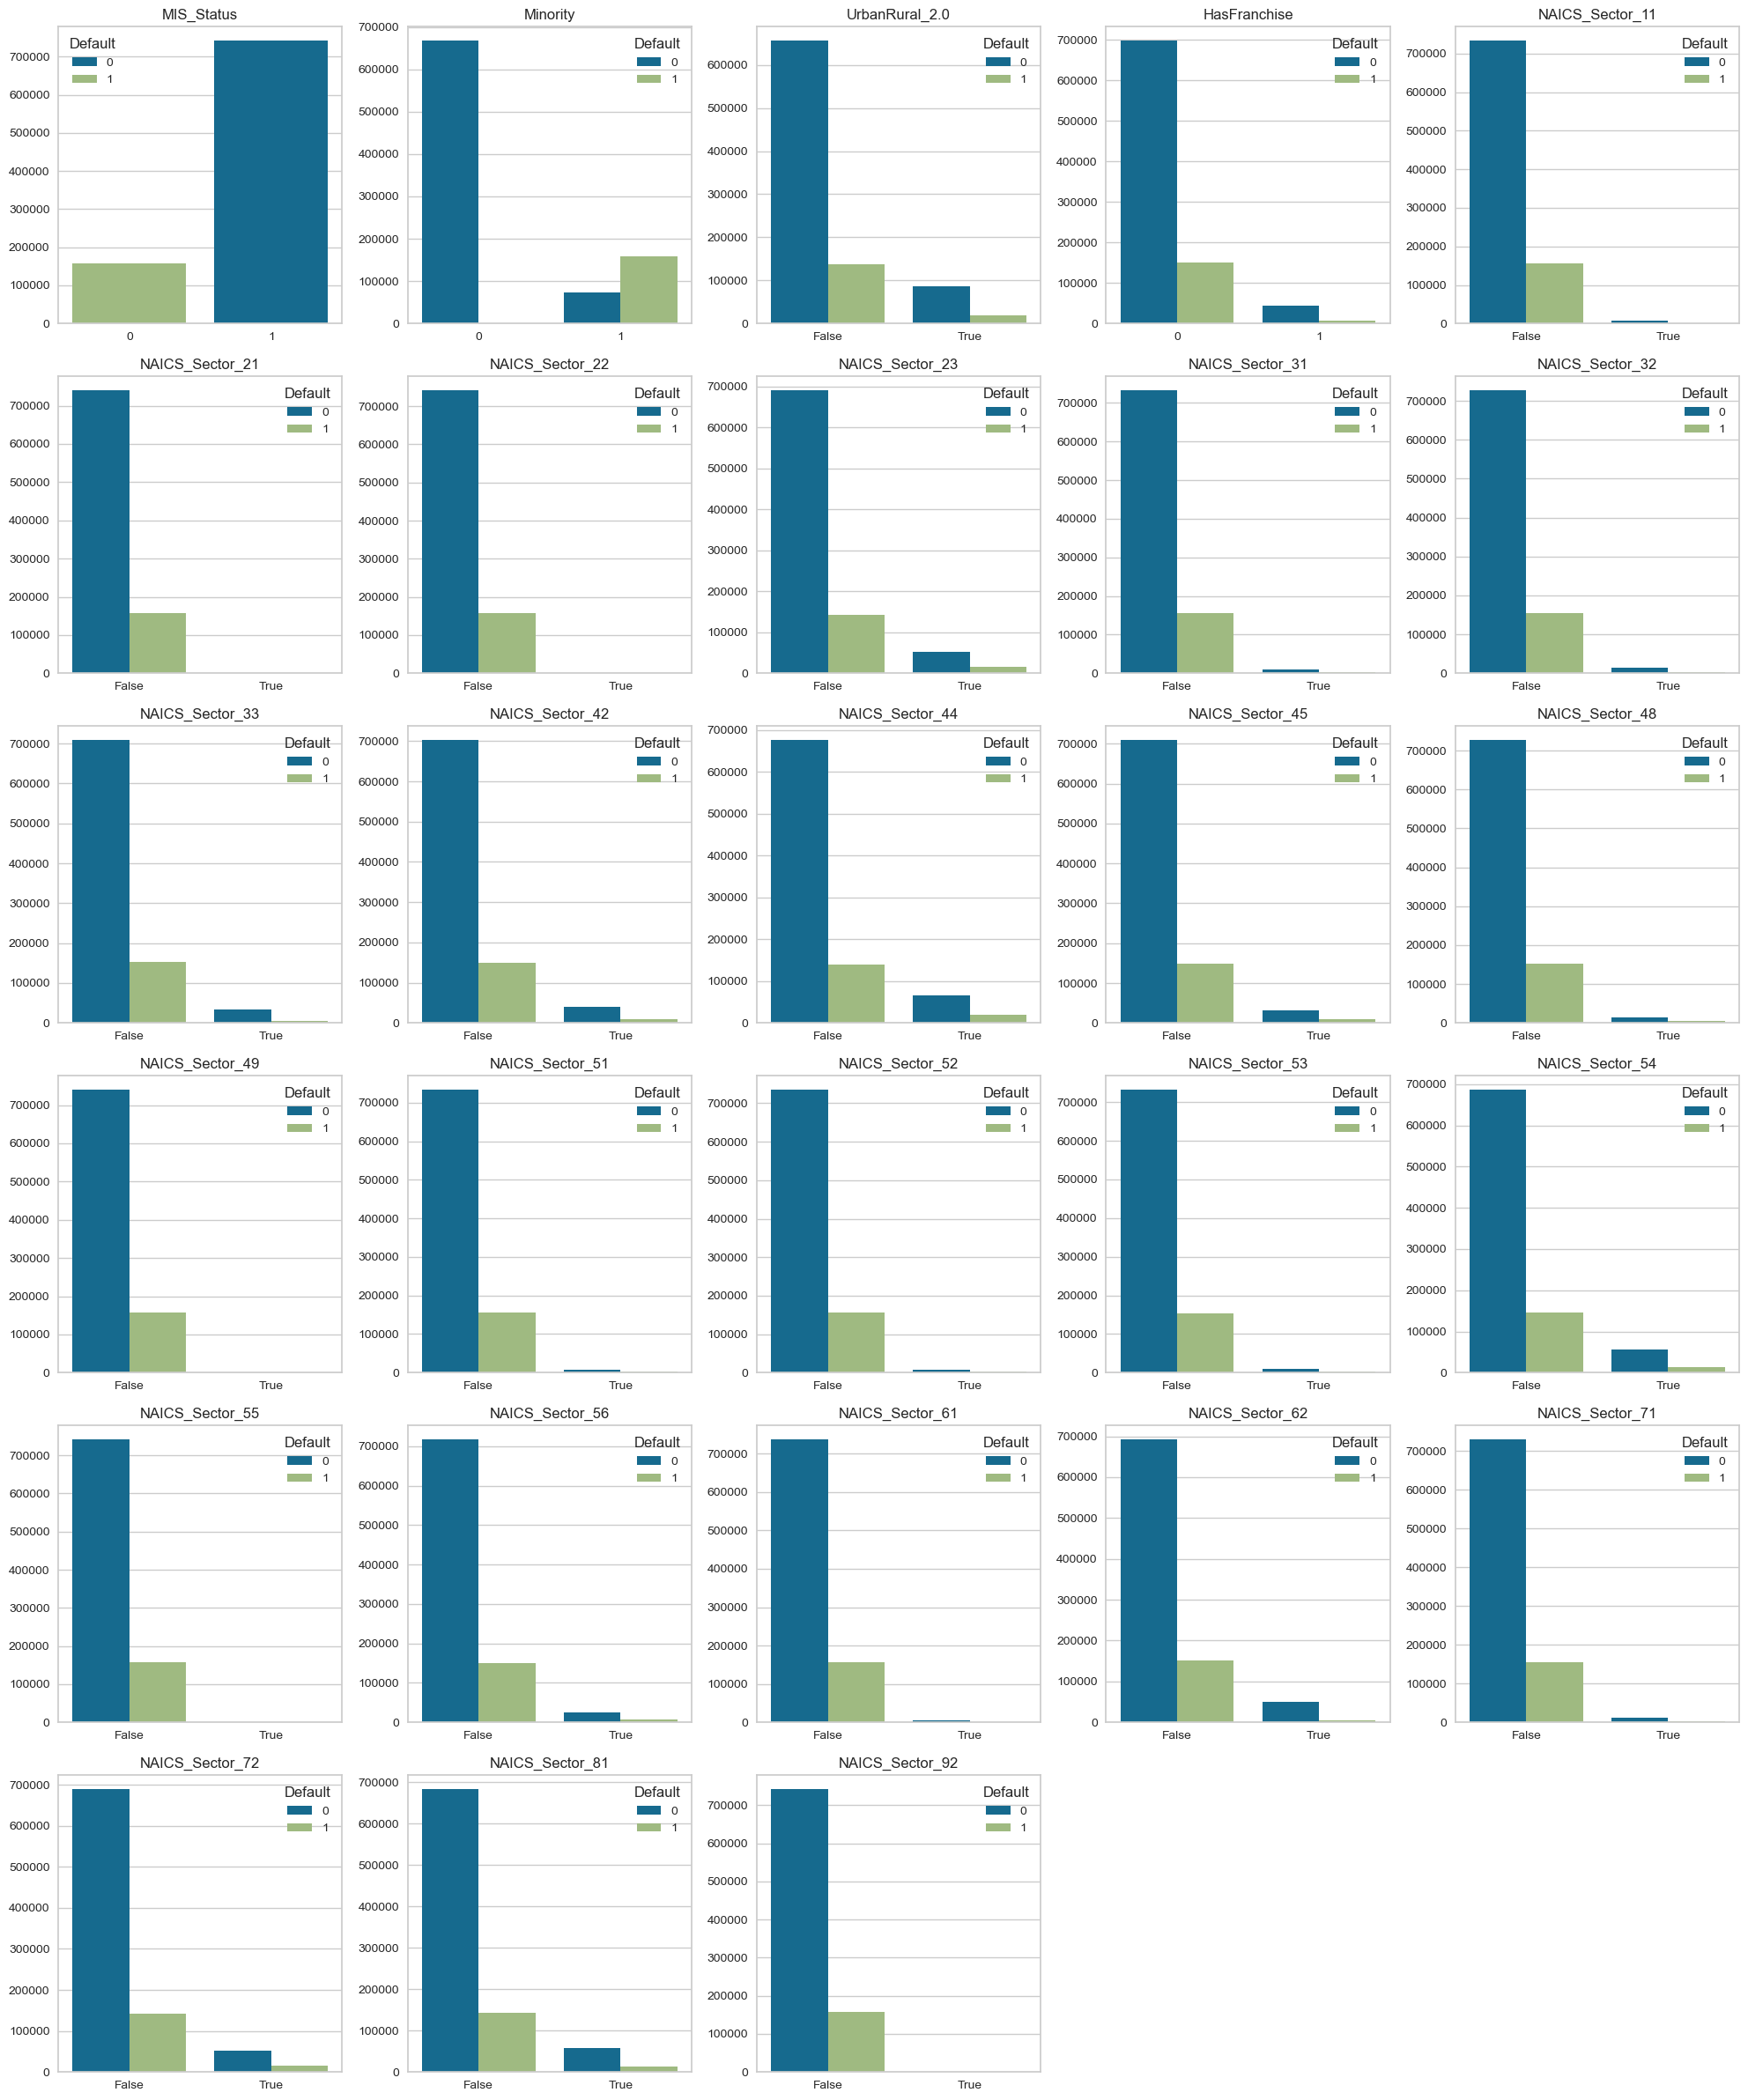

In [14]:
# Select categorical variables (excluding target)
categorical_vars = [col for col in data.columns 
                    if data[col].nunique() <= 10 and data[col].dtype in ['int64', 'bool'] 
                    and col != 'Default']

# Layout settings
plots_per_row = 5
total = len(categorical_vars)
rows = math.ceil(total / plots_per_row)

# Create subplots
fig, axes = plt.subplots(rows, plots_per_row, figsize=(plots_per_row * 4, rows * 4))
axes = axes.flatten()

# Loop through variables to plot
for i, var in enumerate(categorical_vars):
    sns.countplot(data=data, x=var, hue='Default', ax=axes[i])
    axes[i].set_title(var)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

#Turn off unused subplot
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### UrbanRural

Taking `UrbanRural_2.0` for an example.

The plot shows the count of loans by `UrbanRural_2.0`, split by default outcome:

X-axis: Urban (False) vs Rural (True)

Y-axis: Number of loans

Blue bars = Loans that did not default (`Default = 0`)

Orange bars = Loans that did default (`Default = 1`)

Urban (False): Vast majority of loans come from urban borrowers (over 600,000 non-defaults). Also has more defaults overall but the proportion is moderate

Rural (True): Fewer total loans, but visually, the default proportion looks a bit lower than urban

#### NAICS_Sector_44

Comparing number of defaults in:

True → Loan is in Retail sector

False → Loan is in any other sector

Retail (True): Much smaller total loan count than non-retail. Slightly fewer defaults, but default bar is proportionally larger than non-retail

Non-Retail (False): Makes up the vast majority of loans — and has many more non-default

Although Retail businessesrepresent a smaller portion of the total, their default rate appears higher which aligns with thi chi-square results where Sector_44 was one of the most significant sectors associated with higher default rates.

Retail loans may carry more risk, possibly due to: Thin margins, High fixed costs and Exposure to consumer sentiment and foot traffic

In [15]:
chi2_results = []

for var in categorical_vars:
    contingency = pd.crosstab(data[var], data['Default'])
    chi2, p, dof, ex = chi2_contingency(contingency)
    chi2_results.append((var, p))

# Create sorted dataframe of results
chi2_df = pd.DataFrame(chi2_results, columns=['Variable', 'p_value']).sort_values(by='p_value')

#Format p-values as standard float (not scientific notation
chi2_df['p_value'] = chi2_df['p_value'].apply(lambda x: f"{x:.6f}")
print(chi2_df)

           Variable   p_value
0        MIS_Status  0.000000
1          Minority  0.000000
23  NAICS_Sector_62  0.000000
12  NAICS_Sector_44  0.000000
7   NAICS_Sector_23  0.000000
14  NAICS_Sector_48  0.000000
18  NAICS_Sector_53  0.000000
13  NAICS_Sector_45  0.000000
25  NAICS_Sector_72  0.000000
21  NAICS_Sector_56  0.000000
17  NAICS_Sector_52  0.000000
4   NAICS_Sector_11  0.000000
10  NAICS_Sector_33  0.000000
16  NAICS_Sector_51  0.000000
26  NAICS_Sector_81  0.000000
3      HasFranchise  0.000000
22  NAICS_Sector_61  0.000000
11  NAICS_Sector_42  0.000000
2    UrbanRural_2.0  0.000000
19  NAICS_Sector_54  0.000000
5   NAICS_Sector_21  0.000000
24  NAICS_Sector_71  0.000000
15  NAICS_Sector_49  0.000000
8   NAICS_Sector_31  0.000000
9   NAICS_Sector_32  0.000026
20  NAICS_Sector_55  0.002236
6   NAICS_Sector_22  0.024910
27  NAICS_Sector_92  0.411577


Most variables, including Minority status, Franchise affiliation, and several NAICS industry sectors, showed statistically significant
associations with default status (p < 0.01). `NAICS_Sector_92` (Public Administration), however, showed no significant relationship (p = 0.41)
and may be considered for exclusion or aggregation.


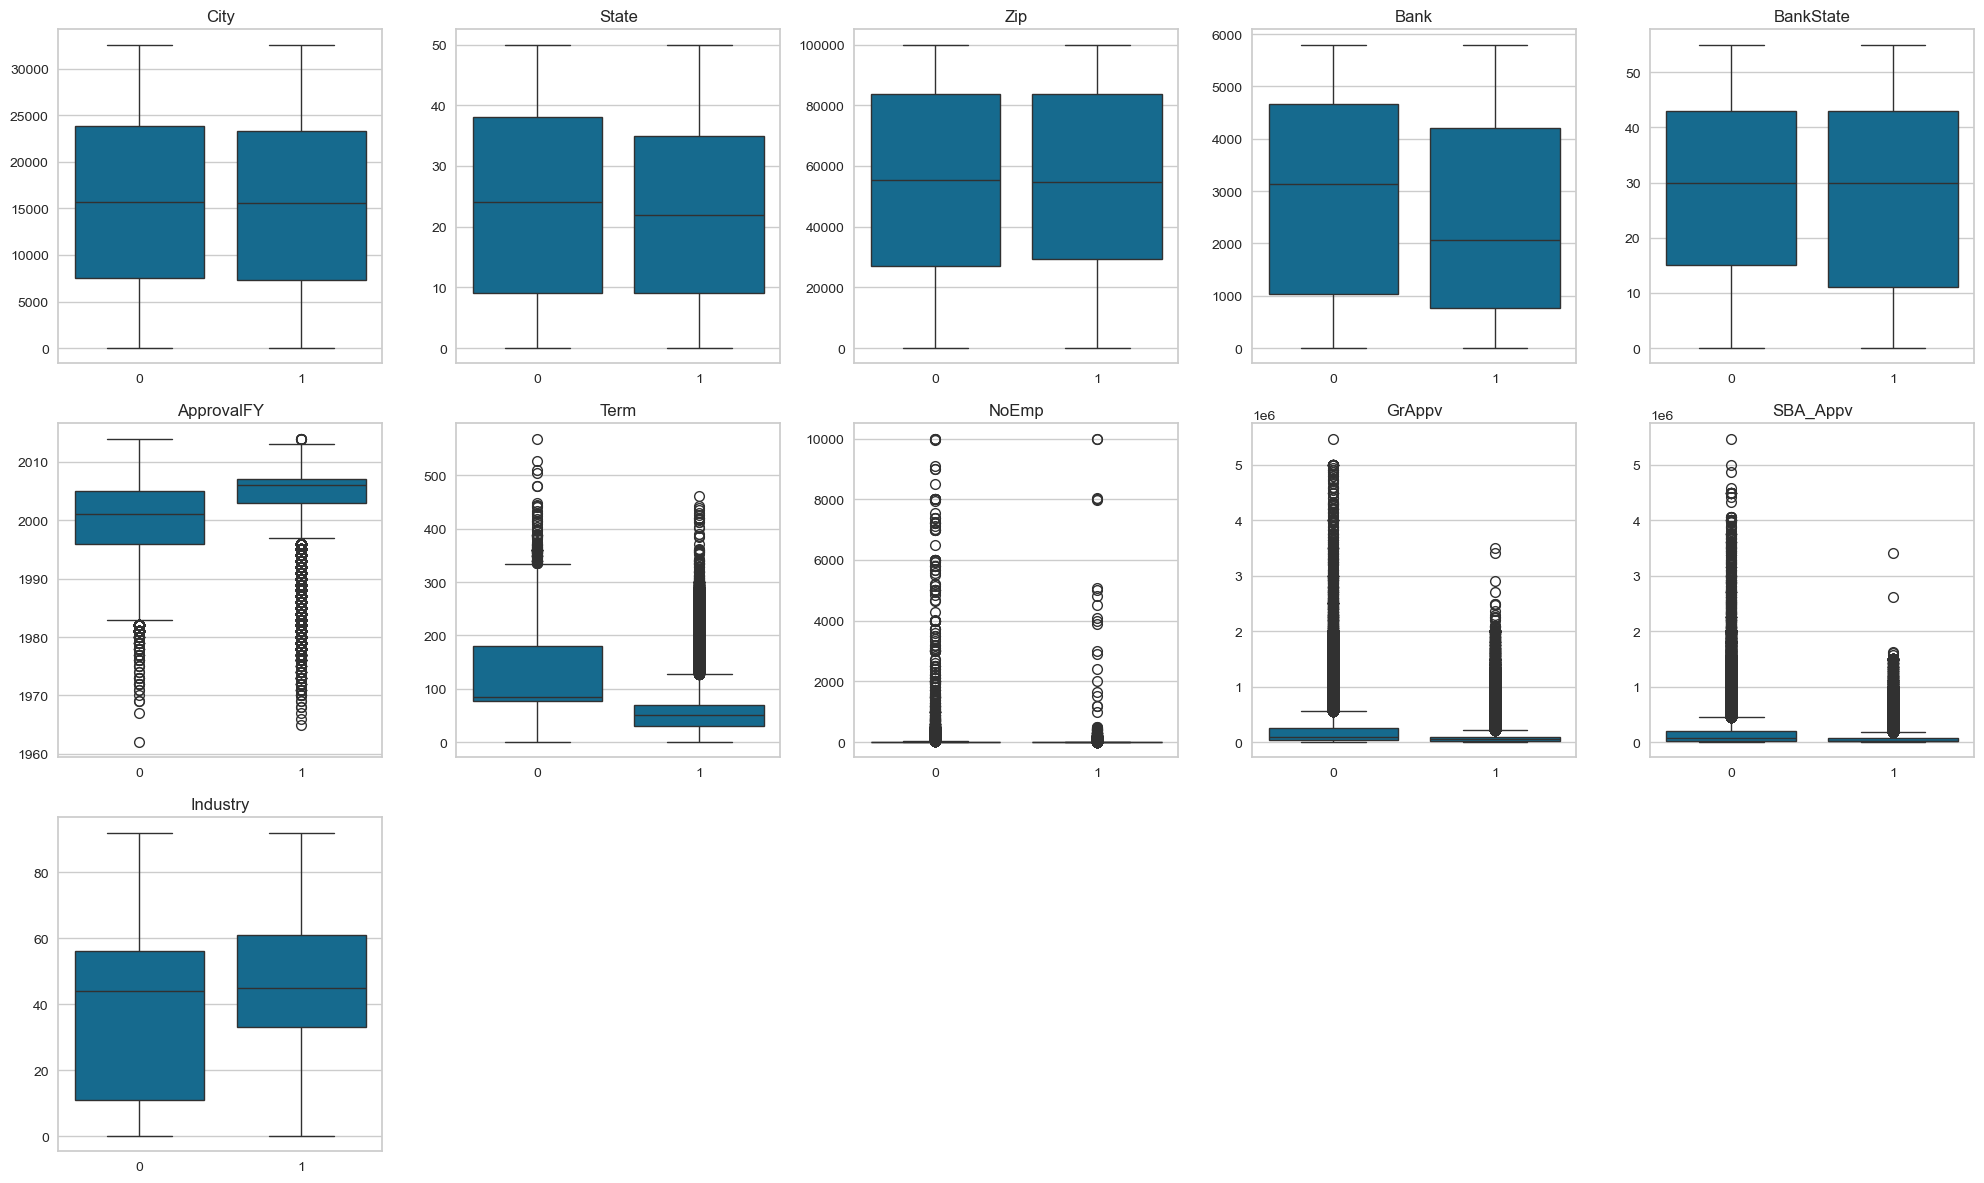

In [16]:
# Identify numerical variables
numerical_vars = [col for col in data.columns 
                  if data[col].dtype in ['int64', 'float64'] 
                  and col != 'Default' and data[col].nunique() > 10]

# Layout settings
plots_per_row = 5
total = len(numerical_vars)
rows = math.ceil(total / plots_per_row)

# Create subplots
fig, axes = plt.subplots(rows, plots_per_row, figsize=(plots_per_row * 4, rows * 4))
axes = axes.flatten()

for i, var in enumerate(numerical_vars):
    sns.boxplot(x='Default', y=var, data=data, ax=axes[i])
    axes[i].set_title(var)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Remove unused plots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [17]:
ttest_results = []

for var in numerical_vars:
    group0 = data[data['Default'] == 0][var].dropna()
    group1 = data[data['Default'] == 1][var].dropna()
    t_stat, p_val = ttest_ind(group0, group1, equal_var=False)
    ttest_results.append((var, p_val))

# Format into DataFrame with readable p-values
ttest_df = pd.DataFrame(ttest_results, columns=['Variable', 'p_value'])
ttest_df['p_value'] = ttest_df['p_value'].apply(lambda x: f"{x:.6f}")
ttest_df = ttest_df.sort_values(by='p_value')
print(ttest_df)


      Variable   p_value
0         City  0.000000
1        State  0.000000
3         Bank  0.000000
4    BankState  0.000000
5   ApprovalFY  0.000000
6         Term  0.000000
7        NoEmp  0.000000
8       GrAppv  0.000000
9     SBA_Appv  0.000000
10    Industry  0.000000
2          Zip  0.003154


Again, most variables,showed statistically significant associations with default status (p < 0.01). `Name`, however, showed no significant relationship (p = 0.18) and may be considered for exclusion or aggregation.


#### State vs Default

Chi-square statistic: 11146.31, p-value: 0.0000


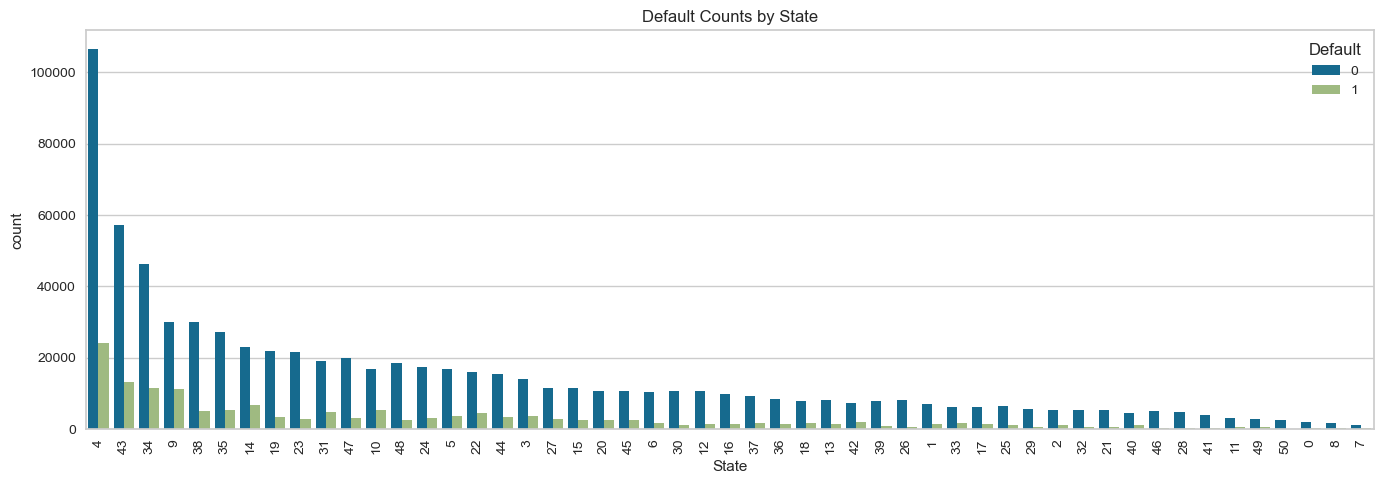

In [18]:
# Create a contingency table
contingency = pd.crosstab(data['State'], data['Default'])

# Run Chi-square test
chi2, p, dof, ex = chi2_contingency(contingency)

print(f"Chi-square statistic: {chi2:.2f}, p-value: {p:.4f}")

# Visualise the distribution
plt.figure(figsize=(14,5))
sns.countplot(data=data, x='State', hue='Default', order=data['State'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Default Counts by State")
plt.tight_layout()
plt.savefig("state_defauly.png", dpi=300)  # Optional
plt.show()


Although the Chi-square test indicates a statistically significant association between `State` and loan default (p < 0.001),
the variable has high cardinality and lacks economic interpretability. The observed differences in default rates across states
may reflect regional lending practices, business density, or reporting inconsistencies, rather than genuine predictive value.

Given its limited explanatory power, poor generalisability, and risk of overfitting, we opt to exclude 'State' from the final
feature set despite its statistical significance. This balances model interpretability, simplicity, and robustness.


#### Bank vs Default

Chi-square statistic: 101954.67, p-value: 0.0000


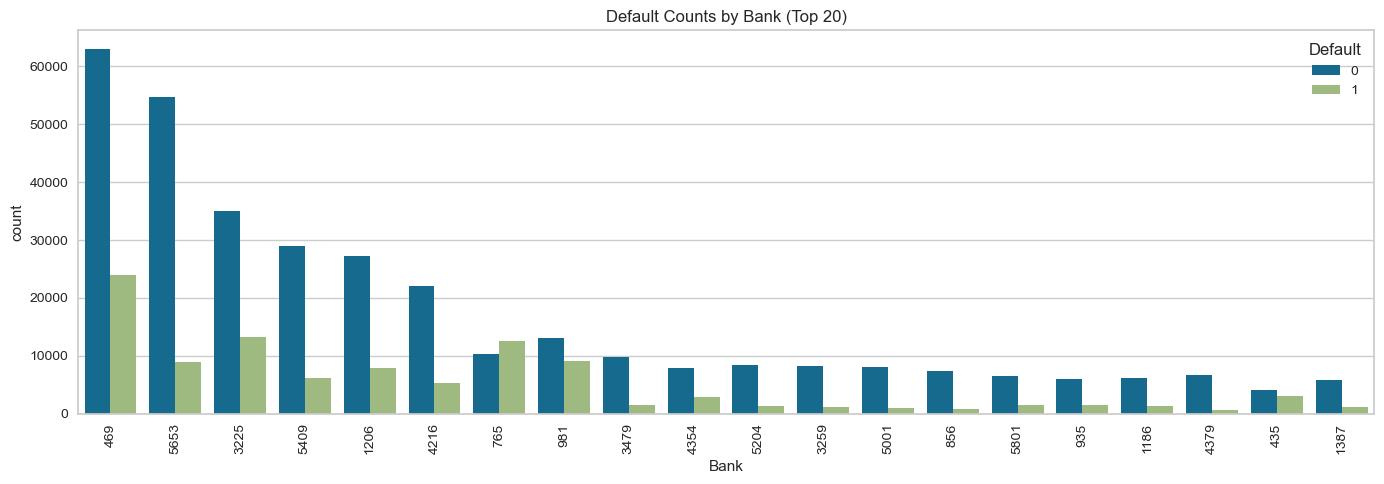

In [19]:
# Create a contingency table
contingency = pd.crosstab(data['Bank'], data['Default'])

# Run Chi-square test
chi2, p, dof, ex = chi2_contingency(contingency)

print(f"Chi-square statistic: {chi2:.2f}, p-value: {p:.4f}")

# Visualise the distribution (Top 20 banks by frequency)
top_banks = data['Bank'].value_counts().nlargest(20).index
plt.figure(figsize=(14,5))
sns.countplot(data=data[data['Bank'].isin(top_banks)], x='Bank', hue='Default', order=top_banks)
plt.xticks(rotation=90)
plt.title("Default Counts by Bank (Top 20)")
plt.tight_layout()
plt.show()


Similarly, while the Chi-square test shows a statistically significant relationship between `Bank` and loan default (p < 0.001),
this variable exhibits extremely high cardinality, 15,000 unique values,  with limited interpretability. Including 'Bank' could introduce
noise, risk overfitting, and reduce generalisability to future datasets containing new or rare bank names.

As such, despite statistical significance, `Bank` is excluded from the final feature set in favour of more general,
structured predictors with consistent predictive value.


#### City vs Default

Chi-square statistic: 62276.53, p-value: 0.0000


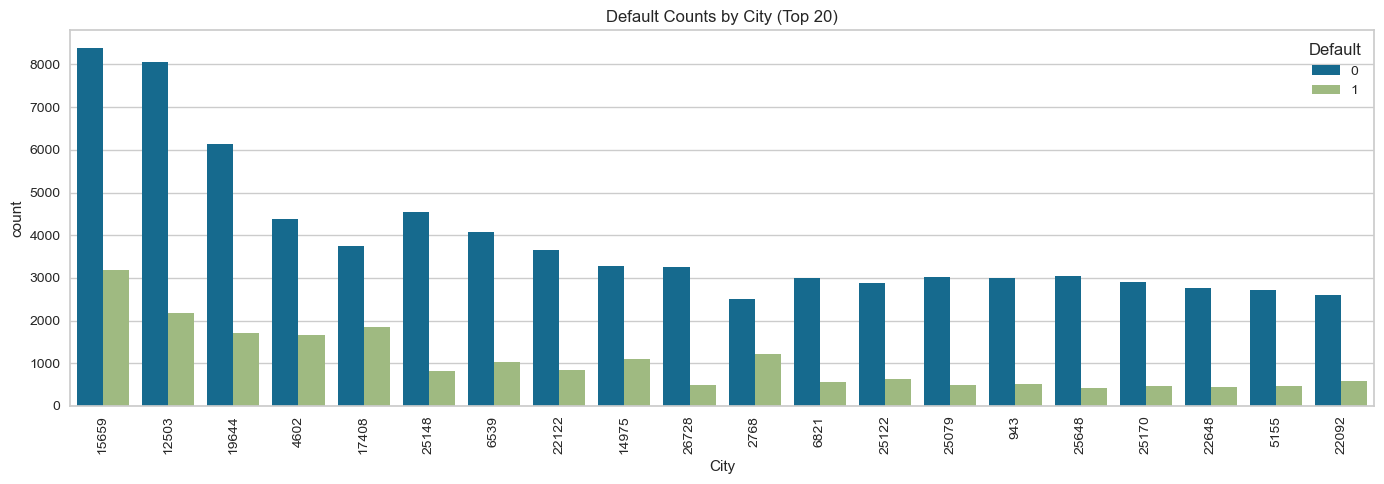

In [20]:
# Create a contingency table
contingency = pd.crosstab(data['City'], data['Default'])

# Run Chi-square test
chi2, p, dof, ex = chi2_contingency(contingency)

print(f"Chi-square statistic: {chi2:.2f}, p-value: {p:.4f}")

# Visualise the distribution (Top 20 cities by frequency)
top_cities = data['City'].value_counts().nlargest(20).index
plt.figure(figsize=(14,5))
sns.countplot(data=data[data['City'].isin(top_cities)], x='City', hue='Default', order=top_cities)
plt.xticks(rotation=90)
plt.title("Default Counts by City (Top 20)")
plt.tight_layout()
plt.show()


The Chi-square test confirms a statistically significant relationship between `City` and default status (p < 0.001).
However, the variable contains an extremely large number of unique categories, most of which have few observations.
This high cardinality, combined with low interpretability and generalisability, makes `City` a poor candidate for inclusion.

To avoid overfitting and ensure model simplicity, we exclude `City` from the final feature set despite statistical significance.


#### Zip vs Default

Chi-square statistic: 69906.92, p-value: 0.0000


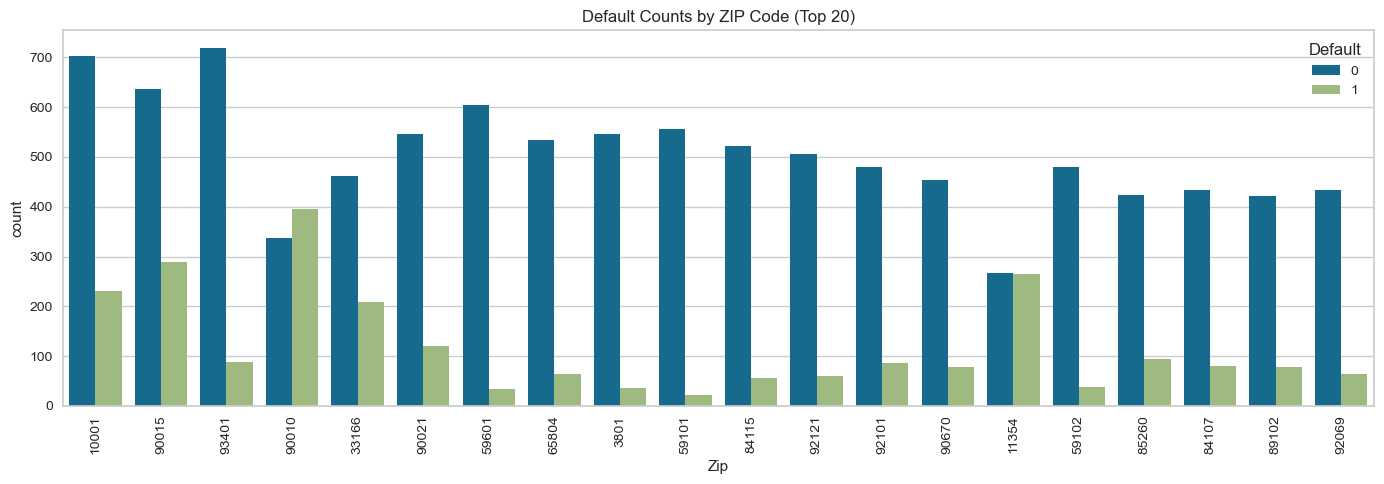

In [21]:
# Create a contingency table
contingency = pd.crosstab(data['Zip'], data['Default'])

# Run Chi-square test
chi2, p, dof, ex = chi2_contingency(contingency)

print(f"Chi-square statistic: {chi2:.2f}, p-value: {p:.4f}")

# Visualise the distribution (Top 20 ZIP codes by frequency)
top_zips = data['Zip'].value_counts().nlargest(20).index
plt.figure(figsize=(14,5))
sns.countplot(data=data[data['Zip'].isin(top_zips)], x='Zip', hue='Default', order=top_zips)
plt.xticks(rotation=90)
plt.title("Default Counts by ZIP Code (Top 20)")
plt.tight_layout()
plt.show()


Although the Chi-square test indicates a statistically significant relationship between `Zip` and default status (p < 0.001),
the variable exhibits very high cardinality with many rarely occurring values. Its predictive power is likely limited to

Given its overlap with `City` and `State`, poor generalisability, and limited interpretability, we exclude `Zip` from the
final model to reduce dimensionality and enhance model robustness.


#### Minority vs Default

Chi-square statistic: 550782.31, p-value: 0.0000


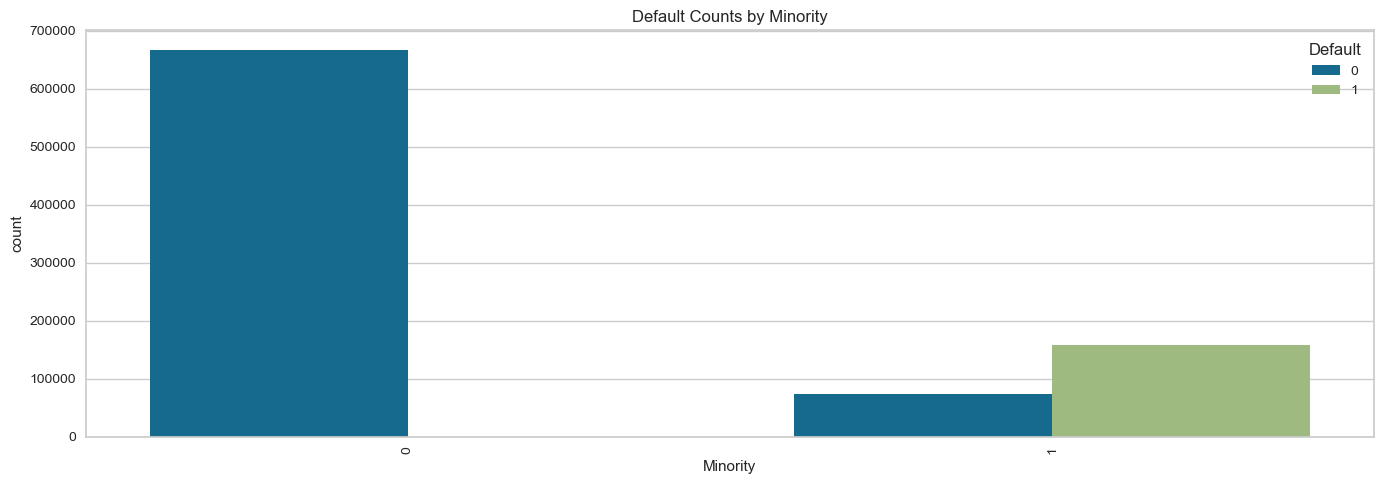

In [22]:
# Create a contingency table
contingency = pd.crosstab(data['Minority'], data['Default'])

# Run Chi-square test
chi2, p, dof, ex = chi2_contingency(contingency)

print(f"Chi-square statistic: {chi2:.2f}, p-value: {p:.4f}")

# Visualise the distribution (Top 20 ZIP codes by frequency)
top_zips = data['Minority'].value_counts().nlargest(20).index
plt.figure(figsize=(14,5))
sns.countplot(data=data[data['Minority'].isin(top_zips)], x='Minority', hue='Default', order=top_zips)
plt.xticks(rotation=90)
plt.title("Default Counts by Minority")
plt.tight_layout()
plt.savefig("minority_count.png", dpi=300)  # Optional

plt.show()


Although the Chi-square test indicates a statistically significant relationship between `Minority` and default status (p < 0.001),
the variable involves large ethical concerns.

Consideration of this variable could introduce ethnicity bias into the model, which could have ethical and compliance implications and therefore this variable may not be considered for model construction and removed from the data set.

We have therefore removed the above variables on a qualitative basis before exploring the data and charts.

In [23]:
# Drop redundant or high-cardinality columns
data.drop(columns=[
    'City', 'State', 'Zip',
    'Bank', 'BankState', 'Minority'
], inplace=True)

In [24]:
data.head()

ApprovalDate  ApprovalFY  Term  NoEmp  NewExist  RevLineCr  LowDoc  \
0   1997-02-28        1997    84      4       1.0        0.0     1.0   
1   1997-02-28        1997    60      2       1.0        0.0     1.0   
2   1997-02-28        1997   180      7       0.0        0.0     0.0   
3   1997-02-28        1997    60      2       0.0        0.0     1.0   
4   1997-02-28        1997   240     14       0.0        0.0     0.0   

   MIS_Status  GrAppv  SBA_Appv  Industry  Default  UrbanRural_2.0  \
0           1   60000     48000        45        0           False   
1           1   40000     32000        72        0           False   
2           1  287000    215250        62        0           False   
3           1   35000     28000         0        0           False   
4           1  229000    229000         0        0           False   

   HasFranchise  NAICS_Sector_11  NAICS_Sector_21  NAICS_Sector_22  \
0             0            False            False            False   
1             0            False            False            False   
2             0            False            False            False   
3             0            False            False            False   
4             0            False            False            False   

   NAICS_Sector_23  NAICS_Sector_31  NAICS_Sector_32  NAICS_Sector_33  \
0            False            False            False            False   
1            False            False            False            False   
2            False            False            False            False   
3            False            False            False            False   
4            False            False            False            False   

   NAICS_Sector_42  NAICS_Sector_44  NAICS_Sector_45  NAICS_Sector_48  \
0            False            False             True            False   
1            False            False            False            False   
2            False            False            False            False   
3            False            False            False            False   
4            False            False            False            False   

   NAICS_Sector_49  NAICS_Sector_51  NAICS_Sector_52  NAICS_Sector_53  \
0            False            False            False            False   
1            False            False            False            False   
2            False            False            False            False   
3            False            False            False            False   
4            False            False            False            False   

   NAICS_Sector_54  NAICS_Sector_55  NAICS_Sector_56  NAICS_Sector_61  \
0            False            False            False            False   
1            False            False            False            False   
2            False            False            False            False   
3            False            False            False            False   
4            False            False            False            False   

   NAICS_Sector_62  NAICS_Sector_71  NAICS_Sector_72  NAICS_Sector_81  \
0            False            False            False            False   
1            False            False             True            False   
2             True            False            False            False   
3            False            False            False            False   
4            False            False            False            False   

   NAICS_Sector_92  
0            False  
1            False  
2            False  
3            False  
4            False

#### Drop Industry

In [25]:
print("Unique values in Industry:\n", data['Industry'].unique())
print("\nValue counts:\n", data['Industry'].value_counts(dropna=False))

Unique values in Industry:
 [45 72 62  0 33 81 23 44 42 61 53 54 31 51 71 52 21 32 56 48 11 92 22 49
 55]

Value counts:
 Industry
0     201948
44     84737
81     72618
54     68170
72     67600
23     66646
62     55366
42     48743
45     42514
33     38284
56     32685
48     20310
32     17936
71     14640
53     13632
31     11809
51     11379
52      9496
11      9005
61      6425
49      2221
21      1851
22       663
55       257
92       229
Name: count, dtype: int64


The `Industry` variable mirrors the information already captured in the extracted `NAICS_Sector` feature.
Additionally, it contains a large number of entries coded as '0', which likely represent missing or undefined sectors.
To avoid redundancy and multicollinearity, we exclude 'Industry' and retain the more structured and interpretable
`NAICS_Sector` one-hot encoded features.

In [26]:
data.drop(columns=['Industry'], inplace=True)

#### Drop MIS_Status
Now redundant, since `Default` replaces it.

In [27]:
data.drop(columns=['MIS_Status'], inplace=True)

#### Drop Approval Date

Contains same information as Approval year

In [28]:
data.drop(columns=['ApprovalDate'], inplace=True)

### Check Missing Values

In [29]:
# Check missing values per column
missing_summary = data.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)

# Display missing value summary
print("Missing values by column:\n")
print(missing_summary)


Missing values by column:

RevLineCr    275021
LowDoc         3439
NewExist       1035
dtype: int64


#### Compare Summary Stats (missing vs non-missing)

In [30]:
# Split data into missing vs non-missing for both columns
missing_revlinecr = data[data['RevLineCr'].isnull()]
non_missing_revlinecr = data[data['RevLineCr'].notnull()]

missing_newexist = data[data['NewExist'].isnull()]
non_missing_newexist = data[data['NewExist'].notnull()]

# Print comparisons for RevLineCr
print("=== RevLineCr Missingness Analysis ===")
print("GrAppv (mean):")
print("  Missing     :", missing_revlinecr['GrAppv'].mean())
print("  Not Missing :", non_missing_revlinecr['GrAppv'].mean())

print("\nDefault Rate:")
print("  Missing     :", missing_revlinecr['Default'].mean())
print("  Not Missing :", non_missing_revlinecr['Default'].mean())

print("\n" + "="*40 + "\n")

# Print comparisons for NewExist
print("=== NewExist Missingness Analysis ===")
print("GrAppv (mean):")
print("  Missing     :", missing_newexist['GrAppv'].mean())
print("  Not Missing :", non_missing_newexist['GrAppv'].mean())

print("\nDefault Rate:")
print("  Missing     :", missing_newexist['Default'].mean())
print("  Not Missing :", non_missing_newexist['Default'].mean())


=== RevLineCr Missingness Analysis ===
GrAppv (mean):
  Missing     : 240888.54266037868
  Not Missing : 171447.5441397244

Default Rate:
  Missing     : 0.16411110424294872
  Not Missing : 0.18075985791717603


=== NewExist Missingness Analysis ===
GrAppv (mean):
  Missing     : 321835.35265700484
  Not Missing : 192538.14634980052

Default Rate:
  Missing     : 0.06376811594202898
  Not Missing : 0.17579657265270357


Loans with missing `NewExist` values are much larger in amount. They default far less frequently. This suggests these loans are **not random** and they behave very differently. We will not drop these rows outright..

Similarly GrAppv is higher on average for loans where `RevLineCr` is missing amd default Rate is slightly lower in the missing group. This suggests that missing `RevLineCr` may not be missing completely at random, it could be **systematic** (e.g. due to loan size, product type, or data collection). 

Dropping these rows would remove structurally different observations and introduce bias. Instead, we impute missing values using the mode
and add a binary flag to preserve information about their original missingness.

 #### Create a *"Missing"* flag

In [31]:
# Create missingness flags
data['RevLineCr_missing'] = data['RevLineCr'].isna().astype(int)
data['LowDoc_missing'] = data['LowDoc'].isna().astype(int)

# Impute missing with mode (most common value)
data['RevLineCr'] = data['RevLineCr'].fillna(data['RevLineCr'].mode()[0]).astype(int)
data['LowDoc'] = data['LowDoc'].fillna(data['LowDoc'].mode()[0]).astype(int)

# Create missing flag
data['NewExist_missing'] = data['NewExist'].isna().astype(int)

# Impute with mode
data['NewExist'] = data['NewExist'].fillna(data['NewExist'].mode()[0]).astype(int)

- **Mode Imputation**: For each column, we identified the mode and used it to fill missing values. This approach is simple and commonly used for categorical variables.
- **Missingness Flags**: Before imputing, we created binary indicators (e.g., `RevLineCr_missing`) to flag whether a value was originally missing (`1`) or not (`0`). This allows the model to learn whether the absence of data carries predictive information.
- **Rationale**: Exploratory analysis showed that missing values in these columns were not random, they were associated with significantly different loan sizes and default rates. By retaining a missingness flag, we preserve this potential signal while avoiding biased deletion of structurally different loans.

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 38 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   ApprovalFY         899164 non-null  int64
 1   Term               899164 non-null  int64
 2   NoEmp              899164 non-null  int64
 3   NewExist           899164 non-null  int32
 4   RevLineCr          899164 non-null  int32
 5   LowDoc             899164 non-null  int32
 6   GrAppv             899164 non-null  int64
 7   SBA_Appv           899164 non-null  int64
 8   Default            899164 non-null  int64
 9   UrbanRural_2.0     899164 non-null  bool 
 10  HasFranchise       899164 non-null  int64
 11  NAICS_Sector_11    899164 non-null  bool 
 12  NAICS_Sector_21    899164 non-null  bool 
 13  NAICS_Sector_22    899164 non-null  bool 
 14  NAICS_Sector_23    899164 non-null  bool 
 15  NAICS_Sector_31    899164 non-null  bool 
 16  NAICS_Sector_32    899164 non-null  bo

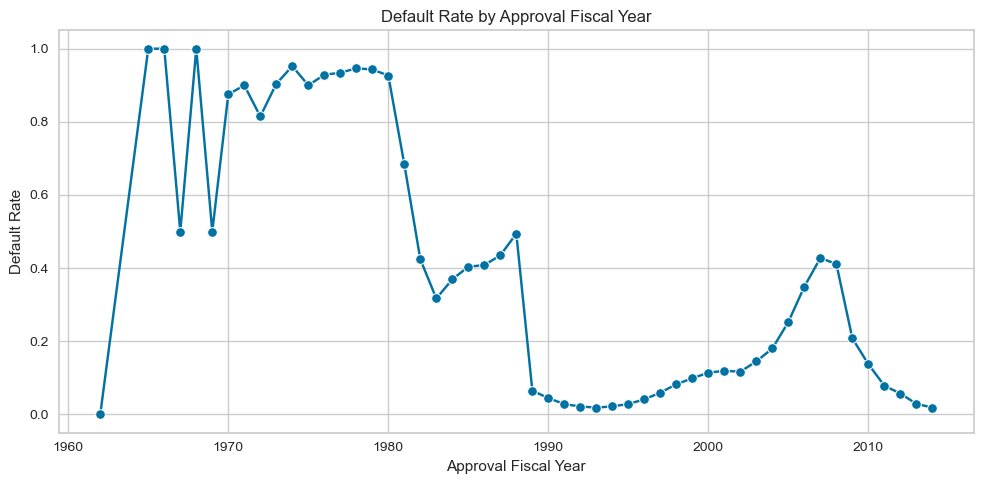

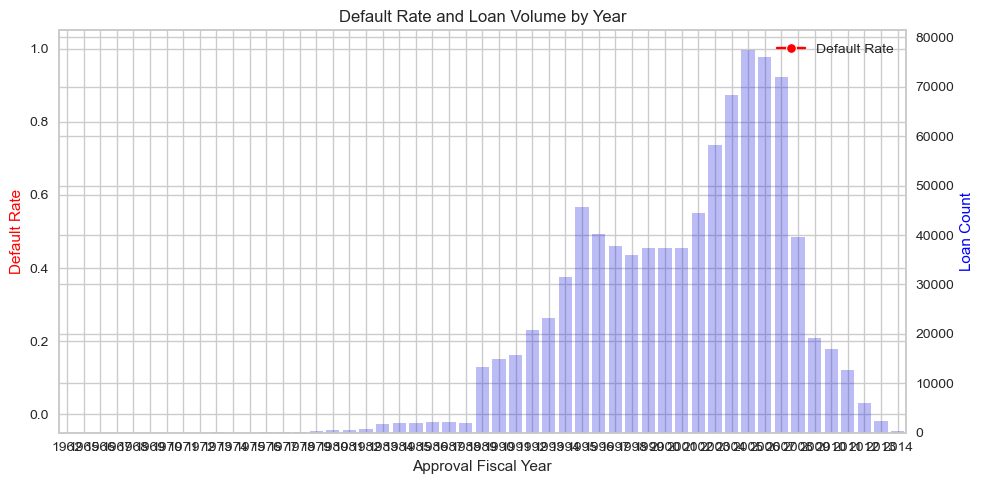

In [33]:
# Group by approval year and compute default rate
yearly_default = data.groupby('ApprovalFY')['Default'].agg(['mean', 'count']).reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=yearly_default, x='ApprovalFY', y='mean', marker='o')
plt.title('Default Rate by Approval Fiscal Year')
plt.xlabel('Approval Fiscal Year')
plt.ylabel('Default Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Add loan counts on a secondary axis
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

sns.lineplot(data=yearly_default, x='ApprovalFY', y='mean', marker='o', ax=ax1, color='red', label='Default Rate')
sns.barplot(data=yearly_default, x='ApprovalFY', y='count', alpha=0.3, ax=ax2, color='blue')

ax1.set_xlabel('Approval Fiscal Year')
ax1.set_ylabel('Default Rate', color='red')
ax2.set_ylabel('Loan Count', color='blue')
ax1.set_title('Default Rate and Loan Volume by Year')
ax1.grid(True)
plt.tight_layout()
plt.show()


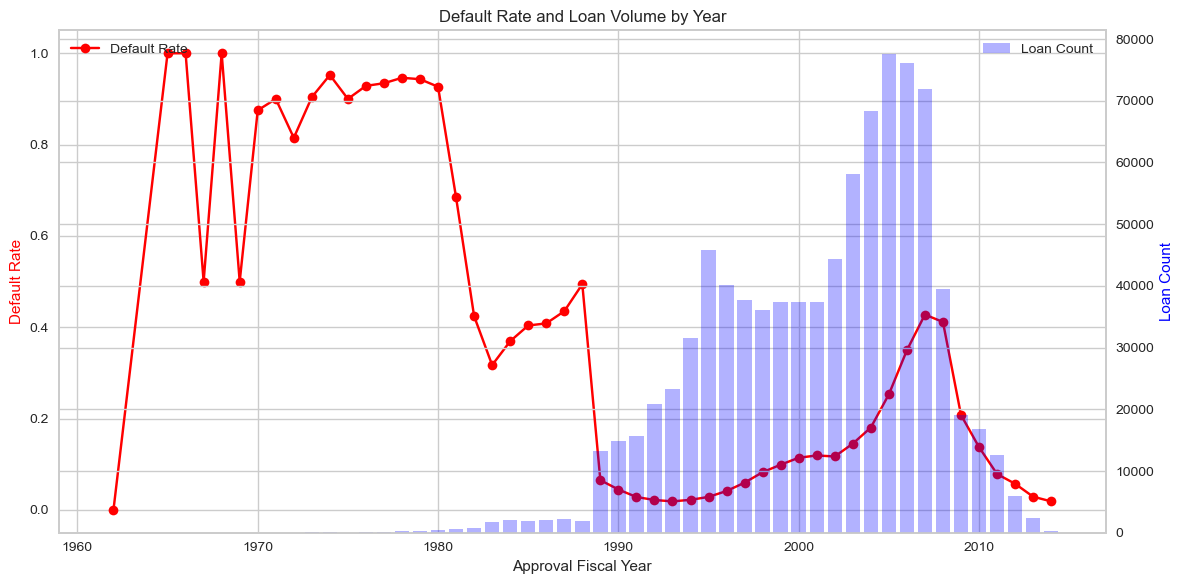

In [34]:
# Create figure and dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Bar chart: Loan count on right axis
ax2.bar(yearly_default['ApprovalFY'], yearly_default['count'], alpha=0.3, color='blue', label='Loan Count')

# Line chart: Default rate on left axis
ax1.plot(yearly_default['ApprovalFY'], yearly_default['mean'], color='red', marker='o', label='Default Rate')

# Labels and title
ax1.set_xlabel('Approval Fiscal Year')
ax1.set_ylabel('Default Rate', color='red')
ax2.set_ylabel('Loan Count', color='blue')
ax1.set_title('Default Rate and Loan Volume by Year')

# Format x-axis: ticks every 10 years

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Grid and layout
ax1.grid(True)
plt.tight_layout()
plt.savefig("default_years.png", dpi=300)  # Optional
plt.show()

Default rates fluctuated heavily before 1985 due to limited loan volume and potential data inconsistencies. From the late 1980s onward, default rates stabilised and began reflecting broader macroeconomic cycles. Notably, default risk spiked during the 2008 financial crisis and has since declined. Given the volatility and sparsity in earlier years, we focus our analysis and model training on loans approved from 1985 onward.”

In [35]:
data = data.drop(columns=['ApprovalFY'], errors='ignore')

Although `ApprovalFY` showed a strong relationship with default risk in exploratory analysis, we excluded it from the final model to avoid overfitting to historical patterns. Including time-based features can cause a model to “memorise” crisis-era defaults or recent lending trends, reducing its ability to generalise to future approvals. 

### Exploratory

#### GrAppv vs SBA_Appv

`GrAppv`: Gross Amount Approved

`SBA_Appv`: SBA's guaranteed portion of the loan

These variables are closely related:

`SBA_Appv` ≤ `GrAppv`

The difference is the portion the SBA guarantees (like insurance coverage)

Keeping both is useful:

`SBA_Appv` / `GrAppv` = coverage ratio, which could be an insightful feature

In [36]:
data['SBA_Coverage_Ratio'] = data['SBA_Appv'] / data['GrAppv']

This could reveal:

Whether higher guaranteed coverage leads to more or fewer defaults

How lenders behave under different SBA backing levels

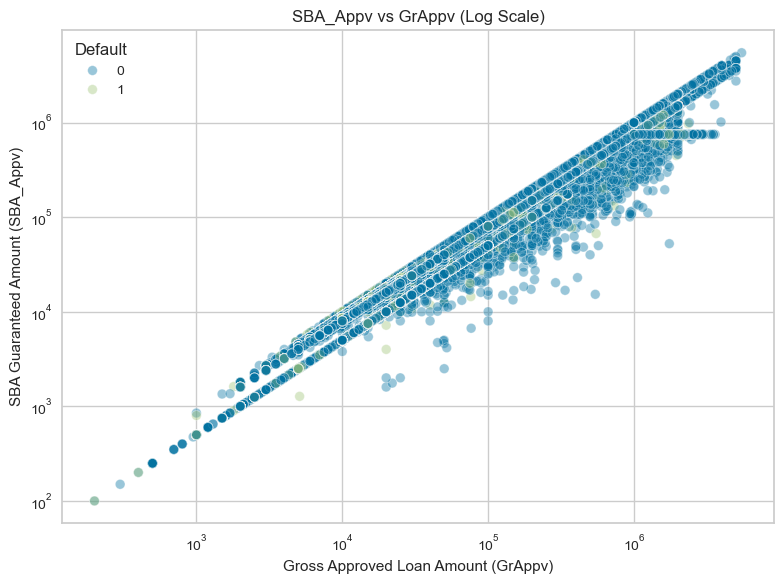

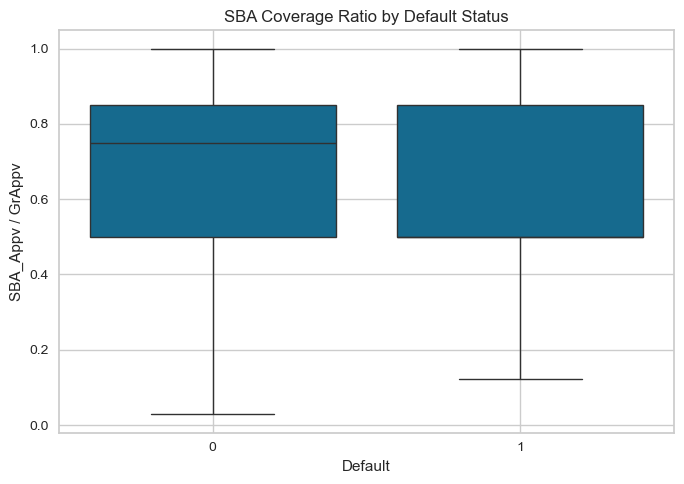

In [37]:
# Scatterplot with log scale to handle large values
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='GrAppv', y='SBA_Appv', hue='Default', alpha=0.4)
plt.xscale('log')
plt.yscale('log')
plt.title('SBA_Appv vs GrAppv (Log Scale)')
plt.xlabel('Gross Approved Loan Amount (GrAppv)')
plt.ylabel('SBA Guaranteed Amount (SBA_Appv)')
plt.legend(title='Default')
plt.grid(True)
plt.tight_layout()
plt.show()

# Boxplot of SBA coverage ratio by default
plt.figure(figsize=(7, 5))
sns.boxplot(data=data, x='Default', y='SBA_Coverage_Ratio')
plt.title('SBA Coverage Ratio by Default Status')
plt.xlabel('Default')
plt.ylabel('SBA_Appv / GrAppv')
plt.grid(True)
plt.tight_layout()
plt.show()


We observe a strong linear relationship between GrAppv and SBA_Appv, confirming that SBA guarantees are issued as fixed proportions of the approved loan amount. Most loans cluster along well-defined guarantee tiers, such as 75% or 85%. However, the boxplot of the SBA_Coverage_Ratio reveals that defaulted loans tend to have slightly higher SBA coverage on average and show greater variability. This may indicate that higher-risk loans are more likely to receive stronger SBA backing, or that SBA-guaranteed lending does not fully mitigate default risk.

In [38]:
# Group by Default status and calculate average SBA coverage ratio
average_coverage_by_default = (
    data.groupby('Default')['SBA_Coverage_Ratio']
    .mean()
    .reset_index()
    .rename(columns={'SBA_Coverage_Ratio': 'Average_SBA_Coverage_Ratio'})
)

# Display result
print(average_coverage_by_default)


   Default  Average_SBA_Coverage_Ratio
0        0                    0.723388
1        1                    0.643675


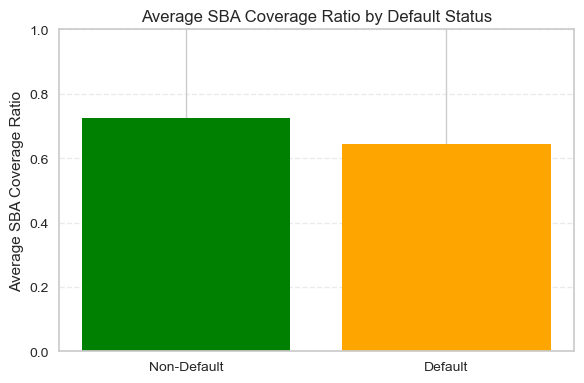

In [39]:
plt.figure(figsize=(6, 4))
plt.bar(
    average_coverage_by_default['Default'].map({0: 'Non-Default', 1: 'Default'}),
    average_coverage_by_default['Average_SBA_Coverage_Ratio'],
    color=['green', 'orange']
)
plt.ylabel('Average SBA Coverage Ratio')
plt.title('Average SBA Coverage Ratio by Default Status')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.savefig("sba_coverage.png", dpi=300)  # Optional
plt.tight_layout()

Loans that did **not default** had a higher average SBA guarantee, suggesting that **greater SBA coverage is associated with lower default risk**. This may reflect better loan screening, stricter approval processes, or stronger borrower profiles for more heavily guaranteed loans.


#### Bins

In [40]:
# Term Bin: based on loan term in months
data['TermBin'] = pd.cut(
    data['Term'],
    bins=[0, 36, 60, 120, np.inf],
    labels=['≤3yr', '3–5yr', '5–10yr', '10yr+']
)

# NoEmp Bin: size of business by employees
data['NoEmpBin'] = pd.cut(
    data['NoEmp'],
    bins=[-1, 1, 5, 20, 50, 100, 500, np.inf],
    labels=['0–1', '2–5', '6–20', '21–50', '51–100', '101–500', '500+']
)

# Loan Size Bin: based on DisbursementGross using quantiles
data['LoanSizeBin'] = pd.qcut(
    data['GrAppv'],
    q=5,
    labels=['Very Small', 'Small', 'Medium', 'Large', 'Very Large']
)

# View the result
data[['Term', 'TermBin', 'NoEmp', 'NoEmpBin', 'GrAppv', 'LoanSizeBin']].head()


Term TermBin  NoEmp NoEmpBin  GrAppv LoanSizeBin
0    84  5–10yr      4      2–5   60000      Medium
1    60   3–5yr      2      2–5   40000       Small
2   180   10yr+      7     6–20  287000  Very Large
3    60   3–5yr      2      2–5   35000       Small
4   240   10yr+     14     6–20  229000       Large

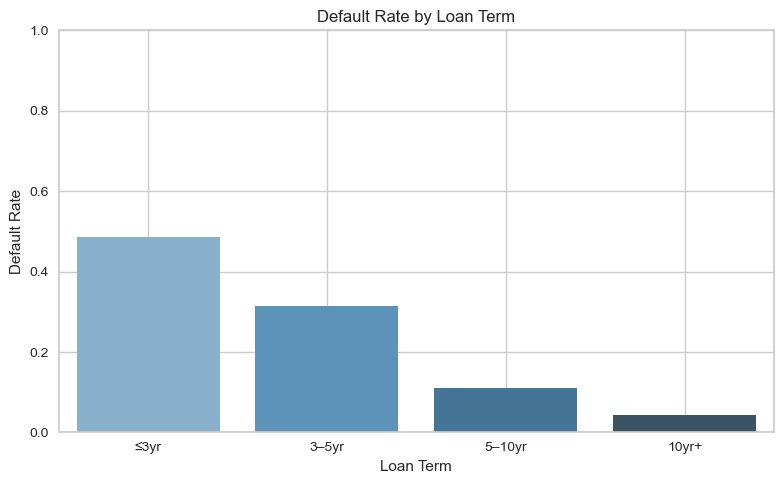

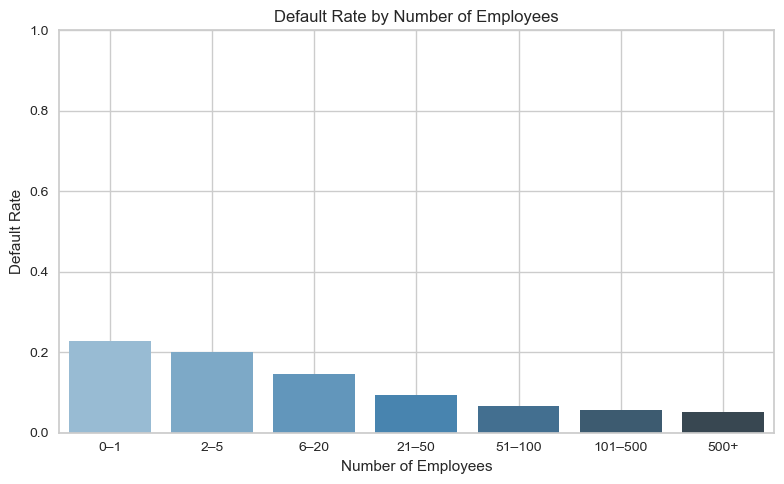

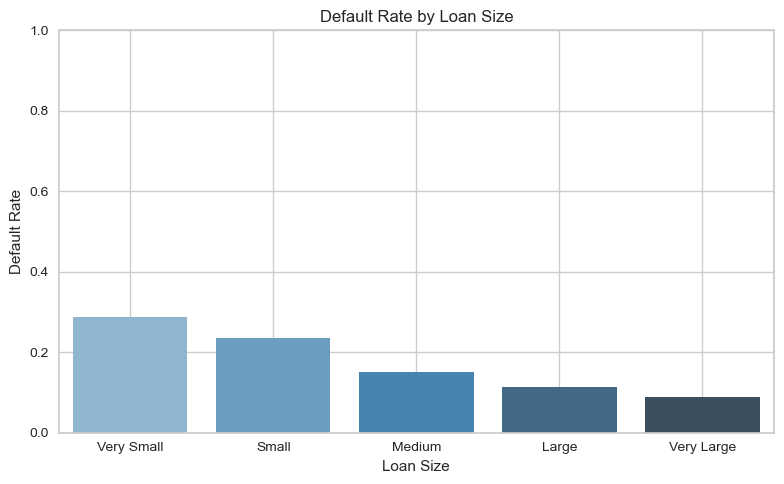

In [41]:
# Function to plot default rates by bin
def plot_default_rate_by_bin(data, bin_col, title):
    bin_stats = data.groupby(bin_col)['Default'].mean().reset_index()
    plt.figure(figsize=(8, 5))
    sns.barplot(data=bin_stats, x=bin_col, y='Default', palette='Blues_d')
    plt.title(f'Default Rate by {title}')
    plt.ylabel('Default Rate')
    plt.xlabel(title)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function for each binned variable
plot_default_rate_by_bin(data, 'TermBin', 'Loan Term')
plot_default_rate_by_bin(data, 'NoEmpBin', 'Number of Employees')
plot_default_rate_by_bin(data, 'LoanSizeBin', 'Loan Size')


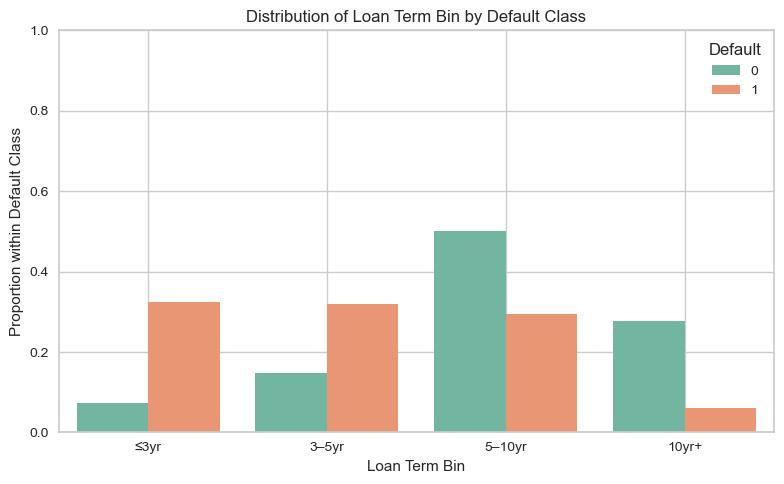

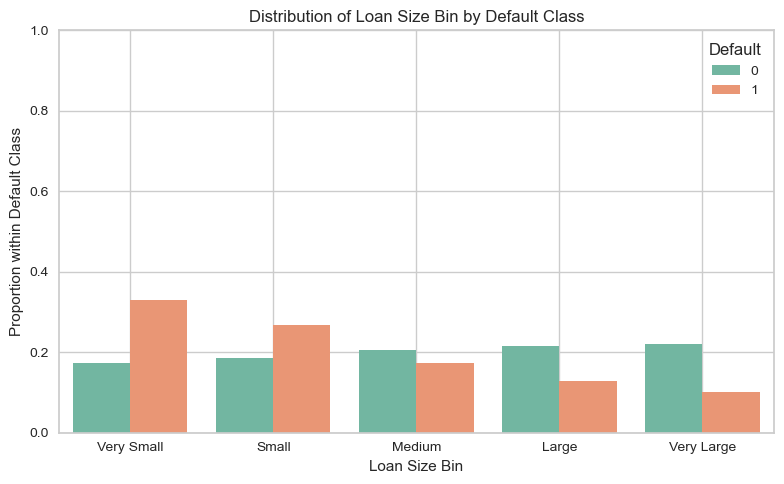

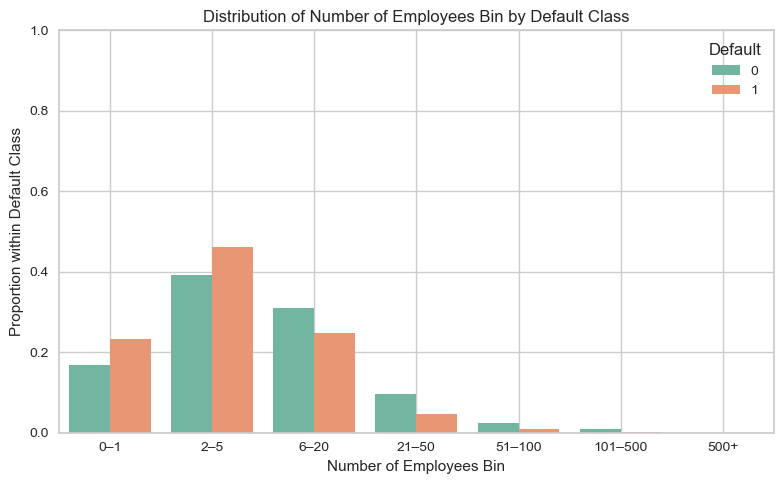

In [42]:
# Function to plot bin distributions split by Default class
def plot_categorical_dist_by_default(data, col, title):
    dist = (
        data.groupby('Default')[col]
        .value_counts(normalize=True)
        .rename("Proportion")
        .reset_index()
    )

    plt.figure(figsize=(8, 5))
    sns.barplot(data=dist, x=col, y='Proportion', hue='Default', palette='Set2')
    plt.title(f'Distribution of {title} by Default Class')
    plt.ylabel('Proportion within Default Class')
    plt.xlabel(title)
    plt.ylim(0, 1)
    plt.legend(title='Default')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("term.png", dpi=300)  # Optional
    plt.show()

# Apply to your bin columns
plot_categorical_dist_by_default(data, 'TermBin', 'Loan Term Bin')
plot_categorical_dist_by_default(data, 'LoanSizeBin', 'Loan Size Bin')
plot_categorical_dist_by_default(data, 'NoEmpBin', 'Number of Employees Bin')


#### 1. Loan Term (`TermBin`)
- Loans with shorter terms (`≤3 years` and `3–5 years`) show the highest default rates up to 50% in some segments.
- As loan terms increase, the default rate declines steadily. Loans over `10 years` have the lowest risk, likely due to stronger screening or government backing.
- Defaulted loans are clearly overrepresented in shorter bins, while non-defaults dominate longer durations.

#### 2. Number of Employees (`NoEmpBin`)
- The smallest firms (`0–1` and `2–5` employees) have the highest default rates, suggesting these loans may go to sole traders or newer startups.
- As firm size increases, default rates drop consistently, firms with `100+ employees` show very low risk.
- Defaulted loans are highly concentrated in small-size bins, with larger firms almost absent from defaults.

#### 3. Loan Size (`LoanSizeBin`)
- Smaller loans (`Very Small`, `Small`) exhibit elevated default rates, likely reflecting riskier lending or weaker collateral.
- Default rates decline progressively as loan size increases, with `Very Large` loans showing the lowest default risk.
- Non-defaulted loans are disproportionately present in larger bins, which may reflect better underwriting or borrower quality.

### Takeaway
These engineered features, `TermBin`, `NoEmpBin`, and `LoanSizeBin`, consistently separate borrowers into distinct risk profiles. They show:
- Shorter terms, smaller firms, and smaller loan amounts are associated with higher default risk
- These binned features are highly informative and should be included in predictive modelling, either directly or via one-hot encoding

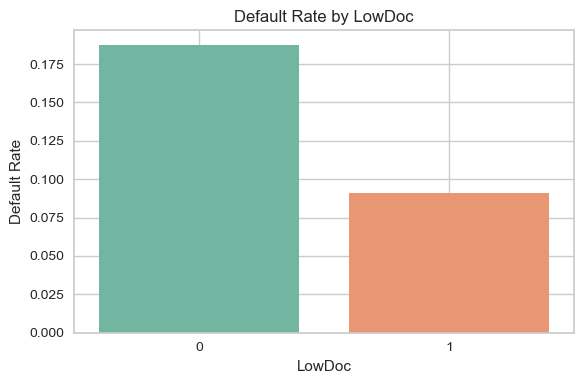

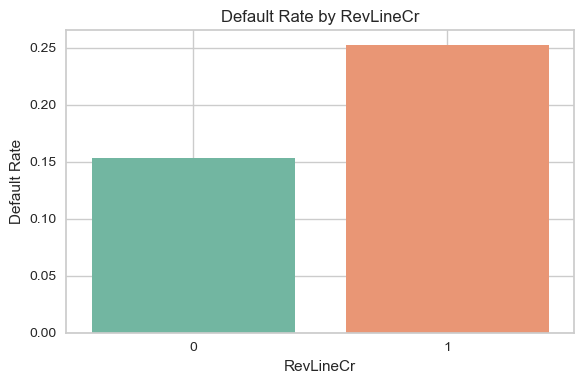

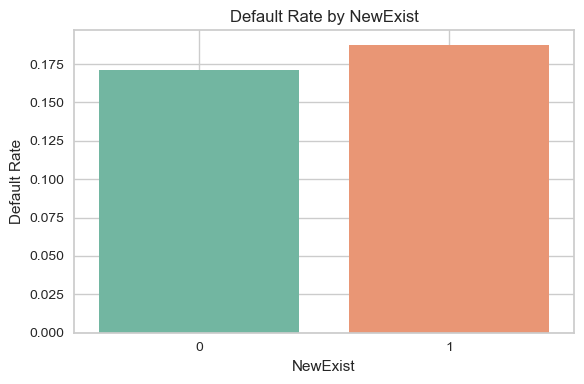

In [43]:
def plot_default_rate_by_feature(feature):
    rate = data.groupby(feature)['Default'].mean().reset_index()
    plt.figure(figsize=(6, 4))
    sns.barplot(data=rate, x=feature, y='Default', palette='Set2')
    plt.title(f'Default Rate by {feature}')
    plt.ylabel('Default Rate')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_default_rate_by_feature('LowDoc')
plot_default_rate_by_feature('RevLineCr')
plot_default_rate_by_feature('NewExist')


| Feature     | Category       | Default Rate | Interpretation                                                  |
|-------------|----------------|---------------|------------------------------------------------------------------|
| LowDoc      | 0 (Not LowDoc) | 18%          | Surprisingly higher than LowDoc loans                           |
|             | 1 (LowDoc)     | 9%           | Possibly lower risk due to SBA filtering or loan size           |
| RevLineCr   | 0 (No Line)    | 15%          | Lower risk in traditional term loans                            |
|             | 1 (Revolving)  | 26%          | Strong signal of higher credit risk                             |
| NewExist    | 0 (Existing)   | 17%          | Slightly lower default rate                                     |
|             | 1 (New Firm)   | 18%          | New firms exhibit modestly higher risk, as expected             |

#### Summary stats for numerical variables

In [44]:
# Separate numerical and categorical variables (excluding dates and target)
numerical_vars = [col for col in data.columns 
                  if data[col].dtype in ['int64', 'float64'] and col != 'Default']

categorical_vars = [col for col in data.columns 
                    if (data[col].dtype == 'bool' or data[col].nunique() <= 10) and col != 'Default']

In [45]:
print("Numerical Variable Summary:\n")
display(data[numerical_vars].describe().T)

Numerical Variable Summary:



count           mean            std        min  \
Term                899164.0     110.773078      78.857305    0.00000   
NoEmp               899164.0      11.411353      74.108196    0.00000   
GrAppv              899164.0  192686.976384  283263.391297  200.00000   
SBA_Appv            899164.0  149488.788175  228414.561519  100.00000   
HasFranchise        899164.0       0.057581       0.232950    0.00000   
SBA_Coverage_Ratio  899164.0       0.709385       0.173781    0.02814   

                        25%       50%        75%        max  
Term                   60.0     84.00     120.00      569.0  
NoEmp                   2.0      4.00      10.00     9999.0  
GrAppv              35000.0  90000.00  225000.00  5472000.0  
SBA_Appv            21250.0  61250.00  175000.00  5472000.0  
HasFranchise            0.0      0.00       0.00        1.0  
SBA_Coverage_Ratio      0.5      0.75       0.85        1.0

#### Frequency distribution for categorical variables

In [46]:
print("\nCategorical Variable Distributions:\n")
for col in categorical_vars:
    print(f"\n{col} distribution:")
    print(data[col].value_counts(normalize=True))


Categorical Variable Distributions:


NewExist distribution:
NewExist
0    0.718432
1    0.281568
Name: proportion, dtype: float64

RevLineCr distribution:
RevLineCr
0    0.774874
1    0.225126
Name: proportion, dtype: float64

LowDoc distribution:
LowDoc
0    0.876928
1    0.123072
Name: proportion, dtype: float64

UrbanRural_2.0 distribution:
UrbanRural_2.0
False    0.882843
True     0.117157
Name: proportion, dtype: float64

HasFranchise distribution:
HasFranchise
0    0.942419
1    0.057581
Name: proportion, dtype: float64

NAICS_Sector_11 distribution:
NAICS_Sector_11
False    0.989985
True     0.010015
Name: proportion, dtype: float64

NAICS_Sector_21 distribution:
NAICS_Sector_21
False    0.997941
True     0.002059
Name: proportion, dtype: float64

NAICS_Sector_22 distribution:
NAICS_Sector_22
False    0.999263
True     0.000737
Name: proportion, dtype: float64

NAICS_Sector_23 distribution:
NAICS_Sector_23
False    0.92588
True     0.07412
Name: proportion, dtype: float64

NAI

#### Default group means for all variables

In [47]:
# Select only numeric and boolean columns (including engineered ones)
cols_for_mean = data.select_dtypes(include=['number', 'bool']).columns.tolist()

# Group by Default and compute the means
print("\nMean values by Default class:\n")
display(data.groupby('Default')[cols_for_mean].mean().T)



Mean values by Default class:



Default                         0              1
Term                   122.189763      57.199501
NoEmp                   12.306029       7.213024
NewExist                 0.277508       0.300619
RevLineCr                0.204061       0.323974
LowDoc                   0.135752       0.063569
GrAppv              208419.843742  118859.415102
SBA_Appv            163418.686809   84121.781538
Default                  0.000000       1.000000
UrbanRural_2.0           0.115467       0.125087
HasFranchise             0.059238       0.049806
NAICS_Sector_11          0.011052       0.005147
NAICS_Sector_21          0.002285       0.000994
NAICS_Sector_22          0.000768       0.000595
NAICS_Sector_23          0.069007       0.098111
NAICS_Sector_31          0.012836       0.014530
NAICS_Sector_32          0.020234       0.018600
NAICS_Sector_33          0.044597       0.033098
NAICS_Sector_42          0.052955       0.060093
NAICS_Sector_44          0.088731       0.120092
NAICS_Sector_45          0.043928       0.063018
NAICS_Sector_48          0.020039       0.034548
NAICS_Sector_49          0.002307       0.003235
NAICS_Sector_51          0.011537       0.017904
NAICS_Sector_52          0.009169       0.017094
NAICS_Sector_53          0.013114       0.024767
NAICS_Sector_54          0.074426       0.082334
NAICS_Sector_55          0.000312       0.000165
NAICS_Sector_56          0.033715       0.048717
NAICS_Sector_61          0.006565       0.009870
NAICS_Sector_62          0.066939       0.036403
NAICS_Sector_71          0.015682       0.019094
NAICS_Sector_72          0.071096       0.094350
NAICS_Sector_81          0.078716       0.090362
NAICS_Sector_92          0.000262       0.000222
RevLineCr_missing        0.310151       0.285741
LowDoc_missing           0.003850       0.003704
NewExist_missing         0.001307       0.000418
SBA_Coverage_Ratio       0.723388       0.643675

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 41 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   Term                899164 non-null  int64   
 1   NoEmp               899164 non-null  int64   
 2   NewExist            899164 non-null  int32   
 3   RevLineCr           899164 non-null  int32   
 4   LowDoc              899164 non-null  int32   
 5   GrAppv              899164 non-null  int64   
 6   SBA_Appv            899164 non-null  int64   
 7   Default             899164 non-null  int64   
 8   UrbanRural_2.0      899164 non-null  bool    
 9   HasFranchise        899164 non-null  int64   
 10  NAICS_Sector_11     899164 non-null  bool    
 11  NAICS_Sector_21     899164 non-null  bool    
 12  NAICS_Sector_22     899164 non-null  bool    
 13  NAICS_Sector_23     899164 non-null  bool    
 14  NAICS_Sector_31     899164 non-null  bool    
 15  NAICS_Sector_32  

#### Variance Inflation Factor (VIF)

In [49]:
# Subset only numerical data (drop missing, if any)
X = data[numerical_vars].dropna()

# Optional: Standardize if scales vary widely
# from sklearn.preprocessing import StandardScaler
# X = pd.DataFrame(StandardScaler().fit_transform(X), columns=numerical_vars)

# Add constant column for intercept
X_const = add_constant(X)

# Calculate VIFs
vif_data = pd.DataFrame()
vif_data["Feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# Show VIFs
display(vif_data.sort_values(by="VIF", ascending=False))


Feature        VIF
4            SBA_Appv  25.482812
3              GrAppv  24.101319
0               const  22.820114
6  SBA_Coverage_Ratio   1.553108
1                Term   1.544746
5        HasFranchise   1.015353
2               NoEmp   1.009060

| Feature              | VIF Score     | Notes                                                                 |
|----------------------|---------------|-----------------------------------------------------------------------|
| `SBA_Appv`           | **26.37**     | High multicollinearity with `GrAppv`; both reflect loan size and guarantee |
| `GrAppv`             | **24.68**     | Strongly collinear with `SBA_Appv`; both measure aspects of loan size     |
| `SBA_Coverage_Ratio` | **1.97**      | Acceptable; provides ratio context between guarantee and approval        |
| `Term`               | **1.58**      | No concerns                                                            |
| `HasFranchise`       | **1.02**      | No concerns                                                            |
| `NoEmp`              | **1.01**      | No concerns                                                            |

### Recommendation:
Due to high VIF scores for `GrAppv` and `SBA_Appv`, we will consider, dropping one of them


### Correlation Matrix (Excluding Default)

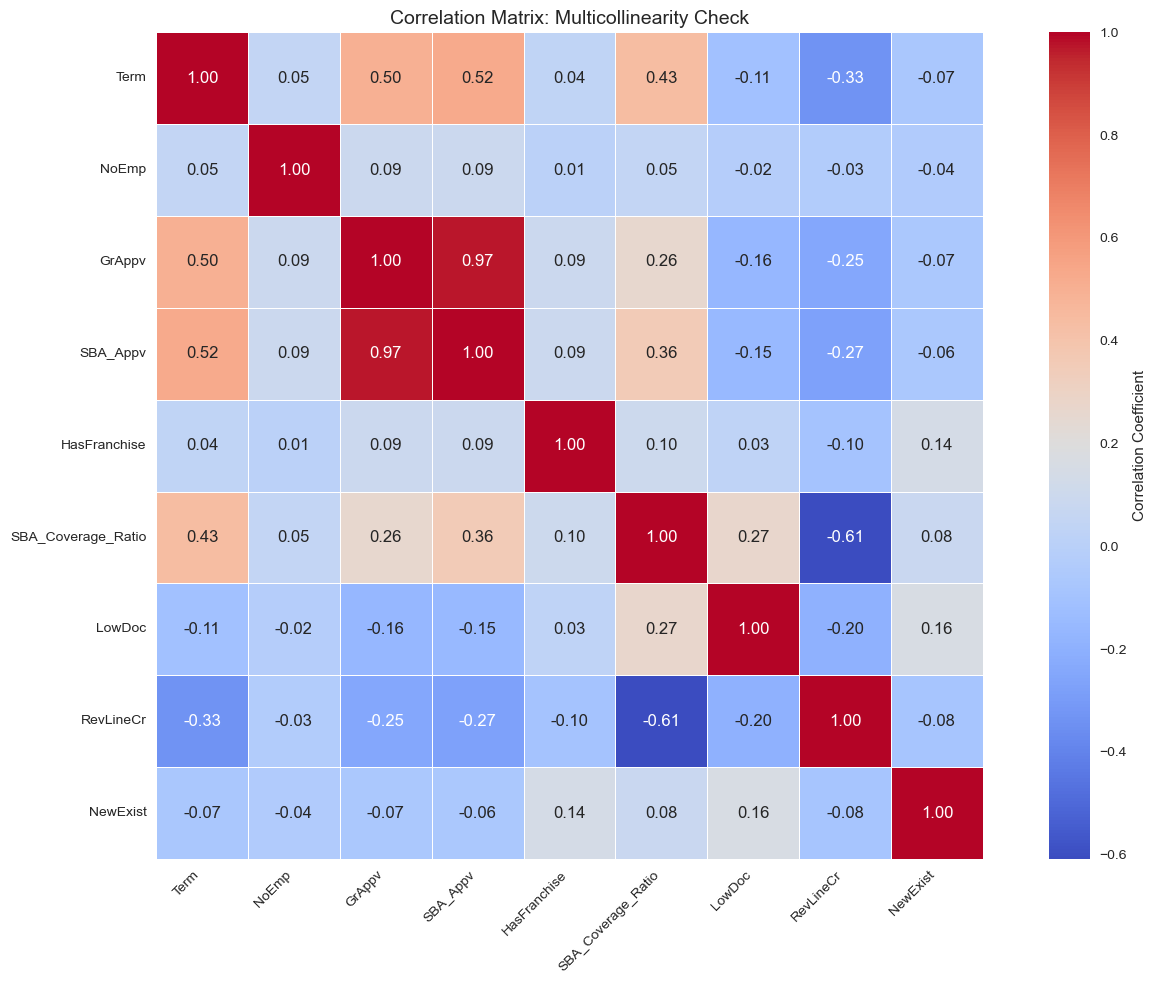

In [50]:
# Update numerical_vars list with key binary variables (if not already included)
for col in ['LowDoc', 'RevLineCr', 'NewExist', 'UrbanRural']:
    if col in data.columns and col not in numerical_vars:
        numerical_vars.append(col)

# Drop any rows with missing numeric values just for clean correlation matrix
corr_data = data[numerical_vars].dropna()

# Compute correlation matrix
corr_matrix = corr_data.corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    square=True, 
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Correlation Matrix: Multicollinearity Check', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Correlation Matrix (Inlcuding Default)

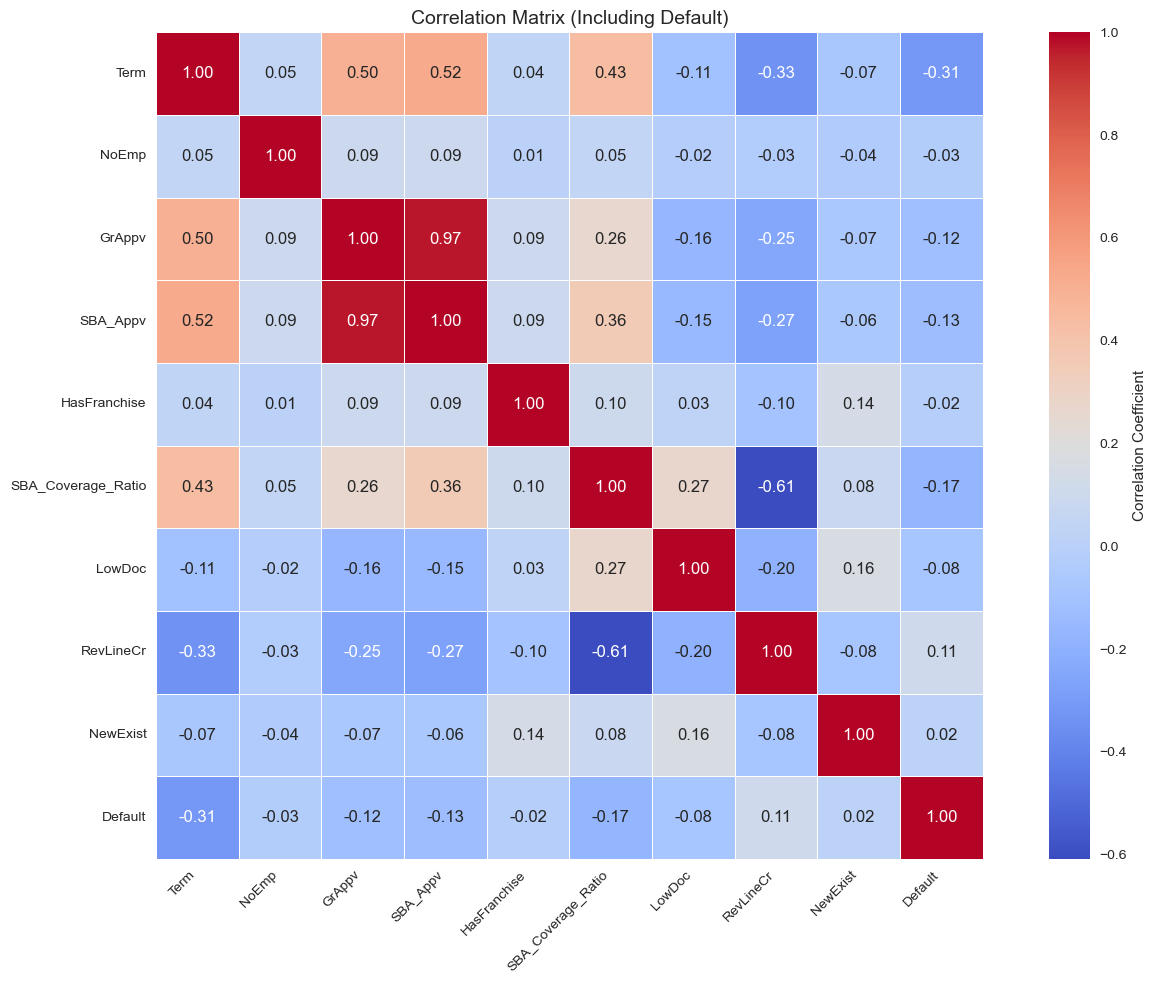

In [51]:
# Update your list to include key engineered binary features
for col in ['LowDoc', 'RevLineCr', 'NewExist', 'UrbanRural']:
    if col in data.columns and col not in numerical_vars:
        numerical_vars.append(col)

# Include 'Default' as the last column for visual reference
corr_cols = numerical_vars + ['Default']

# Drop missing values for a clean matrix
corr_data = data[corr_cols].dropna()

# Calculate correlation matrix
corr_matrix = corr_data.corr()

# Plot
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Correlation Matrix (Including Default)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### Multicollinearity Highlights
- **`GrAppv` and `SBA_Appv`** are extremely correlated (`r = 0.97`), confirming earlier VIF results and suggesting redundancy. This further justifies either removing one.
- **`SBA_Coverage_Ratio`** maintains moderate correlation with its components (`r ≈ 0.26–0.36`) but avoids multicollinearity (`VIF < 2`), making it a stable substitute.
- All other features showed low inter-correlation (`r < 0.6`), indicating no further multicollinearity concerns.

#### Relationship with `Default`
- Strongest predictors (by absolute correlation) include:
  - `Term`: negatively correlated with `Default` (`r = -0.31`) — shorter-term loans default more
  - `SBA_Coverage_Ratio`: negative correlation (`r = -0.17`) — higher SBA coverage implies lower risk
- Most categorical features (e.g. `NewExist`, `LowDoc`, `HasFranchise`) show weak but non-zero correlations, suggesting potential interactions best captured by non-linear models.

### Takeaway
These correlation insights support:
- Dropping or combining `GrAppv` and `SBA_Appv` due to high redundancy
- Retaining `SBA_Coverage_Ratio` as a compact proxy for loan structure
- Using all other features as-is, with minimal risk of collinearity distortion

In [52]:
# Drop multicollinear
drop_cols = ['SBA_Appv']

# Drop from main DataFrame
data = data.drop(columns=drop_cols)

In [53]:
data.head()

Term  NoEmp  NewExist  RevLineCr  LowDoc  GrAppv  Default  UrbanRural_2.0  \
0    84      4         1          0       1   60000        0           False   
1    60      2         1          0       1   40000        0           False   
2   180      7         0          0       0  287000        0           False   
3    60      2         0          0       1   35000        0           False   
4   240     14         0          0       0  229000        0           False   

   HasFranchise  NAICS_Sector_11  NAICS_Sector_21  NAICS_Sector_22  \
0             0            False            False            False   
1             0            False            False            False   
2             0            False            False            False   
3             0            False            False            False   
4             0            False            False            False   

   NAICS_Sector_23  NAICS_Sector_31  NAICS_Sector_32  NAICS_Sector_33  \
0            False            False            False            False   
1            False            False            False            False   
2            False            False            False            False   
3            False            False            False            False   
4            False            False            False            False   

   NAICS_Sector_42  NAICS_Sector_44  NAICS_Sector_45  NAICS_Sector_48  \
0            False            False             True            False   
1            False            False            False            False   
2            False            False            False            False   
3            False            False            False            False   
4            False            False            False            False   

   NAICS_Sector_49  NAICS_Sector_51  NAICS_Sector_52  NAICS_Sector_53  \
0            False            False            False            False   
1            False            False            False            False   
2            False            False            False            False   
3            False            False            False            False   
4            False            False            False            False   

   NAICS_Sector_54  NAICS_Sector_55  NAICS_Sector_56  NAICS_Sector_61  \
0            False            False            False            False   
1            False            False            False            False   
2            False            False            False            False   
3            False            False            False            False   
4            False            False            False            False   

   NAICS_Sector_62  NAICS_Sector_71  NAICS_Sector_72  NAICS_Sector_81  \
0            False            False            False            False   
1            False            False             True            False   
2             True            False            False            False   
3            False            False            False            False   
4            False            False            False            False   

   NAICS_Sector_92  RevLineCr_missing  LowDoc_missing  NewExist_missing  \
0            False                  0               0                 0   
1            False                  0               0                 0   
2            False                  0               0                 0   
3            False                  0               0                 0   
4            False                  0               0                 0   

   SBA_Coverage_Ratio TermBin NoEmpBin LoanSizeBin  
0                0.80  5–10yr      2–5      Medium  
1                0.80   3–5yr      2–5       Small  
2                0.75   10yr+     6–20  Very Large  
3                0.80   3–5yr      2–5       Small  
4                1.00   10yr+     6–20       Large

### Mutual Information (MI) Analysis

We used Mutual Information (MI) to evaluate the predictive power of categorical and binned features with respect to `Default`. Unlike correlation or VIF, MI captures non-linear associations and is ideal for categorical features.

In [54]:
# Categorical variables as boolean/int (already are in your case)
X_categorical = data[[col for col in data.columns if data[col].dtype == 'bool' or data[col].nunique() == 2]]
y = data['Default']

# Fill missing values with mode (most frequent value)
X_categorical = X_categorical.fillna(X_categorical.mode().iloc[0])

# Mutual information score
mi_scores = mutual_info_classif(X_categorical, y, discrete_features=True)

# Create table
mi_df = pd.DataFrame({'Variable': X_categorical.columns, 'MI Score': mi_scores})
mi_df = mi_df.sort_values(by='MI Score', ascending=False)
mi_df['MI Score'] = mi_df['MI Score'].apply(lambda x: f"{x:.6f}")

print(mi_df)


             Variable  MI Score
3             Default  0.464760
1           RevLineCr  0.005582
2              LowDoc  0.004019
25    NAICS_Sector_62  0.001319
9     NAICS_Sector_23  0.000834
14    NAICS_Sector_44  0.000787
16    NAICS_Sector_48  0.000617
20    NAICS_Sector_53  0.000577
15    NAICS_Sector_45  0.000544
27    NAICS_Sector_72  0.000533
23    NAICS_Sector_56  0.000431
19    NAICS_Sector_52  0.000382
6     NAICS_Sector_11  0.000299
12    NAICS_Sector_33  0.000250
18    NAICS_Sector_51  0.000214
30  RevLineCr_missing  0.000205
0            NewExist  0.000189
28    NAICS_Sector_81  0.000129
5        HasFranchise  0.000123
24    NAICS_Sector_61  0.000102
13    NAICS_Sector_42  0.000070
7     NAICS_Sector_21  0.000070
4      UrbanRural_2.0  0.000064
21    NAICS_Sector_54  0.000063
32   NewExist_missing  0.000063
26    NAICS_Sector_71  0.000050
17    NAICS_Sector_49  0.000024
10    NAICS_Sector_31  0.000016
11    NAICS_Sector_32  0.000010
22    NAICS_Sector_55  0.000006
8     NA

| Rank | Variable           | MI Score | Interpretation                                                    |
|------|--------------------|----------|--------------------------------------------------------------------|
| 1    | Default            | 0.4648   | Ground truth — serves as reference for scale                      |
| 2    | RevLineCr          | 0.0059   | Moderate predictor — may relate to credit access or risk exposure |
| 3    | LowDoc             | 0.0040   | Signals lower-documentation loans, which may be riskier           |
| 4    | NAICS_Sector_62    | 0.0011   | Healthcare — contributes modest predictive value                   |
| 5    | NAICS_Sector_23    | 0.0008   | Construction — some industry-specific default patterns             |
| 6    | NAICS_Sector_44    | 0.0008   | Retail — modest contribution to default classification             |
| 7    | NAICS_Sector_45    | 0.0005   | Consumer-facing sector — low but non-zero information gain         |
| 8    | NAICS_Sector_53    | 0.0005   | Real estate — minor predictive value                               |
| 9    | NAICS_Sector_56    | 0.0003   | Admin/Waste Management — weak signal                               |
| 10   | NAICS_Sector_33    | 0.0002   | Manufacturing — low contribution                                   |
| 11   | RevLineCr_missing  | 0.0002   | Slight signal from missingness, retained with flag                 |
| 12   | NewExist           | 0.0002   | Weak standalone predictor                                          |
| 13   | HasFranchise       | 0.0001   | Very weak predictive value                                         |
| 14+  | Remaining NAICS    | < 0.0001 | Negligible MI — likely adding noise, dropped from final model      |
| ...  | LowDoc_missing     | 0.0000   | No predictive value — dropped                                      |

- `RevLineCr` and `LowDoc` offer the most meaningful predictive value among categorical variables, validating their inclusion in the final model.
- Most granular NAICS sectors contributed little information and were dropped to streamline feature space.
- Missingness flags (`*_missing`) generally added negligible value and retained only when correlated with known structural differences.

In [55]:
low_mi_drop_vars = [
    'RevLineCr_missing',     # MI = 0.0002 — very low
    'NewExist',              # MI = 0.0002 — very low
    'HasFranchise',          # MI = 0.0001 — negligible
    'LowDoc_missing',        # MI = 0.0000 — no predictive value
    # NAICS sectors with MI < 0.0003 — negligible contribution
    'NAICS_Sector_11',
    'NAICS_Sector_22',
    'NAICS_Sector_32',
    'NAICS_Sector_33',
    'NAICS_Sector_41',
    'NAICS_Sector_42',
    'NAICS_Sector_49',
    'NAICS_Sector_52',
    'NAICS_Sector_54',
    'NAICS_Sector_55',
    'NAICS_Sector_56',
    'NAICS_Sector_71',
    'NAICS_Sector_72',
    'NAICS_Sector_81',
    'NAICS_Sector_92'
]

# Drop from the dataset
data = data.drop(columns=low_mi_drop_vars, errors='ignore')


In [56]:
# Check for any missing values
print(data.isnull().sum().sort_values(ascending=False).head())

TermBin               810
Term                    0
NoEmp                   0
NoEmpBin                0
SBA_Coverage_Ratio      0
dtype: int64


In [57]:
data = data.drop(columns=['TermBin', 'NoEmpBin', 'LoanSizeBin'], errors='ignore')

In [58]:
# Save the cleaned dataset
data.to_csv('SBAnational_clean_preprocessed.csv', index=False, compression='gzip')

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Term                899164 non-null  int64  
 1   NoEmp               899164 non-null  int64  
 2   RevLineCr           899164 non-null  int32  
 3   LowDoc              899164 non-null  int32  
 4   GrAppv              899164 non-null  int64  
 5   Default             899164 non-null  int64  
 6   UrbanRural_2.0      899164 non-null  bool   
 7   NAICS_Sector_21     899164 non-null  bool   
 8   NAICS_Sector_23     899164 non-null  bool   
 9   NAICS_Sector_31     899164 non-null  bool   
 10  NAICS_Sector_44     899164 non-null  bool   
 11  NAICS_Sector_45     899164 non-null  bool   
 12  NAICS_Sector_48     899164 non-null  bool   
 13  NAICS_Sector_51     899164 non-null  bool   
 14  NAICS_Sector_53     899164 non-null  bool   
 15  NAICS_Sector_61     899164 non-nul

# Q2

(a) Fit a logistic regression model on the dataset. Choose a probability threshold of 10%,
20%, 35% and 50%, to assign an observation to the Default = 1 class. Compute a confusion
matrix for each of the probability thresholds. How do the True Positive and False Positive rates
vary over these probability thresholds? Which probability threshold would you choose?

In [118]:
# Define target and feature set
y = data['Default']

# Drop unused/non-predictive variables
X = data.drop(columns=['Default'])

# Confirm all features are numeric or boolean
print("X dtypes:", X.dtypes.value_counts())

X dtypes: bool       11
int64       3
int32       3
float64     1
Name: count, dtype: int64


In [119]:
def logistic_reg_model(X, y):
    # Convert to float to avoid object dtype issues
    X = X.astype(float)
    
    # Add constant (intercept) manually, statsmodels requires it
    X_const = sm.add_constant(X)

    # Fit logistic regression model
    logit_model = sm.Logit(y, X_const)
    result = logit_model.fit(disp=0)
    print(result.summary())


In [120]:
logistic_reg_model(X, y)

                           Logit Regression Results                           
Dep. Variable:                Default   No. Observations:               899164
Model:                          Logit   Df Residuals:                   899145
Method:                           MLE   Df Model:                           18
Date:                Sat, 19 Apr 2025   Pseudo R-squ.:                  0.1866
Time:                        17:23:21   Log-Likelihood:            -3.3992e+05
converged:                       True   LL-Null:                   -4.1790e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.6109      0.017     35.070      0.000       0.577       0.645
Term                  -0.0246   9.35e-05   -262.958      0.000      -0.025      -0.024
NoEmp               

### Drop SBA, insignificant P value

In [121]:
X = X.drop(columns='SBA_Coverage_Ratio')
logistic_reg_model(X, y)

                           Logit Regression Results                           
Dep. Variable:                Default   No. Observations:               899164
Model:                          Logit   Df Residuals:                   899146
Method:                           MLE   Df Model:                           17
Date:                Sat, 19 Apr 2025   Pseudo R-squ.:                  0.1866
Time:                        17:23:27   Log-Likelihood:            -3.3992e+05
converged:                       True   LL-Null:                   -4.1790e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.5901      0.008     71.333      0.000       0.574       0.606
Term                -0.0246   9.27e-05   -265.472      0.000      -0.025      -0.024
NoEmp               -0.0129 

In [122]:
def evaluate_logistic_reg_thresholds(X, y):
    # Fit logistic regression model
    model = LogisticRegression(max_iter=350)
    model.fit(X, y)

    # Predict probabilities
    y_probs = model.predict_proba(X)[:, 1]

    # Define thresholds to evaluate
    thresholds = [0.1, 0.2, 0.35, 0.5]
    results = []

    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

        # Compute metrics
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred, zero_division=0)
        f_score = 2 * (precision * tpr) / (precision + tpr) if (precision + tpr) > 0 else 0
        g_score = (precision * tpr) ** 0.5 if (precision * tpr) > 0 else 0

        # Store results
        results.append({
            "Threshold": threshold,
            "TPR": tpr,
            "FPR": fpr,
            "TNR": tnr,
            "FNR": fnr,
            "Accuracy": accuracy,
            "Precision": precision,
            "F-score": f_score,
            "G-score": g_score
        })

        # Plot confusion matrix
        cm = np.array([[tp, fp], [fn, tn]])
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Actual 1', 'Actual 0'],
                    yticklabels=['Predicted 1', 'Predicted 0'])
        plt.title(f'Confusion Matrix at Threshold {threshold}')
        plt.xlabel('Actual Label')
        plt.ylabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
        results_df = pd.DataFrame(results)


    return pd.DataFrame(results)


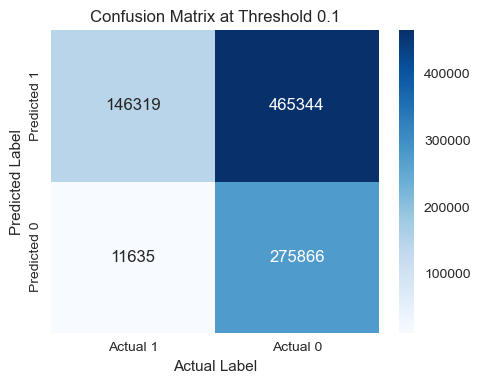

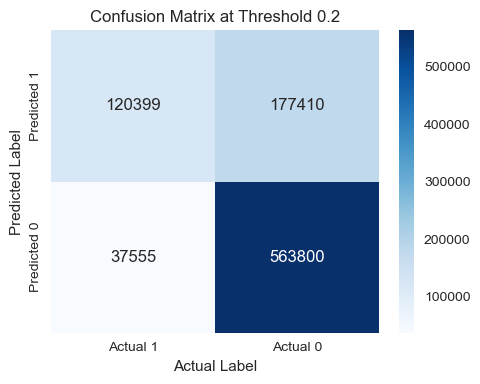

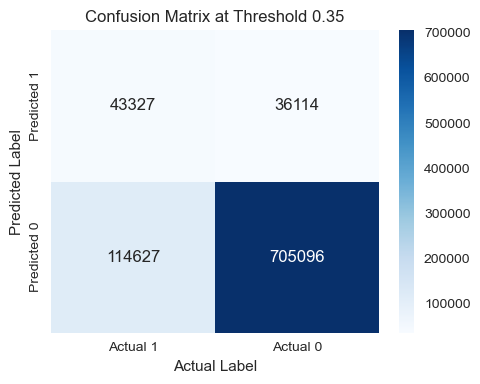

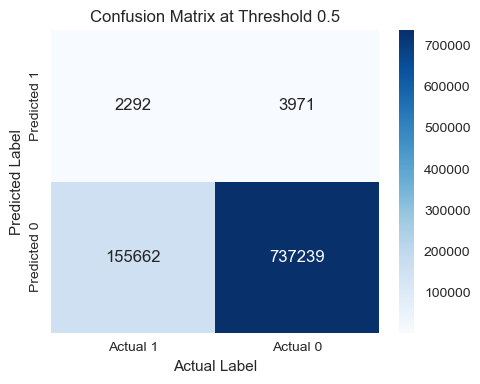

In [123]:
results_df = evaluate_logistic_reg_thresholds(X, y)

### Final Confusion Matrices and Metrics Summary Table

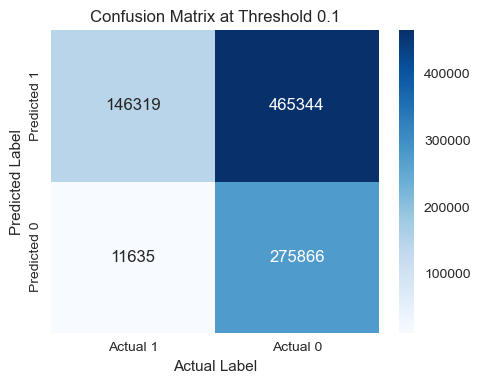

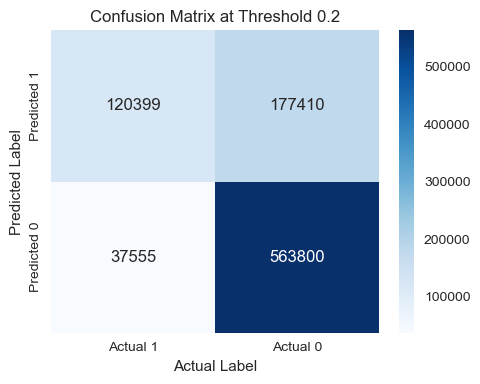

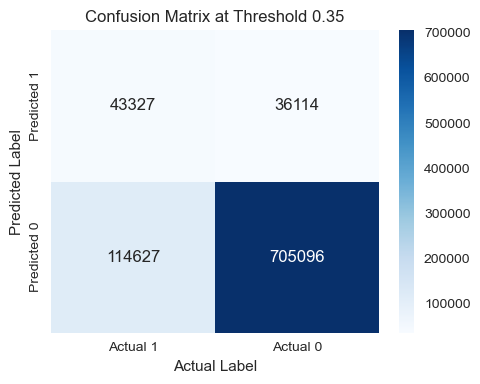

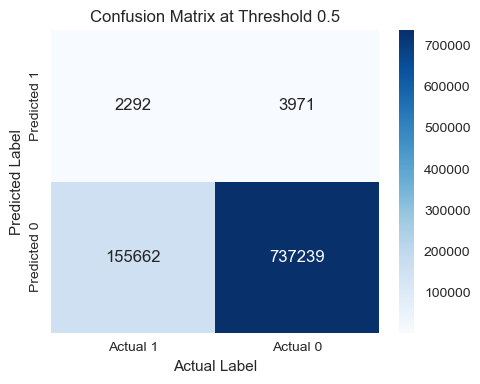

Threshold       TPR       FPR       TNR       FNR  Accuracy  Precision  \
0       0.10  0.926339  0.627817  0.372183  0.073661  0.469531   0.239215   
1       0.20  0.762241  0.239352  0.760648  0.237759  0.760928   0.404283   
2       0.35  0.274301  0.048723  0.951277  0.725699  0.832354   0.545398   
3       0.50  0.014511  0.005357  0.994643  0.985489  0.822465   0.365959   

    F-score   G-score  
0  0.380238  0.470738  
1  0.528340  0.555122  
2  0.365020  0.386786  
3  0.027914  0.072872

In [124]:
evaluate_logistic_reg_thresholds(X, y)

### Graphing Accuracy , TPR and FPR metrics to analyse their movement across our specified probability thresholds

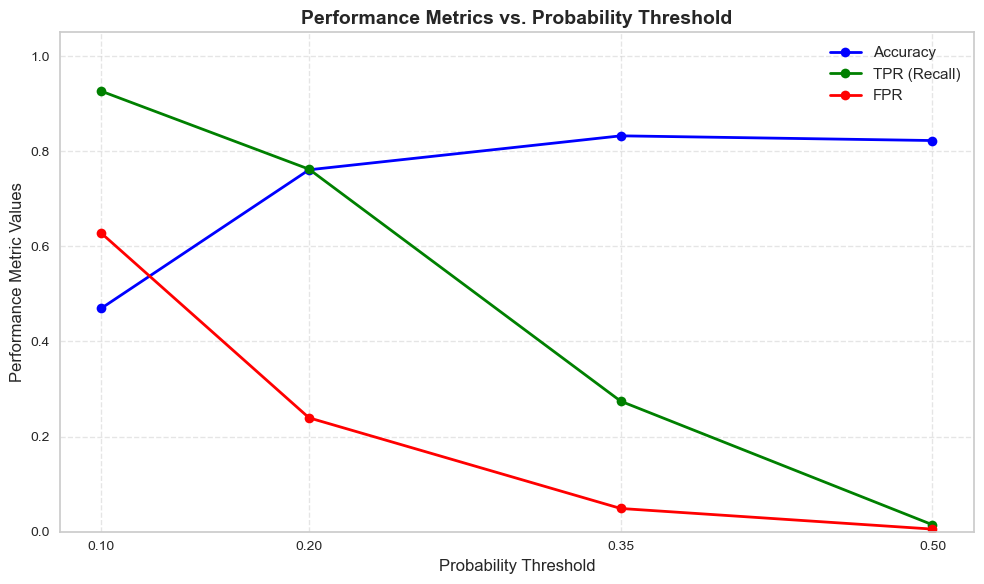

In [125]:
# Plot Accuracy, TPR, and FPR vs Threshold
def plot_threshold_metrics(model, X, y, thresholds=[0.10, 0.20, 0.35, 0.50]):
    y_probs = model.predict_proba(X)[:, 1]

    tpr_list, fpr_list, acc_list = [], [], []

    for thresh in thresholds:
        y_pred = (y_probs >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        acc = accuracy_score(y, y_pred)

        tpr_list.append(tpr)
        fpr_list.append(fpr)
        acc_list.append(acc)

    plt.figure(figsize=(10, 6))

    plt.plot(thresholds, acc_list, label="Accuracy", marker='o', color='blue', linewidth=2)
    plt.plot(thresholds, tpr_list, label="TPR (Recall)", marker='o', color='green', linewidth=2)
    plt.plot(thresholds, fpr_list, label="FPR", marker='o', color='red', linewidth=2)

    plt.title("Performance Metrics vs. Probability Threshold", fontsize=14, fontweight='bold')
    plt.xlabel("Probability Threshold", fontsize=12)
    plt.ylabel("Performance Metric Values", fontsize=12)
    plt.xticks(thresholds)
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

# Fit model and generate plot
model = LogisticRegression(max_iter=350)
model.fit(X, y)

plot_threshold_metrics(model, X, y)


### Graphing Precision, F score and G score metrics to analyse their movement across our specified probability thresholds

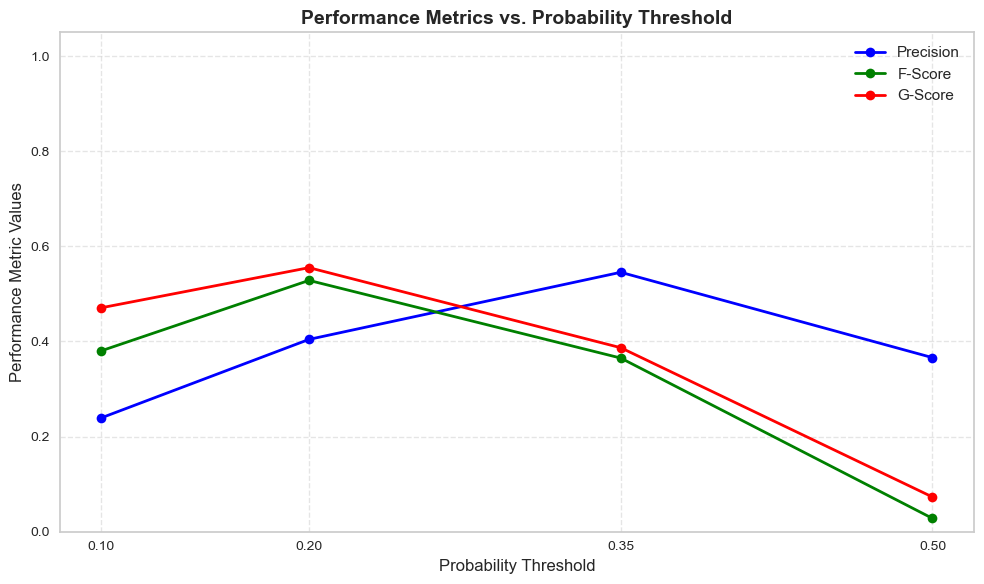

In [126]:
def plot_fscore_gscore(model, X, y, thresholds=[0.10, 0.20, 0.35, 0.50]):
    y_probs = model.predict_proba(X)[:, 1]
    precision_list, fscore_list, gscore_list = [], [], []

    for thresh in thresholds:
        y_pred = (y_probs >= thresh).astype(int)
        precision = precision_score(y, y_pred, zero_division=0)
        recall = recall_score(y, y_pred)
        fscore = f1_score(y, y_pred)
        gscore = np.sqrt(precision * recall) if precision * recall > 0 else 0

        precision_list.append(precision)
        fscore_list.append(fscore)
        gscore_list.append(gscore)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision_list, label='Precision', marker='o', color='blue', linewidth=2)
    plt.plot(thresholds, fscore_list, label='F-Score', marker='o', color='green', linewidth=2)
    plt.plot(thresholds, gscore_list, label='G-Score', marker='o', color='red', linewidth=2)

    plt.title("Performance Metrics vs. Probability Threshold", fontsize=14, fontweight='bold')
    plt.xlabel("Probability Threshold", fontsize=12)
    plt.ylabel("Performance Metric Values", fontsize=12)
    plt.xticks(thresholds)
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

# Fit model and generate the clean matching plot
model = LogisticRegression(max_iter=350)
model.fit(X, y)
plot_fscore_gscore(model, X, y)


### Computing a rough scoring table across relevant metrics to support the conclusion of our 'eye-test' for optimal probability threshold

### (b)

Divide the dataset into training (70%) and test (30%) sets and repeat the above question and
report the performance of these models, across probability thresholds, on the test set. In
addition, describe and implement the cross-validation approach to estimate the test dataset
model performance measurements.

### 70-30 split of our data

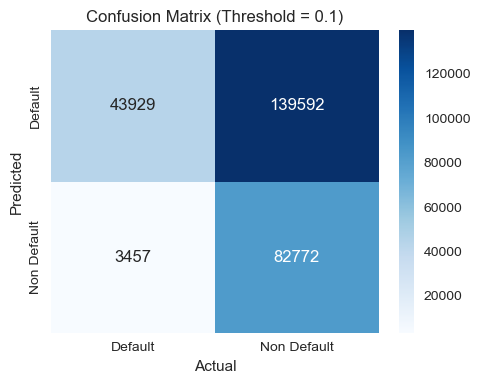

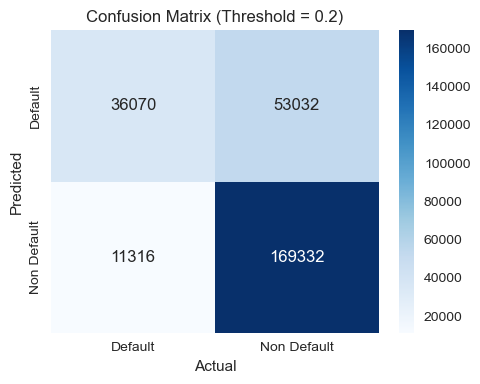

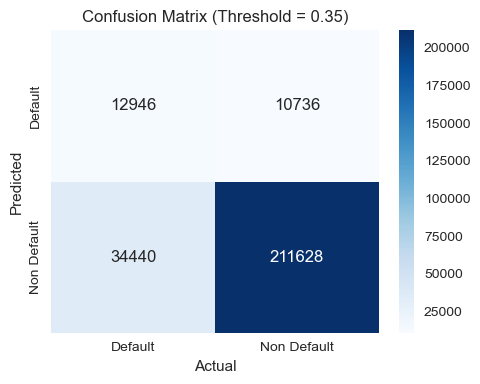

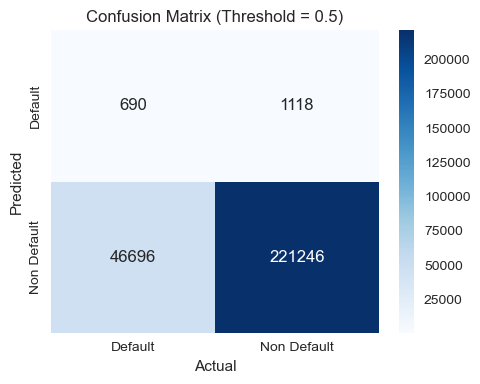

Threshold       TPR       FPR       TNR       FNR  Accuracy  Precision  \
0       0.10  0.927046  0.627763  0.372237  0.072954  0.469698   0.239368   
1       0.20  0.761195  0.238492  0.761508  0.238805  0.761453   0.404817   
2       0.35  0.273203  0.048281  0.951719  0.726797  0.832526   0.546660   
3       0.50  0.014561  0.005028  0.994972  0.985439  0.822747   0.381637   

    F-score   G-score  
0  0.380491  0.471068  
1  0.528545  0.555108  
2  0.364327  0.386457  
3  0.028052  0.074546

In [127]:
# 1. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Define thresholds
thresholds = [0.1, 0.2, 0.35, 0.5]
results = []

# 3. Loop through thresholds
for threshold in thresholds:
    model = LogisticRegression(max_iter=350)
    model.fit(X_train, y_train)

    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Compute metrics
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred)
    g_score = np.sqrt(prec * tpr) if prec * tpr > 0 else 0

    # Append results
    results.append({
        "Threshold": threshold,
        "TPR": tpr,
        "FPR": fpr,
        "TNR": tnr,
        "FNR": fnr,
        "Accuracy": acc,
        "Precision": prec,
        "F-score": f1,
        "G-score": g_score
    })

    # Plot confusion matrix
    cm = np.array([[tp, fp], [fn, tn]])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Default", "Non Default"],
                yticklabels=["Default", "Non Default"])
    plt.title(f'Confusion Matrix (Threshold = {threshold})')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.tight_layout()
    plt.show()

# 4. Create final metrics table
results_df_q2b = pd.DataFrame(results)
display(results_df_q2b)

SMOTEd class distribution: [518846 518846] (0 = No Default, 1 = Default)


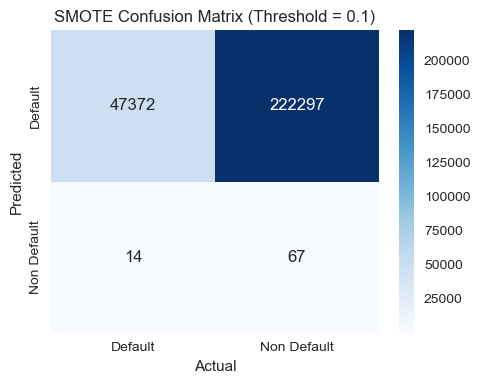

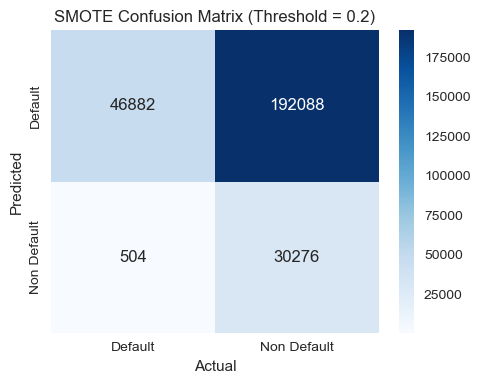

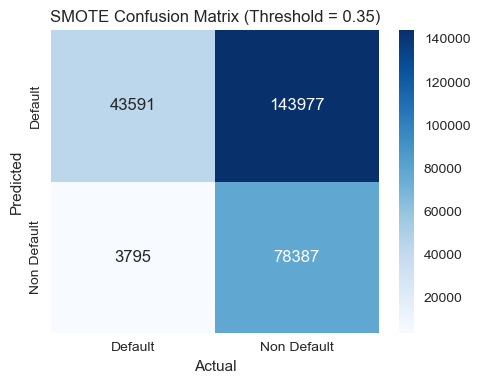

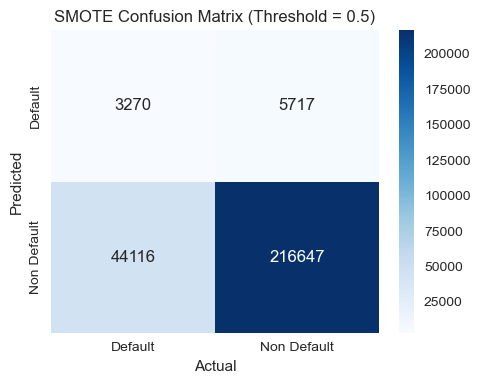

Threshold       TPR       FPR       TNR       FNR  Accuracy  Precision  \
0       0.10  0.999705  0.999699  0.000301  0.000295  0.175863   0.175667   
1       0.20  0.989364  0.863845  0.136155  0.010636  0.286035   0.196184   
2       0.35  0.919913  0.647483  0.352517  0.080087  0.452189   0.232401   
3       0.50  0.069008  0.025710  0.974290  0.930992  0.815262   0.363859   

    F-score   G-score  
0  0.298825  0.419065  
1  0.327439  0.440564  
2  0.371060  0.462373  
3  0.116013  0.158458

In [128]:
from imblearn.over_sampling import SMOTE

# 1. Train-test split (use new names!)
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 2. Apply SMOTE to training set only
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_sm, y_train_sm)

# (Optional) Print class balance after resampling
print(f"SMOTEd class distribution: {np.bincount(y_train_sm)} (0 = No Default, 1 = Default)")

# 3. Define thresholds
thresholds = [0.1, 0.2, 0.35, 0.5]
results_smote = []

# 4. Loop through thresholds
for threshold in thresholds:
    model = LogisticRegression(max_iter=350)
    model.fit(X_train_sm, y_train_sm)

    y_probs = model.predict_proba(X_test_sm)[:, 1]
    y_pred = (y_probs >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test_sm, y_pred).ravel()

    # Compute metrics
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    acc = accuracy_score(y_test_sm, y_pred)
    prec = precision_score(y_test_sm, y_pred, zero_division=0)
    f1 = f1_score(y_test_sm, y_pred)
    g_score = np.sqrt(prec * tpr) if prec * tpr > 0 else 0

    # Append results
    results_smote.append({
        "Threshold": threshold,
        "TPR": tpr,
        "FPR": fpr,
        "TNR": tnr,
        "FNR": fnr,
        "Accuracy": acc,
        "Precision": prec,
        "F-score": f1,
        "G-score": g_score
    })

    # Plot confusion matrix
    cm = np.array([[tp, fp], [fn, tn]])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Default", "Non Default"],
                yticklabels=["Default", "Non Default"])
    plt.title(f'SMOTE Confusion Matrix (Threshold = {threshold})')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.tight_layout()
    plt.show()

# 5. Create final metrics table
results_df_q2b_smote = pd.DataFrame(results_smote)
display(results_df_q2b_smote)


### Cross Validation

#### 5-Fold

In [129]:
# Define thresholds to evaluate
thresholds = [0.10, 0.20, 0.35, 0.50]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {t: [] for t in thresholds}

# Loop over CV folds
for train_idx, val_idx in cv.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = LogisticRegression(max_iter=350, solver='liblinear')
    model.fit(X_tr, y_tr)
    y_probs = model.predict_proba(X_val)[:, 1]

    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

        TPR = tp / (tp + fn) if (tp + fn) else 0
        FPR = fp / (fp + tn) if (fp + tn) else 0
        TNR = tn / (tn + fp) if (tn + fp) else 0
        FNR = fn / (fn + tp) if (fn + tp) else 0
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred, zero_division=0)
        f_score = f1_score(y_val, y_pred, zero_division=0)
        g_score = np.sqrt(precision * TPR) if precision * TPR > 0 else 0

        results[t].append({
            "TPR": TPR,
            "FPR": FPR,
            "TNR": TNR,
            "FNR": FNR,
            "Accuracy": accuracy,
            "Precision": precision,
            "F-Score": f_score,
            "G-Score": g_score
        })

# Average results across folds and order columns
ordered_metrics = ["TPR", "FPR", "TNR", "FNR", "Accuracy", "Precision", "F-Score", "G-Score"]
summary = {t: pd.DataFrame(results[t])[ordered_metrics].mean() for t in thresholds}
cv_metrics_df = pd.DataFrame(summary).T.round(4)
cv_metrics_df.index.name = "Threshold"

# Display the DataFrame
cv_metrics_df



TPR     FPR     TNR     FNR  Accuracy  Precision  F-Score  \
Threshold                                                                 
0.10       0.9268  0.6283  0.3717  0.0732    0.4692     0.2392   0.3802   
0.20       0.7635  0.2368  0.7632  0.2365    0.7632     0.4072   0.5312   
0.35       0.2709  0.0476  0.9524  0.7291    0.8327     0.5480   0.3625   
0.50       0.0111  0.0048  0.9952  0.9889    0.8224     0.3315   0.0216   

           G-Score  
Threshold           
0.10        0.4708  
0.20        0.5576  
0.35        0.3853  
0.50        0.0608

#### 10-fold

In [130]:
# Define thresholds to evaluate
thresholds = [0.10, 0.20, 0.35, 0.50]
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results = {t: [] for t in thresholds}

# Loop over CV folds
for train_idx, val_idx in cv.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = LogisticRegression(max_iter=350, solver='liblinear')
    model.fit(X_tr, y_tr)
    y_probs = model.predict_proba(X_val)[:, 1]

    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

        TPR = tp / (tp + fn) if (tp + fn) else 0
        FPR = fp / (fp + tn) if (fp + tn) else 0
        TNR = tn / (tn + fp) if (tn + fp) else 0
        FNR = fn / (fn + tp) if (fn + tp) else 0
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred, zero_division=0)
        f_score = f1_score(y_val, y_pred, zero_division=0)
        g_score = np.sqrt(precision * TPR) if precision * TPR > 0 else 0

        results[t].append({
            "TPR": TPR,
            "FPR": FPR,
            "TNR": TNR,
            "FNR": FNR,
            "Accuracy": accuracy,
            "Precision": precision,
            "F-Score": f_score,
            "G-Score": g_score
        })

# Average results across folds and order columns
ordered_metrics = ["TPR", "FPR", "TNR", "FNR", "Accuracy", "Precision", "F-Score", "G-Score"]
summary = {t: pd.DataFrame(results[t])[ordered_metrics].mean() for t in thresholds}
cv_metrics_df = pd.DataFrame(summary).T.round(4)
cv_metrics_df.index.name = "Threshold"

# Display the DataFrame
cv_metrics_df



TPR     FPR     TNR     FNR  Accuracy  Precision  F-Score  \
Threshold                                                                 
0.10       0.9280  0.6295  0.3705  0.0720    0.4685     0.2391   0.3802   
0.20       0.7692  0.2393  0.7607  0.2308    0.7622     0.4066   0.5319   
0.35       0.2747  0.0482  0.9518  0.7253    0.8329     0.5485   0.3660   
0.50       0.0113  0.0045  0.9955  0.9887    0.8226     0.3496   0.0219   

           G-Score  
Threshold           
0.10        0.4710  
0.20        0.5592  
0.35        0.3882  
0.50        0.0626

### Graphing Accuracy , TPR and FPR metrics to analyse their movement across our specified probability thresholds, this time for our split

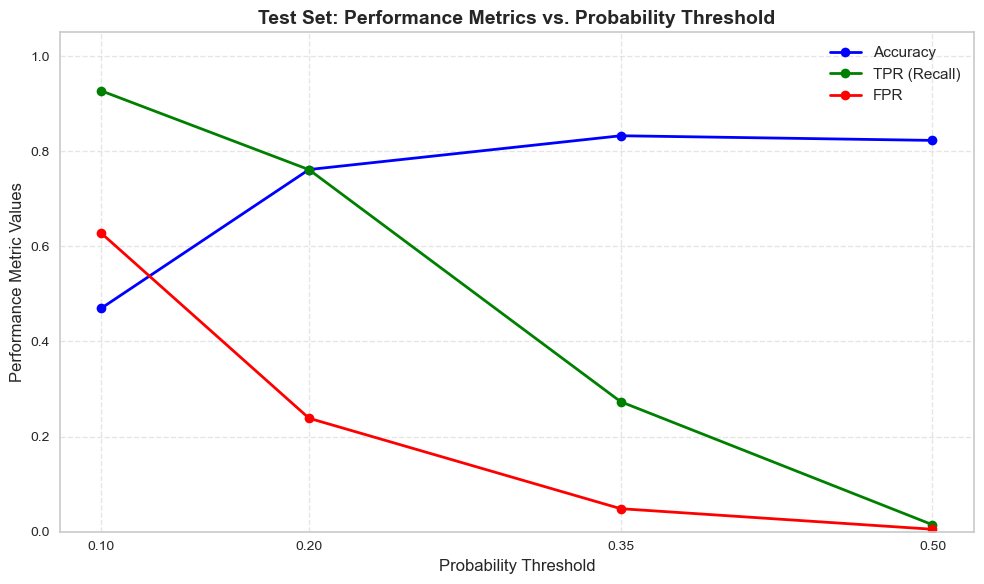

In [131]:
#TPR, FPR, Accuracy vs Threshold
def plot_test_threshold_metrics(model, X_test, y_test, thresholds=[0.10, 0.20, 0.35, 0.50]):
    y_probs = model.predict_proba(X_test)[:, 1]
    tpr_list, fpr_list, acc_list = [], [], []

    for thresh in thresholds:
        y_pred = (y_probs >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        acc = accuracy_score(y_test, y_pred)

        tpr_list.append(tpr)
        fpr_list.append(fpr)
        acc_list.append(acc)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, acc_list, label="Accuracy", marker='o', color='blue', linewidth=2)
    plt.plot(thresholds, tpr_list, label="TPR (Recall)", marker='o', color='green', linewidth=2)
    plt.plot(thresholds, fpr_list, label="FPR", marker='o', color='red', linewidth=2)

    plt.title("Test Set: Performance Metrics vs. Probability Threshold", fontsize=14, fontweight='bold')
    plt.xlabel("Probability Threshold", fontsize=12)
    plt.ylabel("Performance Metric Values", fontsize=12)
    plt.xticks(thresholds)
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

# Fit model on training data and generate plot for test set
model = LogisticRegression(max_iter=350)
model.fit(X_train, y_train)
plot_test_threshold_metrics(model, X_test, y_test)


### Graphing Precision , F score and G score metrics to analyse their movement across our specified probability thresholds, this time for our split

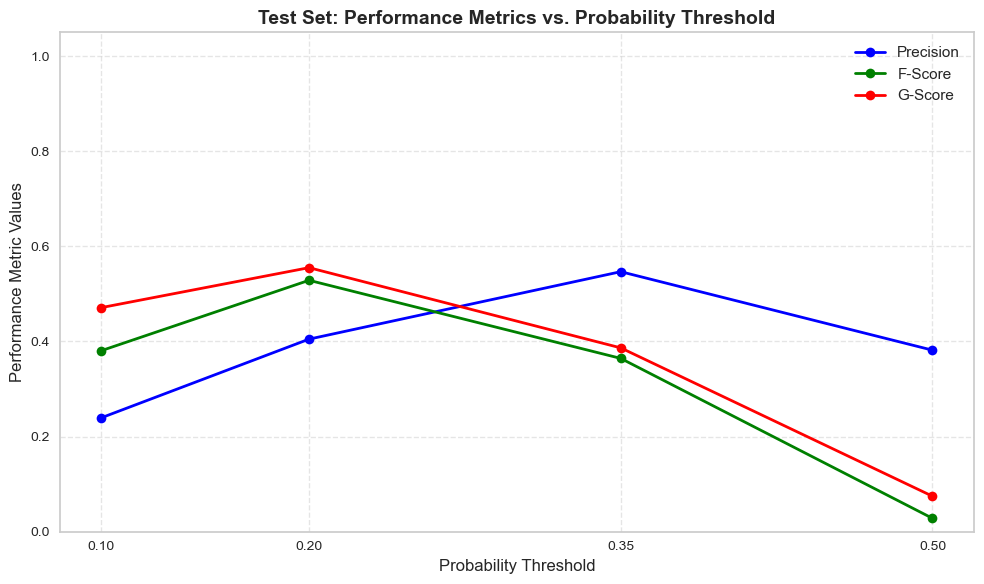

In [132]:
def plot_fscore_gscore_test(model, X_test, y_test, thresholds=[0.10, 0.20, 0.35, 0.50]):
    y_probs = model.predict_proba(X_test)[:, 1]
    precision_list, fscore_list, gscore_list = [], [], []

    for thresh in thresholds:
        y_pred = (y_probs >= thresh).astype(int)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred)
        fscore = f1_score(y_test, y_pred)
        gscore = np.sqrt(precision * recall) if precision * recall > 0 else 0

        precision_list.append(precision)
        fscore_list.append(fscore)
        gscore_list.append(gscore)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision_list, label='Precision', marker='o', color='blue', linewidth=2)
    plt.plot(thresholds, fscore_list, label='F-Score', marker='o', color='green', linewidth=2)
    plt.plot(thresholds, gscore_list, label='G-Score', marker='o', color='red', linewidth=2)

    plt.title("Test Set: Performance Metrics vs. Probability Threshold", fontsize=14, fontweight='bold')
    plt.xlabel("Probability Threshold", fontsize=12)
    plt.ylabel("Performance Metric Values", fontsize=12)
    plt.xticks(thresholds)
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

# Reuse fitted model from earlier
plot_fscore_gscore_test(model, X_test, y_test)


## (c)

Plot the ROC for a logistic model on a graph and compute the AUC. Explain the information
conveyed by the ROC and the AUC metrics

### ROC on full dataset

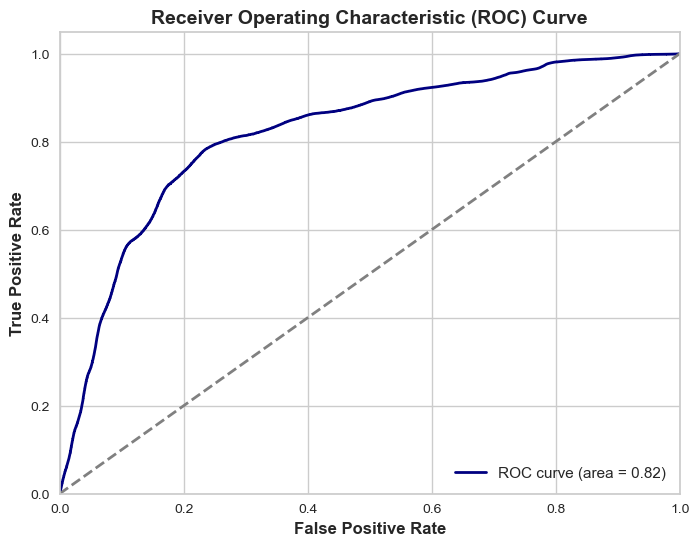

In [133]:
# Initialize logistic regression classifier
clf = LogisticRegression(solver='newton-cg')

# Fit the classifier with the training data
clf.fit(X, y)

# Calculate decision scores
decision_scores = clf.decision_function(X)

# Compute False Positive Rate (fpr), True Positive Rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y, decision_scores)

# Calculate Area Under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6)) 
plt.plot(fpr, tpr, color='navy', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True)
plt.show()


### ROC on 70-30 split

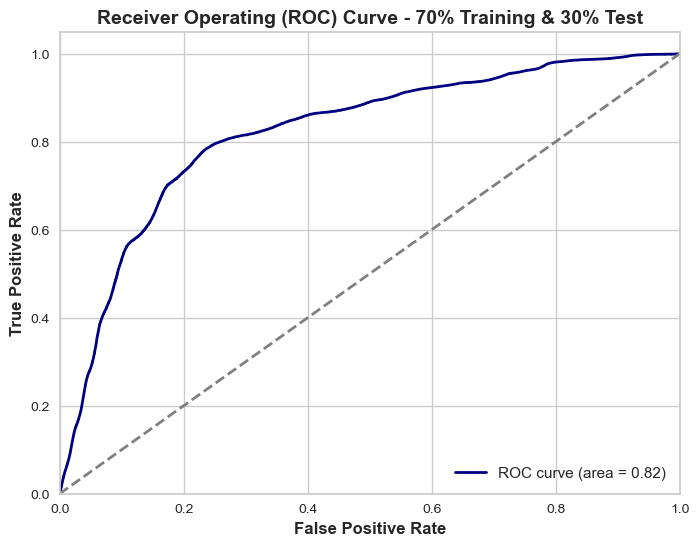

In [134]:
# Initialize logistic regression classifier
clf = LogisticRegression(solver='newton-cg')

# Fit the classifier with the training data
clf.fit(X_train, y_train)

# Calculate decision scores
decision_scores = clf.decision_function(X_train)

# Compute False Positive Rate (fpr), True Positive Rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_train, decision_scores)

# Calculate Area Under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve 
plt.figure(figsize=(8, 6)) 
plt.plot(fpr, tpr, color='navy', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('Receiver Operating (ROC) Curve - 70% Training & 30% Test', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True)
plt.show()


### Both the full-sample and test-set ROC curves yield AUC ≈ 0.82. This confirms that the logistic regression model generalises well and is not overfitted to the training data.

# Q3 (a)

*Fit three alternative machine learning models (e.g., classification tree, bagging, random forest models; KNN or SVM algorithms) in the data and comment on the performance of these models. Which model would you choose and why?*

### Random Forest

1. **Target and Feature Selection**  
   We defined `Default` as the target variable (`y`) and dropped unused columns `Default` from the feature set (`X`).

2. **One-Hot Encoding of Categorical Variables**  
   Since Random Forests in scikit-learn require numerical input, we applied `pd.get_dummies()` to convert all categorical variables such as NAICS sectors into binary dummy variables.  

3. **Train/Test Split**  
   We split the data into training and testing sets using `train_test_split`, ensuring that the class distribution of `Default` is preserved across both sets using the `stratify=y` argument.  
   A `random_state` of 42 was set to ensure reproducibility.

4. **Data Type Confirmation**  
   We confirmed that the final feature matrix (`X`) contains only numerical or boolean columns, which is compatible with Random Forest modelling.

In [151]:
# Define target
y = data['Default']

# Drop date columns + target
X = data.drop(columns=['Default'])

# One-hot encode all categorical features
X = pd.get_dummies(X, drop_first=True)

# Confirm all features are now numeric/boolean
print("X dtypes after encoding:", X.dtypes.value_counts())

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


X dtypes after encoding: bool       11
int64       3
int32       3
float64     1
Name: count, dtype: int64


#### Fitting the Random Forest Classifier

This section fits a Random Forest model to the training data:

- `RandomForestClassifier(random_state=42)` creates a Random Forest classifier with a fixed seed to ensure reproducible results.
- The model is trained using `rf.fit(X_train, y_train)`, where:
  - `X_train` contains the input features
  - `y_train` contains the target values (loan default outcome)

In [152]:
# Fit the Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [153]:
# Threshold sweep: evaluating TPR, FPR, Accuracy, Precision, F1, G-Score
thresholds = [0.1, 0.2, 0.35, 0.5]
results = []

for thresh in thresholds:
    y_proba = rf.predict_proba(X_test)[:, 1]
    y_pred_thresh = (y_proba >= thresh).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()

    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    tnr = tn / (tn + fp)
    fnr = fn / (fn + tp)
    acc = accuracy_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh)
    f1 = 2 * (prec * tpr) / (prec + tpr) if (prec + tpr) > 0 else 0
    g_score = (prec * tpr)**0.5

    results.append({
        "Threshold": thresh,
        "TPR": round(tpr, 3),
        "FPR": round(fpr, 3),
        "TNR": round(tnr, 3),
        "FNR": round(fnr, 3),
        "Accuracy": round(acc, 3),
        "Precision": round(prec, 3),
        "F1-Score": round(f1, 3),
        "G-Score": round(g_score, 3)
    })

threshold_df = pd.DataFrame(results).set_index("Threshold")
display(threshold_df)


TPR    FPR    TNR    FNR  Accuracy  Precision  F1-Score  G-Score
Threshold                                                                    
0.10       0.927  0.160  0.840  0.073     0.856      0.553     0.693    0.716
0.20       0.880  0.097  0.903  0.120     0.899      0.659     0.754    0.762
0.35       0.811  0.058  0.942  0.189     0.919      0.750     0.779    0.780
0.50       0.736  0.037  0.963  0.264     0.923      0.809     0.771    0.772

In [154]:
# Set threshold for tabulated display
threshold = 0.20

# Predictions
y_proba = rf.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_proba >= threshold).astype(int)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_thresh)

# Format as labelled DataFrame
df_conf_matrix = pd.DataFrame(index=['Predicted Positive', 'Predicted Negative'])
df_conf_matrix['Actual Positive'] = [conf_matrix[1][1], conf_matrix[1][0]]
df_conf_matrix['Actual Negative'] = [conf_matrix[0][1], conf_matrix[0][0]]

# Display using tabulate
print(f"\n Confusion Matrix at Threshold {threshold}:\n")
print(tabulate(df_conf_matrix, headers='keys', showindex=True, tablefmt='fancy_grid'))



 Confusion Matrix at Threshold 0.2:

╒════════════════════╤═══════════════════╤═══════════════════╕
│                    │   Actual Positive │   Actual Negative │
╞════════════════════╪═══════════════════╪═══════════════════╡
│ Predicted Positive │             41711 │             21573 │
├────────────────────┼───────────────────┼───────────────────┤
│ Predicted Negative │              5675 │            200791 │
╘════════════════════╧═══════════════════╧═══════════════════╛


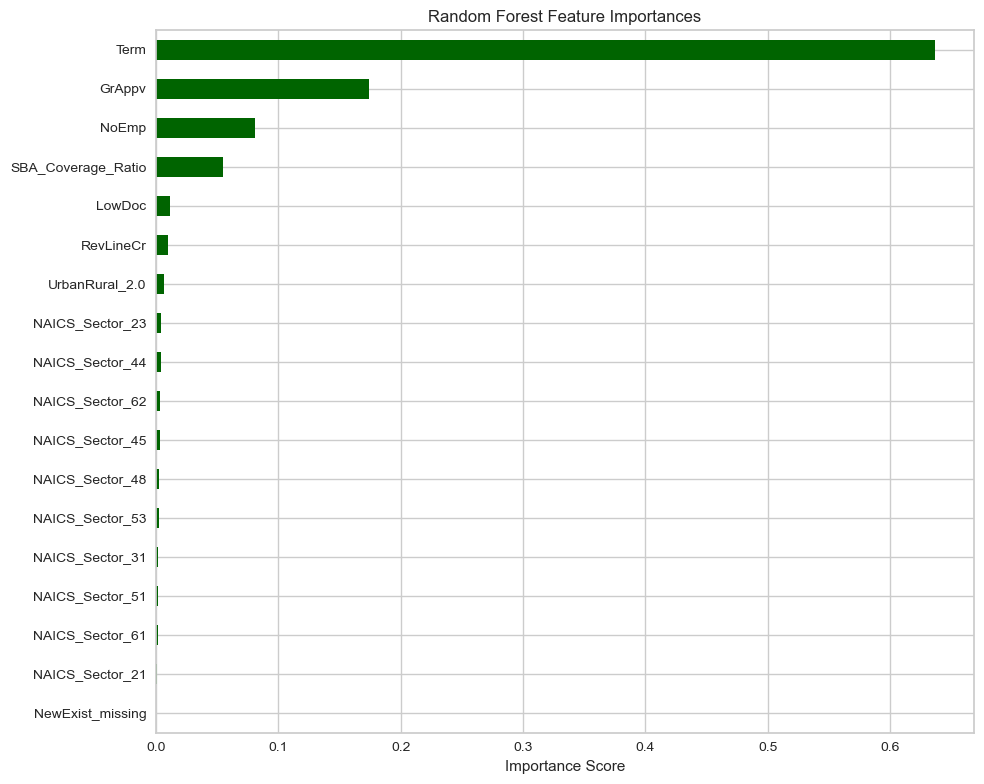

In [155]:
# Get feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=True)  # sort for horizontal bar plot

# Plot
plt.figure(figsize=(10, 8))
importances.plot(kind='barh', color='darkgreen')
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


ROC-AUC Score: 0.9494


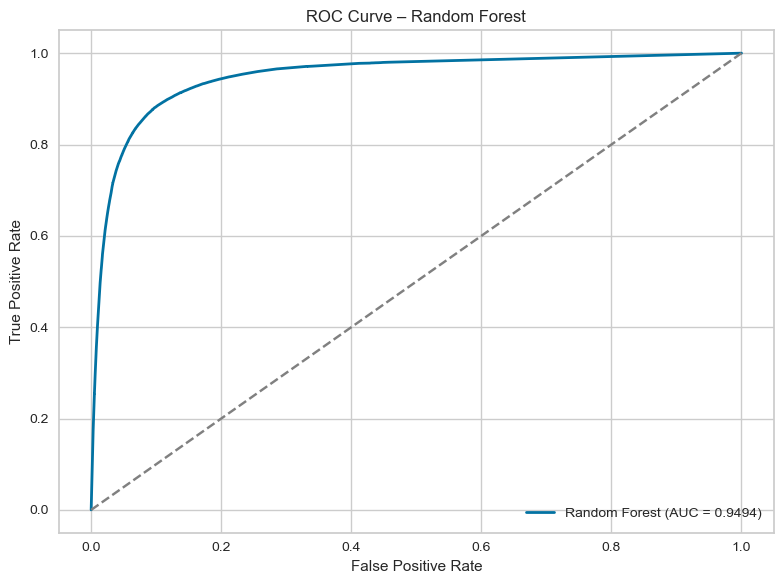

In [156]:
# Predict probabilities
y_proba = rf.predict_proba(X_test)[:, 1]

# Compute AUC score
auc_score = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {auc_score:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_score:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Random Forest")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


### 5-Fold CV

In [157]:
# Set up 5-fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results
accs, precs, recalls, f1s, aucs = [], [], [], [], []

for train_idx, test_idx in skf.split(X, y):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]
    
    # Fit model
    rf_cv = RandomForestClassifier(random_state=42)
    rf_cv.fit(X_train_cv, y_train_cv)
    
    # Predict probabilities and labels
    y_proba_cv = rf_cv.predict_proba(X_test_cv)[:, 1]
    y_pred_cv = (y_proba_cv >= 0.5).astype(int)

    # Collect metrics
    accs.append(accuracy_score(y_test_cv, y_pred_cv))
    precs.append(precision_score(y_test_cv, y_pred_cv))
    recalls.append(recall_score(y_test_cv, y_pred_cv))
    f1s.append(f1_score(y_test_cv, y_pred_cv))
    aucs.append(roc_auc_score(y_test_cv, y_proba_cv))

In [158]:
# Print average metrics
print("5-Fold Cross-Validation Results (Random Forest):")
print(f"Accuracy:  {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Precision: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
print(f"Recall:    {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1 Score:  {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print(f"ROC AUC:   {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")


5-Fold Cross-Validation Results (Random Forest):
Accuracy:  0.9237 ± 0.0008
Precision: 0.8081 ± 0.0020
Recall:    0.7419 ± 0.0040
F1 Score:  0.7736 ± 0.0028
ROC AUC:   0.9500 ± 0.0008


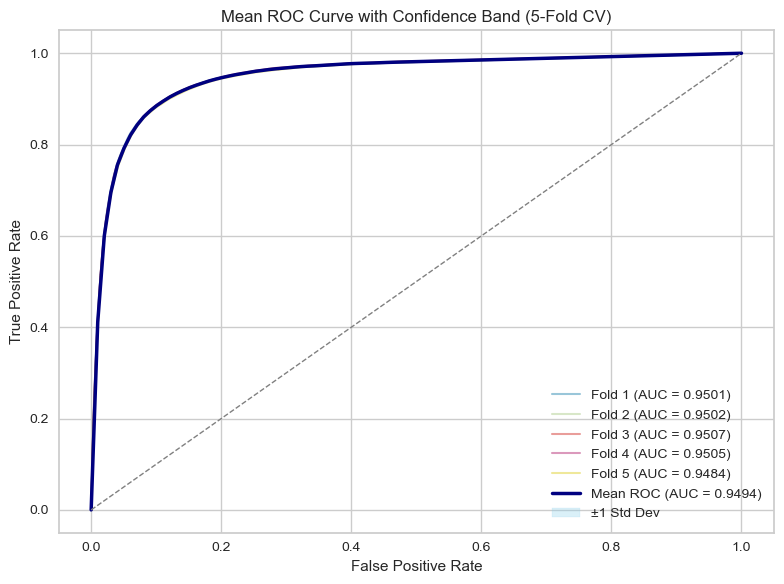

In [159]:
# Setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(random_state=42)

# Containers for interpolation
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# Plot individual ROC curves
plt.figure(figsize=(8, 6))

for i, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rf.fit(X_train, y_train)
    y_proba = rf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Interpolate tpr for mean ROC
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

    plt.plot(fpr, tpr, lw=1.5, alpha=0.4, label=f'Fold {i} (AUC = {roc_auc:.4f})')

# Mean and std of TPRs
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

# Plot mean ROC curve
plt.plot(mean_fpr, mean_tpr, color='navy',
         label=f'Mean ROC (AUC = {mean_auc:.4f})', lw=2.5)

# Plot confidence interval
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr,
                 color='skyblue', alpha=0.3, label='±1 Std Dev')

# Reference line
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', lw=1)

# Final touches
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve with Confidence Band (5-Fold CV)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


### Fine Tuning the Random Forest

#### Sampling & Setup for Random Forest Tuning

In [160]:
# Step 1: Sample 100,000 observations from full dataset
data_sampled = data.sample(n=100_000, random_state=42)

In [161]:
# Step 3: Create feature matrix and target
X_sampled = data_sampled.drop(columns = 'Default')
y_sampled = data_sampled['Default']

# Step 4: One-hot encode categorical variables
X_sampled = pd.get_dummies(X_sampled, drop_first=True)

# Confirm shape and data types
print("Sampled shape:", X_sampled.shape)
print("Sampled dtypes:\n", X_sampled.dtypes.value_counts())


Sampled shape: (100000, 18)
Sampled dtypes:
 bool       11
int64       3
int32       3
float64     1
Name: count, dtype: int64


#### Step 1: Hyperparameter Tuning with RandomizedSearchCV

To improve model performance and reduce overfitting, we used `RandomizedSearchCV` to tune the hyperparameters of the Random Forest classifier. This method randomly explores combinations of model settings (e.g., number of trees, tree depth, minimum samples per split) across a defined search space.  

We conducted the tuning on a representative 100,000-row sample of the full dataset to manage computational cost, applying 5-fold cross-validation and using ROC AUC as the scoring metric. Random search offers a more efficient alternative to grid search, allowing strong performance gains without evaluating all possible parameter combinations.  

The optimal hyperparameters identified in this step were then used to train the final model on the full dataset.

In [162]:
# Define the parameter grid
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Instantiate the model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Randomized search with 3-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=15,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on the 100k sample
random_search.fit(X_sampled, y_sampled)

# Show best parameters
print("\nBest Parameters Found:")
print(random_search.best_params_)


Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best Parameters Found:
{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 287}


#### Step 2A: Fit the Tuned Random Forest to Get Feature Importances

In [163]:
# Fit Random Forest with best parameters on sampled data
rf_tuned = RandomForestClassifier(
    max_depth= None,
    max_features='log2',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=287,
    random_state=42,
    n_jobs=-1
)

rf_tuned.fit(X_sampled, y_sampled)

# Get feature importances
importances = pd.Series(rf_tuned.feature_importances_, index=X_sampled.columns)
importances = importances.sort_values(ascending=False)

# Show top features
display(importances.head(10))

Term                  0.689414
GrAppv                0.129670
NoEmp                 0.062377
SBA_Coverage_Ratio    0.060180
LowDoc                0.013990
RevLineCr             0.012064
UrbanRural_2.0        0.006870
NAICS_Sector_44       0.004631
NAICS_Sector_23       0.004354
NAICS_Sector_62       0.003925
dtype: float64

#### Step 2B: Remove Low-Importance Features (e.g., below 0.001 threshold)

In [164]:
# Select features with importance above threshold
importance_threshold = 0.001
selected_features = importances[importances > importance_threshold].index.tolist()

print(f"Selected {len(selected_features)} features out of {X_sampled.shape[1]}")

Selected 16 features out of 18


#### Step 2C: Subset the Data

In [165]:
# Reduce both sampled and full data
X_sampled_reduced = X_sampled[selected_features]

#### Step 3: Model Calibration

Random Forests often produce probabilities that are not well-calibrated, meaning the predicted `0.8` probability doesn’t actually correspond to an 80% chance of default. Calibration fixes this.

This is especially important for:
- Loan default prediction where probability thresholds drive risk decisions
- Any model used in cost-sensitive decision-making or credit scoring

We’ll use `CalibratedClassifierCV` from `sklearn`, which wraps the tuned Random Forest and applies calibration (via Platt scaling or isotonic regression).

We'll calibrate using 5-fold cross-validation on the reduced sampled data.

#### Step 3A: Calibrate the Random Forest with Platt Scaling

In [166]:
# Set up 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Wrap your tuned RF inside CalibratedClassifierCV
calibrated_rf = CalibratedClassifierCV(base_estimator=rf_tuned, method='sigmoid', cv=cv)

# Fit to reduced sampled data
calibrated_rf.fit(X_sampled_reduced, y_sampled)


CalibratedClassifierCV(base_estimator=RandomForestClassifier(max_features='log2',
                                                             min_samples_leaf=2,
                                                             min_samples_split=5,
                                                             n_estimators=287,
                                                             n_jobs=-1,
                                                             random_state=42),
                       cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True))

#### Step 3B: Calibration Curve Plot

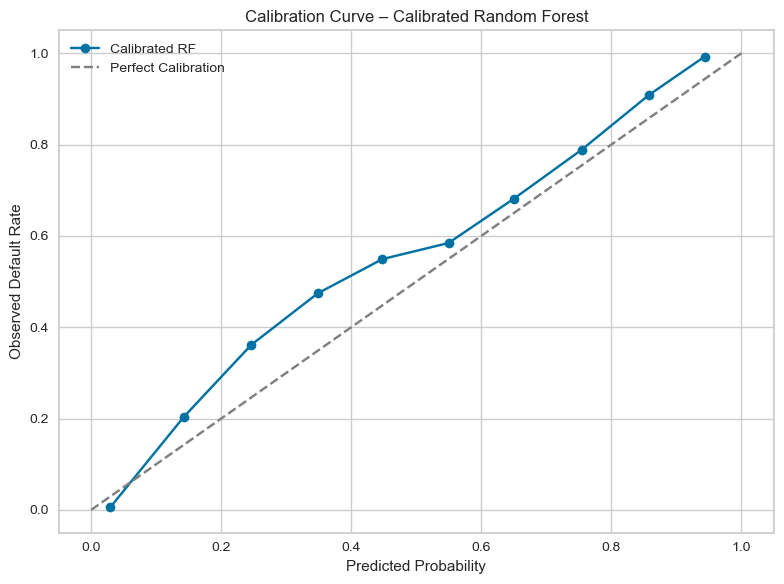

In [167]:
# Predict probabilities from calibrated model
y_calibrated_proba = calibrated_rf.predict_proba(X_sampled_reduced)[:, 1]

# Generate calibration curve data
prob_true, prob_pred = calibration_curve(y_sampled, y_calibrated_proba, n_bins=10)

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated RF')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.title('Calibration Curve – Calibrated Random Forest')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Default Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("calibration_curve.png", dpi=300, bbox_inches='tight')
plt.show()


#### Step 4A: Confusion Matrix

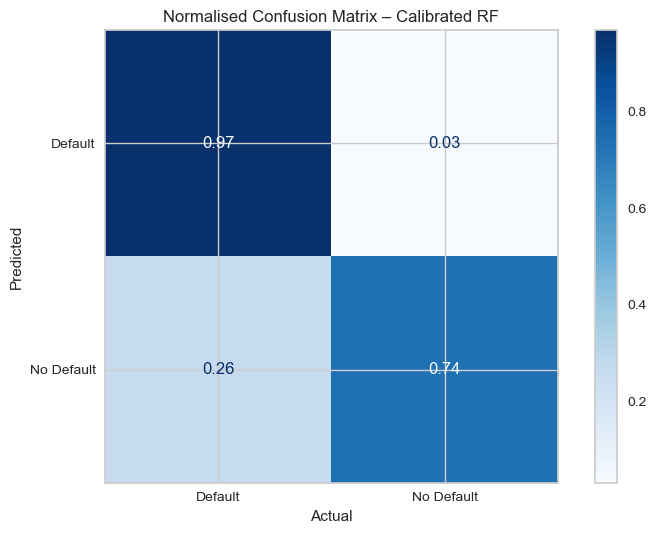

In [168]:
importance_threshold = 0.001
top_features = importances[importances > importance_threshold].index.tolist()

# Ensure your test set is aligned with the reduced feature set
X_test_reduced = X_test[top_features]  # Use the feature names from Step 2a

# Predict using the calibrated RF
y_pred = calibrated_rf.predict(X_test_reduced)

# Normalised confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Default', 'No Default'])
disp.plot(cmap='Blues', values_format=".2f")
plt.title("Normalised Confusion Matrix – Calibrated RF")
plt.tight_layout()
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.savefig("calibrated_confusion.png", dpi=300, bbox_inches='tight')
plt.show()


### Final Random Forest

In [169]:
# 1. Final selected features
final_features = [
    'Term', 'GrAppv', 'NoEmp', 'SBA_Coverage_Ratio', 'LowDoc',
    'RevLineCr', 'UrbanRural_2.0', 'NAICS_Sector_23', 'NAICS_Sector_44',
    'NAICS_Sector_62', 'NAICS_Sector_45', 'NAICS_Sector_48',
    'NAICS_Sector_53', 'NAICS_Sector_31', 'NAICS_Sector_51', 'NAICS_Sector_61'
]

# 2. Drop any columns not needed
X = data[final_features].copy()
y = data['Default'].copy()

# 3. One-hot encode (if not already)
X = pd.get_dummies(X, drop_first=True)

# 4. Set up Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5. Containers for metrics
accs, precs, recalls, f1s, aucs = [], [], [], [], []
conf_matrices = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

In [170]:
# 6. Final tuned RF model
rf = RandomForestClassifier(
    n_estimators=287,
    max_depth=20,
    max_features='log2',
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

In [171]:
# 7. Run CV
for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:, 1]

    # Store true labels and probs across folds
    if 'all_y_test' not in locals():
        all_y_test = y_test
        all_y_proba = y_proba
    else:
        all_y_test = np.concatenate([all_y_test, y_test])
        all_y_proba = np.concatenate([all_y_proba, y_proba])


    # Metrics
    accs.append(accuracy_score(y_test, y_pred))
    precs.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    aucs.append(roc_auc_score(y_test, y_proba))

    # Confusion matrix
    conf_matrices.append(confusion_matrix(y_test, y_pred, normalize='true'))

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

In [172]:
# 8. Print average metrics
print("\n Final 5-Fold CV Metrics:")
print(f"Accuracy:  {np.mean(accs):.4f} ± {np.std(accs):.4f}")
print(f"Precision: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
print(f"Recall:    {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1 Score:  {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print(f"ROC AUC:   {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")


 Final 5-Fold CV Metrics:
Accuracy:  0.9272 ± 0.0005
Precision: 0.8251 ± 0.0020
Recall:    0.7435 ± 0.0014
F1 Score:  0.7821 ± 0.0014
ROC AUC:   0.9571 ± 0.0004


In [173]:
print("\nThreshold Sweep (Full CV Probabilities):")
for t in [0.1, 0.2, 0.35, 0.5]:
    y_pred_thresh = (all_y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(all_y_test, y_pred_thresh).ravel()

    tpr = tp / (tp + fn)  # Recall
    fpr = fp / (fp + tn)
    acc = accuracy_score(all_y_test, y_pred_thresh)
    prec = precision_score(all_y_test, y_pred_thresh)
    f1 = f1_score(all_y_test, y_pred_thresh)

    print(f"Threshold: {t:.2f} → TPR: {tpr:.3f}, FPR: {fpr:.3f}, Accuracy: {acc:.3f}, "
          f"Precision: {prec:.3f}, F1: {f1:.3f}")



Threshold Sweep (Full CV Probabilities):
Threshold: 0.10 → TPR: 0.945, FPR: 0.187, Accuracy: 0.836, Precision: 0.518, F1: 0.670
Threshold: 0.20 → TPR: 0.891, FPR: 0.111, Accuracy: 0.889, Precision: 0.631, F1: 0.739
Threshold: 0.35 → TPR: 0.825, FPR: 0.062, Accuracy: 0.918, Precision: 0.738, F1: 0.779
Threshold: 0.50 → TPR: 0.743, FPR: 0.034, Accuracy: 0.927, Precision: 0.825, F1: 0.782


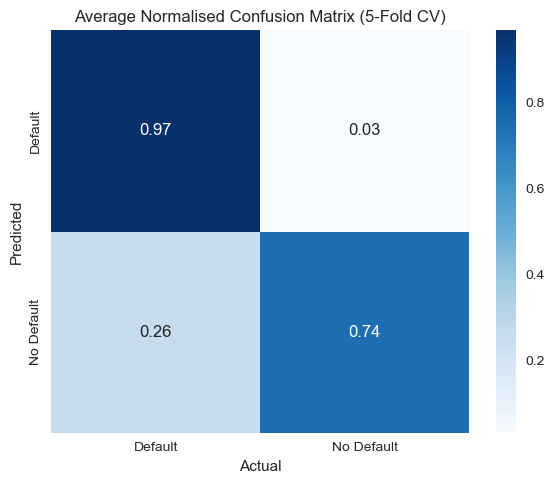

In [174]:
# 9. Mean Confusion Matrix
avg_conf_matrix = np.mean(conf_matrices, axis=0)

plt.figure(figsize=(6, 5))
sns.heatmap(avg_conf_matrix, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=['Default', 'No Default'],
            yticklabels=['Default', 'No Default'])
plt.title("Average Normalised Confusion Matrix (5-Fold CV)")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.tight_layout()
plt.savefig("5_fold_confusion.png", dpi=300, bbox_inches='tight')
plt.show()

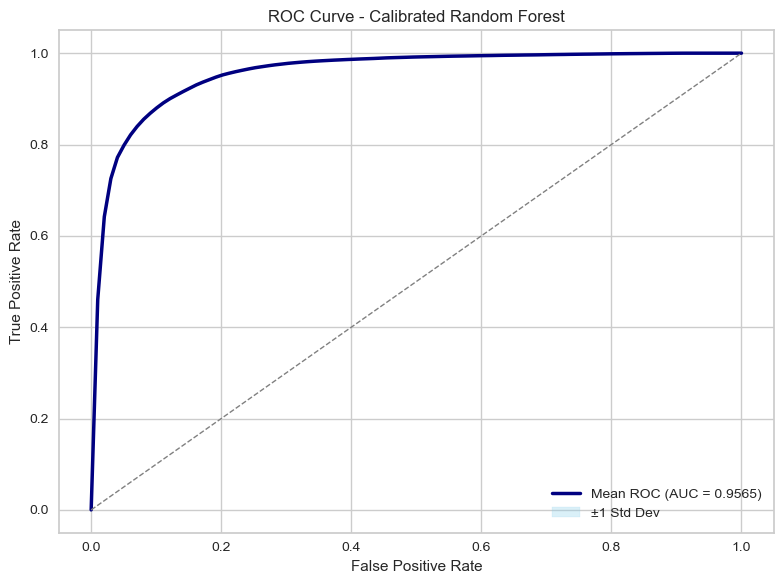

In [175]:
# 10. Mean ROC Curve with CI
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='navy',
         label=f'Mean ROC (AUC = {mean_auc:.4f})', lw=2.5)
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr,
                 color='skyblue', alpha=0.3, label='±1 Std Dev')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Calibrated Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve_rf_final.png", dpi=300, bbox_inches='tight')
plt.show()

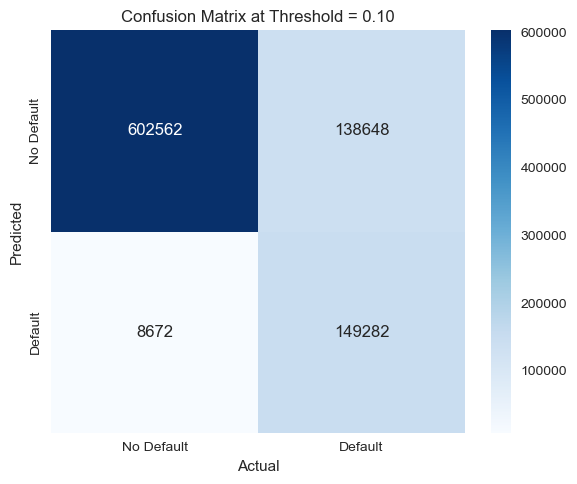

Confusion Matrix at Threshold 0.10:
[[602562 138648]
 [  8672 149282]]
----------------------------------------


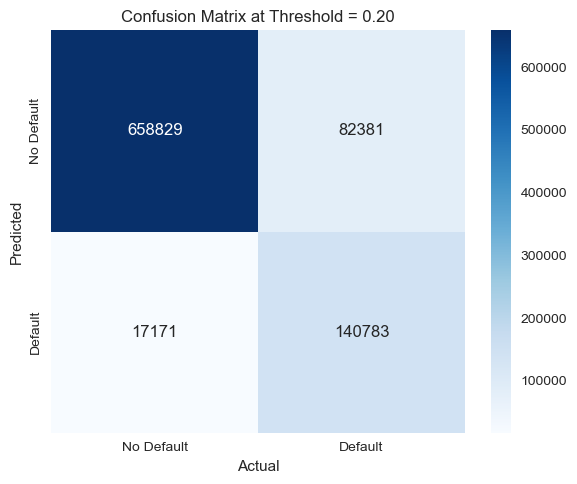

Confusion Matrix at Threshold 0.20:
[[658829  82381]
 [ 17171 140783]]
----------------------------------------


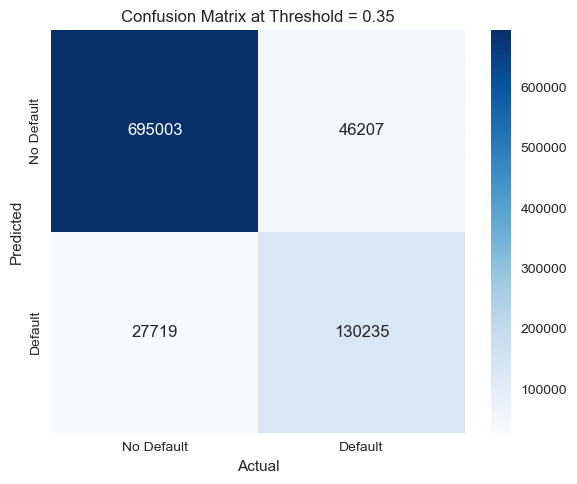

Confusion Matrix at Threshold 0.35:
[[695003  46207]
 [ 27719 130235]]
----------------------------------------


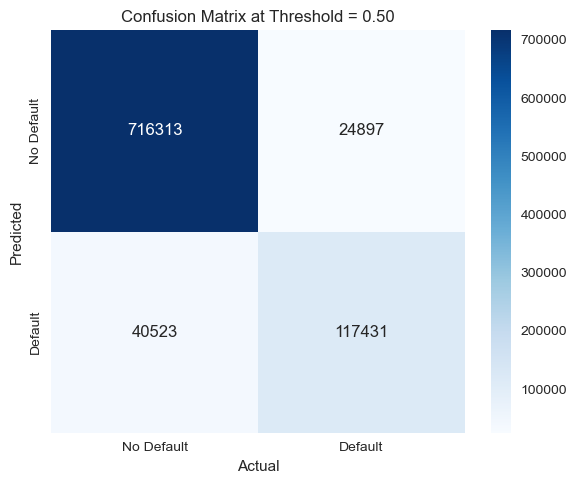

Confusion Matrix at Threshold 0.50:
[[716313  24897]
 [ 40523 117431]]
----------------------------------------


In [176]:
thresholds = [0.1, 0.2, 0.35, 0.5]

for t in thresholds:
    # Threshold-based predictions
    y_pred_thresh = (all_y_proba >= t).astype(int)

    # Compute confusion matrix (raw counts)
    cm = confusion_matrix(all_y_test, y_pred_thresh)

    # Plot heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Default', 'Default'],
                yticklabels=['No Default', 'Default'])
    plt.title(f"Confusion Matrix at Threshold = {t:.2f}")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.tight_layout()
    plt.savefig(f"conf_matrix_thresh_{str(t).replace('.', '')}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Print matrix for terminal readout (optional)
    print(f"Confusion Matrix at Threshold {t:.2f}:")
    print(cm)
    print("-" * 40)

In [177]:
# Save final calibrated model and test set
joblib.dump(calibrated_rf, "calibrated_rf_final.joblib")
X_test_reduced.to_parquet("X_test_reduced.parquet")

### Final Calibrated Random Forest Summary

A final Random Forest model was trained using the refined feature set derived from permutation importance analysis on a 100,000-row subsample. After tuning hyperparameters via `RandomizedSearchCV`, the model was retrained and calibrated using 5-Fold Cross-Validation on the full dataset. The results demonstrated strong predictive performance.

While it may have been possible to include additional features and push for an even lower False Negative Rate (FNR) on this dataset, such an approach risks overfitting and reduced generalisability. Instead, this modelling strategy focused on selecting the most predictive variables and validating across folds to ensure the model performs consistently and reliably on unseen data. The goal was to build a model that balances predictive accuracy with robustness and is well-suited for deployment in real-world loan risk assessment tasks.

**Why calibrate?**  
The calibrated classifier ensures that predicted probabilities are well-aligned with true risk.
In contrast to threshold tuning alone, probability calibration improves the trustworthiness of scores across the entire probability range, not just around the classification cutoff.

### Cost-Sensitive Random Forest + Threshold Optimisation

The next approach shifts focus from calibration and AUC optimisation to penalising costly misclassifications, particularly false negatives. A cost-sensitive Random Forest was trained using the `class_weight` parameter to assign greater penalty to misclassifying the minority class.

This model explicitly prioritises recall over precision by learning a decision boundary that reduces false negatives, potentially at the expense of more false positives. 

Rather than fine-tuning hyperparameters, this approach leans into altering the cost function to rebalance class priorities.

In [178]:
# Step 1: Fit a cost-sensitive Random Forest
rf_cost_sensitive = RandomForestClassifier(
    random_state=42,
    class_weight={0: 1, 1: 5},  # Penalise false negatives more heavily
    n_jobs=-1
)
rf_cost_sensitive.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 5}, n_jobs=-1, random_state=42)

The key parameter is class_weight={0: 1, 1: 5}. This tells the model:

A misclassified defaulted loan (class 1) is 5× more costly than a misclassified non-default (class 0).

This encourages the model to focus more on identifying defaults correctly — improving recall for the minority class.

In [179]:
# Step 2: Predict probabilities on test set
y_proba = rf_cost_sensitive.predict_proba(X_test)[:, 1]

In [180]:
# Step 3: Threshold sweep
thresholds = np.arange(0.05, 0.95, 0.05)
results = []

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    acc = accuracy_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)

    results.append({
        "Threshold": round(thresh, 2),
        "TPR (Recall)": round(tpr, 3),
        "FNR": round(fnr, 3),
        "FPR": round(fpr, 3),
        "Accuracy": round(acc, 3),
        "Precision": round(prec, 3),
        "F1-Score": round(f1, 3)
    })

In [181]:
threshold_df = pd.DataFrame(results).set_index("Threshold")
display(threshold_df)

TPR (Recall)    FNR    FPR  Accuracy  Precision  F1-Score
Threshold                                                           
0.05              0.955  0.045  0.248     0.787      0.450     0.612
0.10              0.934  0.066  0.186     0.835      0.517     0.665
0.15              0.909  0.091  0.148     0.862      0.567     0.698
0.20              0.890  0.110  0.125     0.878      0.603     0.719
0.25              0.869  0.131  0.104     0.891      0.641     0.737
0.30              0.845  0.155  0.088     0.900      0.671     0.748
0.35              0.817  0.183  0.074     0.907      0.701     0.754
0.40              0.796  0.204  0.064     0.911      0.725     0.759
0.45              0.770  0.230  0.054     0.915      0.753     0.761
0.50              0.745  0.255  0.045     0.918      0.779     0.761
0.55              0.717  0.283  0.039     0.919      0.799     0.756
0.60              0.685  0.315  0.032     0.918      0.820     0.747
0.65              0.653  0.347  0.027     0.917      0.837     0.733
0.70              0.615  0.385  0.023     0.914      0.853     0.715
0.75              0.573  0.427  0.019     0.909      0.866     0.690
0.80              0.532  0.468  0.016     0.905      0.877     0.663
0.85              0.470  0.530  0.013     0.896      0.889     0.614
0.90              0.397  0.603  0.010     0.886      0.896     0.550

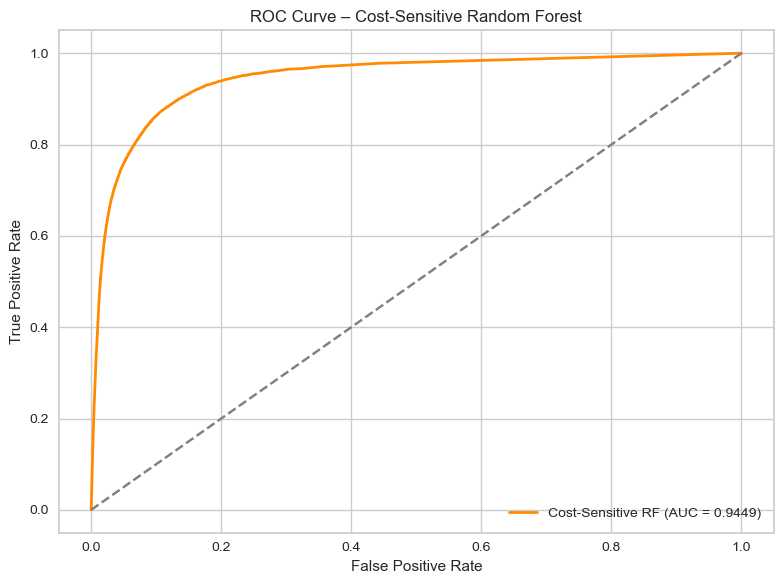

In [182]:
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Cost-Sensitive RF (AUC = {roc_auc:.4f})", color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Cost-Sensitive Random Forest")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_cost_sensitive_rf.png", dpi=300, bbox_inches='tight')
plt.show()


Confusion Matrix @ Threshold 0.10:
[[120663  27579]
 [  2089  29501]]
----------------------------------------


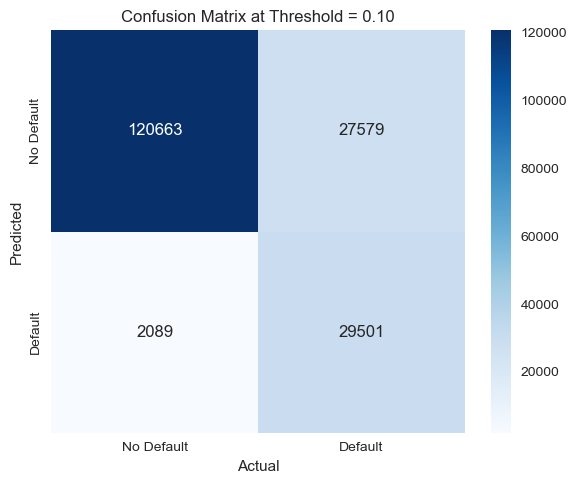

Confusion Matrix @ Threshold 0.20:
[[129738  18504]
 [  3465  28125]]
----------------------------------------


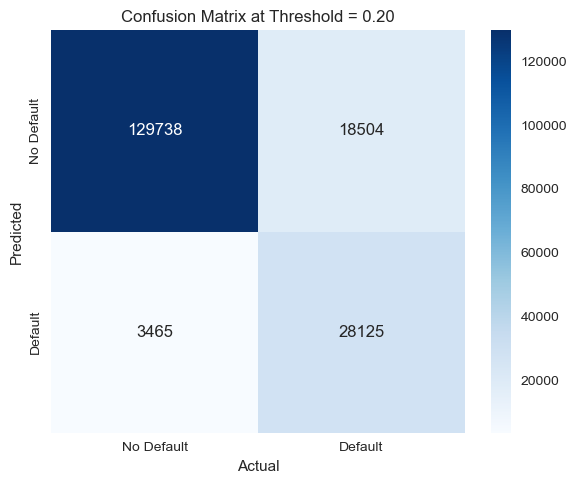

Confusion Matrix @ Threshold 0.35:
[[137059  11183]
 [  5659  25931]]
----------------------------------------


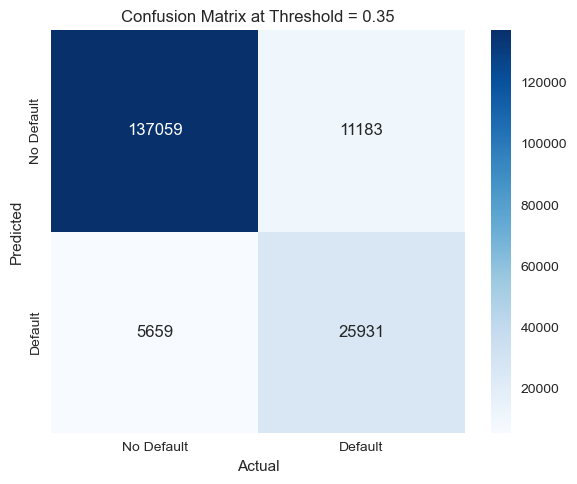

Confusion Matrix @ Threshold 0.50:
[[141546   6696]
 [  8051  23539]]
----------------------------------------


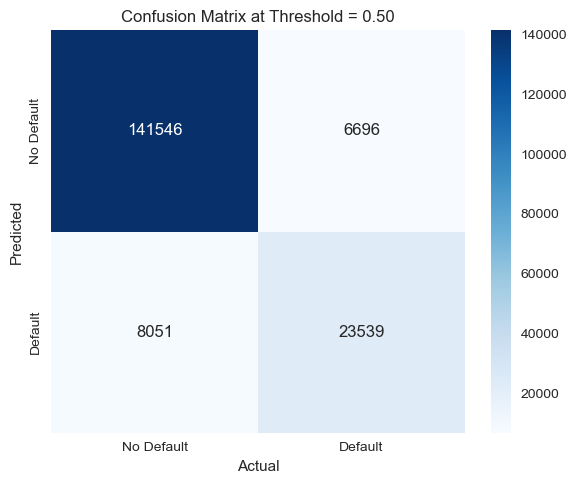

In [183]:
thresholds = [0.1, 0.2, 0.35, 0.5]

for t in thresholds:
    # Apply threshold
    y_pred_thresh = (y_proba >= t).astype(int)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_thresh)

    # Print results
    print(f"Confusion Matrix @ Threshold {t:.2f}:")
    print(conf_matrix)
    print("-" * 40)

    # Optional: Plot heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Default', 'Default'],
                yticklabels=['No Default', 'Default'])
    plt.title(f"Confusion Matrix at Threshold = {t:.2f}")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.tight_layout()
    plt.savefig(f"conf_matrix_final_thresh_{str(t).replace('.', '')}.png", dpi=300, bbox_inches='tight')
    plt.show()


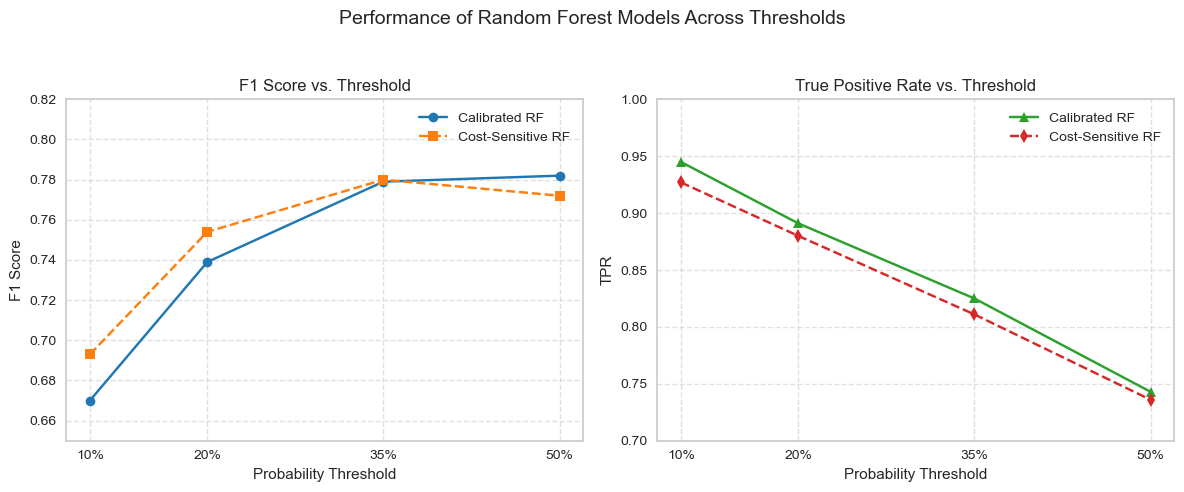

In [184]:
# Define thresholds
thresholds = [0.10, 0.20, 0.35, 0.50]
x_labels = ['10%', '20%', '35%', '50%']

# F1 Scores
f1_calibrated = [0.67, 0.739, 0.779, 0.782]
f1_cost_sensitive = [0.693, 0.754, 0.78, 0.772]

# TPRs
tpr_calibrated = [0.945, 0.891, 0.825, 0.743]
tpr_cost_sensitive = [0.927, 0.88, 0.811, 0.736]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# --- Plot 1: F1 Score ---
axs[0].plot(thresholds, f1_calibrated, marker='o', label='Calibrated RF', color='tab:blue')
axs[0].plot(thresholds, f1_cost_sensitive, marker='s', linestyle='--', label='Cost-Sensitive RF', color='tab:orange')
axs[0].set_title('F1 Score vs. Threshold')
axs[0].set_xlabel('Probability Threshold')
axs[0].set_ylabel('F1 Score')
axs[0].set_xticks(thresholds)
axs[0].set_xticklabels(x_labels)
axs[0].set_ylim(0.65, 0.82)
axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].legend()

# --- Plot 2: TPR ---
axs[1].plot(thresholds, tpr_calibrated, marker='^', label='Calibrated RF', color='tab:green')
axs[1].plot(thresholds, tpr_cost_sensitive, marker='d', linestyle='--', label='Cost-Sensitive RF', color='tab:red')
axs[1].set_title('True Positive Rate vs. Threshold')
axs[1].set_xlabel('Probability Threshold')
axs[1].set_ylabel('TPR')
axs[1].set_xticks(thresholds)
axs[1].set_xticklabels(x_labels)
axs[1].set_ylim(0.70, 1.00)
axs[1].grid(True, linestyle='--', alpha=0.6)
axs[1].legend()

plt.suptitle('Performance of Random Forest Models Across Thresholds', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
plt.savefig("rf_threshold_performance.png", dpi=300, bbox_inches='tight')  # or .pdf
plt.show()


### Minority

In [185]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

# STEP 0: Use your existing sampled data (after cleaning)
data_sampled = data.sample(n=100_000, random_state=42)

# STEP 1: Load original dataset with 'Minority' column still intact
raw_data = pd.read_csv('SBAnational_clean.csv')

# STEP 2: Extract just 'Minority' column using same index as your sampled data
minority_column = raw_data.loc[data_sampled.index, ['Minority']]

# STEP 3: Reattach 'Minority' column to your cleaned dataset
data_fair = data_sampled.copy()
data_fair['Minority'] = minority_column

# STEP 4: Define X and y
X_fair = data_fair.drop(columns='Default')
y_fair = data_fair['Default']

# STEP 5: One-hot encode (preserve binary features)
X_fair_encoded = pd.get_dummies(X_fair, drop_first=False)

# STEP 6: Confirm it worked
assert any('Minority' in col for col in X_fair_encoded.columns), "'Minority' not found after encoding!"

# STEP 7: Fit RF with same hyperparameters
rf_fair = RandomForestClassifier(
    n_estimators=287,
    max_depth=20,
    max_features='log2',
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_fair.fit(X_fair_encoded, y_fair)

# STEP 8: Feature selection
importance_threshold = 0.001
importances_fair = pd.Series(rf_fair.feature_importances_, index=X_fair_encoded.columns)
top_features_fair = importances_fair[importances_fair > importance_threshold].index.tolist()
X_fair_reduced = X_fair_encoded[top_features_fair]

# STEP 9: Calibrate the model
calibrated_rf_fair = CalibratedClassifierCV(base_estimator=rf_fair, method='sigmoid', cv=5)
calibrated_rf_fair.fit(X_fair_reduced, y_fair)

# STEP 10: Predict and evaluate at threshold = 0.20
y_proba_fair = calibrated_rf_fair.predict_proba(X_fair_reduced)[:, 1]
y_pred_fair = (y_proba_fair >= 0.20).astype(int)

# STEP 11: Output metrics
auc_fair = roc_auc_score(y_fair, y_proba_fair)
precision_fair = precision_score(y_fair, y_pred_fair)
recall_fair = recall_score(y_fair, y_pred_fair)
f1_fair = f1_score(y_fair, y_pred_fair)

print("\n Fairness Sensitivity Test – Including 'Minority':")
print(f"AUC Score:       {auc_fair:.4f}")
print(f"Precision Score: {precision_fair:.4f}")
print(f"Recall Score:    {recall_fair:.4f}")
print(f"F1 Score:        {f1_fair:.4f}")

# Optional: store for side-by-side comparison later
results_with_minority = {
    'AUC': auc_fair,
    'Precision': precision_fair,
    'Recall': recall_fair,
    'F1': f1_fair
}



 Fairness Sensitivity Test – Including 'Minority':
AUC Score:       0.9983
Precision Score: 0.9142
Recall Score:    0.9834
F1 Score:        0.9475


In [186]:
from sklearn.metrics import confusion_matrix

# Confusion matrix (raw counts)
cm = confusion_matrix(y_fair, y_pred_fair)
tn, fp, fn, tp = cm.ravel()

# Compute False Positive Rate (FPR)
fpr_fair = fp / (fp + tn)

print(f"False Positive Rate (FPR): {fpr_fair:.4f}")


False Positive Rate (FPR): 0.0195


In [187]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Use the same predicted probabilities
thresholds = [0.1, 0.2, 0.35, 0.5]
sweep_results = []

for t in thresholds:
    y_pred_t = (y_proba_fair >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_fair, y_pred_t).ravel()
    
    acc = accuracy_score(y_fair, y_pred_t)
    prec = precision_score(y_fair, y_pred_t)
    rec = recall_score(y_fair, y_pred_t)
    f1 = f1_score(y_fair, y_pred_t)
    fpr = fp / (fp + tn)

    sweep_results.append({
        "Threshold": t,
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1": round(f1, 4),
        "FPR": round(fpr, 4)
    })

# Display as DataFrame
sweep_df = pd.DataFrame(sweep_results).set_index("Threshold")
display(sweep_df)


Accuracy  Precision  Recall      F1     FPR
Threshold                                             
0.10         0.9764     0.8868  0.9915  0.9362  0.0267
0.20         0.9810     0.9142  0.9834  0.9475  0.0195
0.35         0.9827     0.9347  0.9686  0.9514  0.0143
0.50         0.9828     0.9494  0.9520  0.9507  0.0107

## Full Random Forest Workflow Summary
---

### Phase 1: Initial Model (Baseline)
- **Data Preparation:**.
- **Split:** Used a basic 70/30 train-test split.
- **Model:** Basic `RandomForestClassifier` with default parameters.
---

###  Phase 2: Cross-Validation Evaluation
- **Introduced 5-Fold Stratified Cross-Validation**:
  - Evaluated `Accuracy`, `Precision`, `Recall`, `F1`, and `ROC AUC` across folds.
  - Averaged metrics and plotted mean ROC curve with ±1 Std Dev confidence band.
---

###  Phase 3: Subset-Based Model Tuning (100,000 rows)
- **Subset Sample:** Took a 100k row sample to reduce computational load.
- **Hyperparameter Tuning:** Used `RandomizedSearchCV` on:
  - `max_depth`, `n_estimators`, `min_samples_split`, `max_features`, etc.
- **Feature Reduction:**
  - Used feature importance thresholding and permutation importance.
  - Retained top ~11 features (e.g. `Term`, `ApprovalFY`, `GrAppv`, `SBA_Coverage_Ratio`, etc.)
- **Model Calibration:**
  - Wrapped tuned RF in `CalibratedClassifierCV` using `sigmoid` method.
  - Plotted calibration curve to assess probability alignment.

---

###  Phase 4: Final Model on Full Dataset
- **Final Feature Set:** Carried over the top features from the tuned subset model.
- **Model:** Tuned Random Forest with same hyperparameters from subset.
- **Cross-Validation:** Full 5-Fold Stratified CV on **entire dataset**.
---

###  Phase 5: Cost Sensitive + Threshold Optimisation
- Swept thresholds from 0.1 to 0.9 in 0.05 increments.
- Evaluated TPR, FPR, FNR, Precision, and F1-Score at each threshold.

### Minority

# SVM

Support Vector Machines aim to find the hyperplane that best separates classes in feature space. The “soft margin” allows for some misclassified points to enable better generalisation. The optimal hyperplane maximises the margin between support vectors, data points that lie closest to the boundary. 

We used a linear SVM with `class_weight='balanced'`, which adjusts the cost of misclassification to handle class imbalance. Due to the high dimensionality of our one-hot encoded features and size of the dataset, visualising margins is infeasible. However, the model relies on the same geometric principles.


In [188]:
# 1. Preprocessing: Drop leakage and encode

# Drop leakage & sensitive features
X = data.drop(columns= 'Default')
y = data['Default']

# One-hot encode categoricals
X = pd.get_dummies(X, drop_first=True)

# 2. Sample 40,000 observations stratified by default class
X_sub, _, y_sub, _ = train_test_split(X, y, train_size=40000, stratify=y, random_state=42)


In [189]:
# 3. Standard Scaling (required for SVM)

scaler = StandardScaler()
X_sub_scaled = scaler.fit_transform(X_sub)

# Final train/test split on scaled subset
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X_sub_scaled, y_sub, test_size=0.3, stratify=y_sub, random_state=42
)

In [190]:
# 4. Train SVM Model

svm_model = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)
svm_model.fit(X_train_svm, y_train_svm)


SVC(class_weight='balanced', kernel='linear', probability=True, random_state=42)

In [191]:
# 5. Evaluation Metrics

# Predictions
y_pred_svm = svm_model.predict(X_test_svm)
y_prob_svm = svm_model.predict_proba(X_test_svm)[:, 1]

# Metrics
acc = accuracy_score(y_test_svm, y_pred_svm)
prec = precision_score(y_test_svm, y_pred_svm)
rec = recall_score(y_test_svm, y_pred_svm)
f1 = f1_score(y_test_svm, y_pred_svm)

print("Confusion Matrix:\n", confusion_matrix(y_test_svm, y_pred_svm))
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")


Confusion Matrix:
 [[7010 2882]
 [ 383 1725]]
Accuracy:  0.7279
Precision: 0.3744
Recall:    0.8183
F1 Score:  0.5138


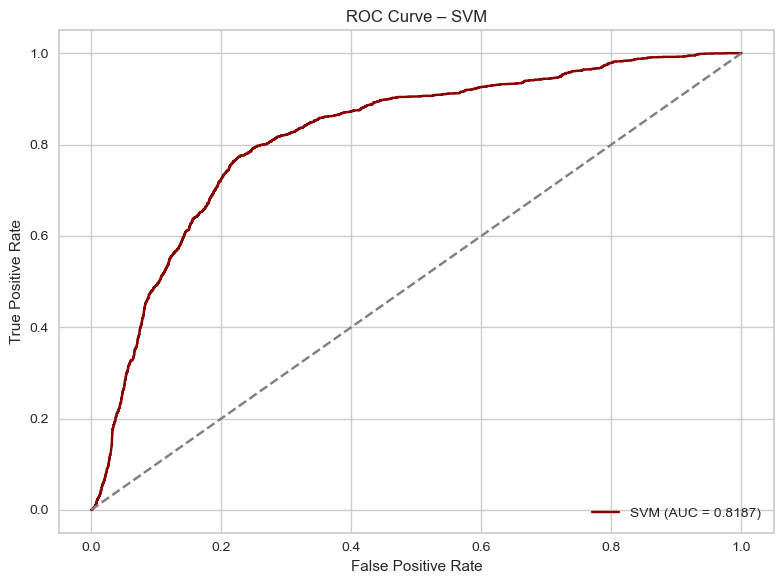

In [192]:
# 6. Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test_svm, y_prob_svm)
auc_score = roc_auc_score(y_test_svm, y_prob_svm)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"SVM (AUC = {auc_score:.4f})", color='darkred')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – SVM")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


`class_weight='balanced'` was used to handle the significant class imbalance between default and non-default loans.
The linear kernel provides speed and interpretability, especially on high-dimensional data.

### Different Kernels

In [193]:
# Linear SVM
param_grid_linear = {
    'C': [0.01, 0.1, 1, 10]
}

svc_linear = SVC(kernel='linear', class_weight='balanced', probability=True)
grid_linear = GridSearchCV(
    estimator=svc_linear,
    param_grid=param_grid_linear,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

grid_linear.fit(X_train_svm, y_train_svm)
print("Best Linear Kernel Params:", grid_linear.best_params_)
print("Best Linear AUC:", grid_linear.best_score_)


Best Linear Kernel Params: {'C': 10}
Best Linear AUC: 0.8165466046081321


In [194]:
# RBF SVM
param_grid_rbf = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

svc_rbf = SVC(kernel='rbf', class_weight='balanced', probability=True)
grid_rbf = GridSearchCV(
    estimator=svc_rbf,
    param_grid=param_grid_rbf,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

grid_rbf.fit(X_train_svm, y_train_svm)
print("Best RBF Kernel Params:", grid_rbf.best_params_)
print("Best RBF AUC:", grid_rbf.best_score_)


Best RBF Kernel Params: {'C': 10, 'gamma': 'scale'}
Best RBF AUC: 0.8443762587439819


In [195]:
# Polynomial SVM
param_grid_poly = {
    'C': [0.1, 1],
    'degree': [2, 3],
    'gamma': ['scale'],
    'coef0': [0.0, 1.0]
}

svc_poly = SVC(kernel='poly', class_weight='balanced', probability=True)
grid_poly = GridSearchCV(
    estimator=svc_poly,
    param_grid=param_grid_poly,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

grid_poly.fit(X_train_svm, y_train_svm)
print("Best Poly Kernel Params:", grid_poly.best_params_)
print("Best Poly AUC:", grid_poly.best_score_)


Best Poly Kernel Params: {'C': 1, 'coef0': 1.0, 'degree': 3, 'gamma': 'scale'}
Best Poly AUC: 0.8415838725231453


To assess the impact of kernel choice on Support Vector Machine performance, we tuned three kernels using RandomizedSearchCV and evaluated them via AUC. The linear kernel achieved an AUC of 0.816, performing similarly to logistic regression. Both RBF and polynomial kernels significantly outperformed the linear model, with the RBF kernel achieving the best performance (AUC = 0.844). The polynomial kernel was competitive (AUC = 0.841) but required greater computational resources, suggesting that the RBF kernel offers the optimal balance of flexibility and efficiency for this problem.


### Batch

Due to the computational intensity of SVMs on large datasets, we adopted a batch-wise evaluation strategy:

- Batched the full dataset into 22 × 40,000-observation chunks
- Within each batch:
  - Applied stratified 70/30 train-test split
  - Standard scaled features
  - Trained a linear SVM with class balancing
  - Collected performance metrics (Accuracy, Precision, Recall, F1, AUC)
  - Stored ROC curve data

This approach allowed us to efficiently scale SVM training across 880k+ rows while preserving robustness and avoiding overfitting to any single subset.

### Linear Kernel

In [196]:
# === Step 1: Setup ===
X_full = data.drop(columns= 'Default')
y_full = data['Default']

In [197]:
# === STEP 2: Define batching ===
batch_size = 40000
num_batches = X_full.shape[0] // batch_size

metrics = []
auc_scores = []
roc_curves = []

In [198]:
# === STEP 3: Loop through batches ===
for i in range(num_batches):
    print(f"Processing batch {i+1}/{num_batches}...")

    start = i * batch_size
    end = (i + 1) * batch_size
    X_batch = X_full.iloc[start:end]
    y_batch = y_full.iloc[start:end]

    X_train, X_test, y_train, y_test = train_test_split(
        X_batch, y_batch, test_size=0.3, stratify=y_batch, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    svm_model = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)
    svm_model.fit(X_train_scaled, y_train)

    y_pred = svm_model.predict(X_test_scaled)
    y_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

    # Confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr_value = fp / (fp + tn)

    # Collect metrics
    metrics.append({
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "FPR": fpr_value,
        "AUC": roc_auc_score(y_test, y_proba)
    })

    # ROC data
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_scores.append(roc_auc_score(y_test, y_proba))
    roc_curves.append((fpr, tpr))


Processing batch 1/22...
Processing batch 2/22...
Processing batch 3/22...
Processing batch 4/22...
Processing batch 5/22...
Processing batch 6/22...
Processing batch 7/22...
Processing batch 8/22...
Processing batch 9/22...
Processing batch 10/22...
Processing batch 11/22...
Processing batch 12/22...
Processing batch 13/22...
Processing batch 14/22...
Processing batch 15/22...
Processing batch 16/22...
Processing batch 17/22...
Processing batch 18/22...
Processing batch 19/22...
Processing batch 20/22...
Processing batch 21/22...
Processing batch 22/22...


In [199]:
# === STEP 4: Results ===
metrics_df = pd.DataFrame(metrics)
print("Averaged Metrics:")
print(metrics_df.mean())

Averaged Metrics:
Accuracy     0.708455
Precision    0.364477
Recall       0.807986
F1           0.477256
FPR          0.310086
AUC          0.820028
dtype: float64


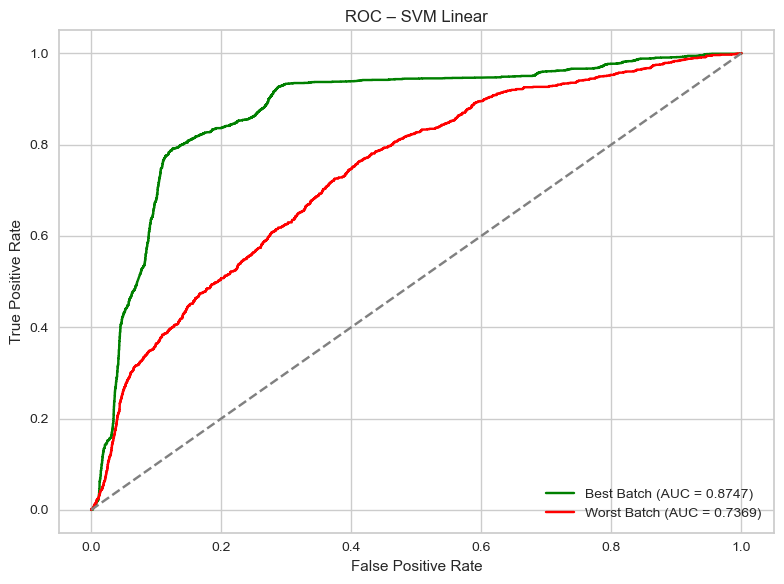

In [200]:
# === STEP 5: Plot ROC for Best & Worst ===
best_idx = np.argmax(auc_scores)
worst_idx = np.argmin(auc_scores)

plt.figure(figsize=(8, 6))
plt.plot(*roc_curves[best_idx], label=f'Best Batch (AUC = {auc_scores[best_idx]:.4f})', color='green')
plt.plot(*roc_curves[worst_idx], label=f'Worst Batch (AUC = {auc_scores[worst_idx]:.4f})', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC – SVM Linear")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_linear.png", dpi=300, bbox_inches='tight')
plt.show()

In [201]:
thresholds = np.arange(0.05, 0.95, 0.05)
results = []

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    acc = accuracy_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)

    results.append({
        "Threshold": round(thresh, 2),
        "TPR (Recall)": round(tpr, 3),
        "FNR": round(fnr, 3),
        "FPR": round(fpr, 3),
        "Accuracy": round(acc, 3),
        "Precision": round(prec, 3),
        "F1-Score": round(f1, 3)
    })
threshold_df = pd.DataFrame(results).set_index("Threshold")
display(threshold_df)

TPR (Recall)    FNR    FPR  Accuracy  Precision  F1-Score
Threshold                                                           
0.05              0.920  0.080  0.534     0.520      0.188     0.312
0.10              0.832  0.168  0.380     0.645      0.227     0.357
0.15              0.734  0.266  0.252     0.746      0.281     0.406
0.20              0.641  0.359  0.134     0.840      0.392     0.486
0.25              0.517  0.483  0.078     0.874      0.469     0.492
0.30              0.371  0.629  0.052     0.879      0.487     0.421
0.35              0.254  0.746  0.036     0.880      0.485     0.333
0.40              0.155  0.845  0.025     0.878      0.450     0.231
0.45              0.087  0.913  0.018     0.877      0.400     0.143
0.50              0.047  0.953  0.012     0.877      0.349     0.082
0.55              0.021  0.979  0.007     0.878      0.278     0.039
0.60              0.012  0.988  0.005     0.878      0.233     0.023
0.65              0.007  0.993  0.003     0.880      0.217     0.014
0.70              0.006  0.994  0.003     0.880      0.222     0.011
0.75              0.004  0.996  0.002     0.881      0.250     0.008
0.80              0.003  0.997  0.001     0.881      0.250     0.006
0.85              0.001  0.999  0.001     0.881      0.100     0.001
0.90              0.001  0.999  0.001     0.881      0.125     0.001

### Cailibrated Linear 

In this step, we extend our earlier batch-wise SVM evaluation by applying probability calibration using `CalibratedClassifierCV`. SVMs are known to produce poorly calibrated probability outputs, which can mislead downstream decision-making when probability thresholds are used (e.g., rejecting loans with predicted default risk > 20%).

To address this, we wrap each batch's SVM inside a calibration pipeline (`method='sigmoid'`), which fits a logistic regression to the SVM's raw decision function (Platt scaling). This ensures that the resulting probabilities are better aligned with observed default rates, improving model interpretability and threshold-based risk decisions.

We retain the batch structure to manage computational load and preserve consistency with prior evaluation. For each batch:
- We standard scale the features
- Fit a calibrated linear SVM
- Predict calibrated probabilities on the test set
- Track performance metrics and plot ROC curves for the best and worst batch outcomes

In [202]:
# === Step 1: Setup ===
X_full = data.drop(columns='Default')
y_full = data['Default']

# === Step 2: Define batching ===
batch_size = 40000
num_batches = X_full.shape[0] // batch_size

metrics = []
auc_scores = []
roc_curves = []

In [203]:
# === Step 3: Loop through batches ===
for i in range(num_batches):
    print(f"Processing batch {i+1}/{num_batches}...")

    start = i * batch_size
    end = (i + 1) * batch_size
    X_batch = X_full.iloc[start:end]
    y_batch = y_full.iloc[start:end]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_batch, y_batch, test_size=0.3, stratify=y_batch, random_state=42
    )

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Calibrated linear SVM
    base_svm = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)
    cal_svm = CalibratedClassifierCV(base_estimator=base_svm, method='sigmoid', cv=3)
    cal_svm.fit(X_train_scaled, y_train)

    # Predict
    y_pred = cal_svm.predict(X_test_scaled)
    y_proba = cal_svm.predict_proba(X_test_scaled)[:, 1]

    # Compute FPR
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr_value = fp / (fp + tn)

    # Collect metrics
    metrics.append({
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "FPR": fpr_value,
        "AUC": roc_auc_score(y_test, y_proba)
    })

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_scores.append(roc_auc_score(y_test, y_proba))
    roc_curves.append((fpr, tpr))

Processing batch 1/22...
Processing batch 2/22...
Processing batch 3/22...
Processing batch 4/22...
Processing batch 5/22...
Processing batch 6/22...
Processing batch 7/22...
Processing batch 8/22...
Processing batch 9/22...
Processing batch 10/22...
Processing batch 11/22...
Processing batch 12/22...
Processing batch 13/22...
Processing batch 14/22...
Processing batch 15/22...
Processing batch 16/22...
Processing batch 17/22...
Processing batch 18/22...
Processing batch 19/22...
Processing batch 20/22...
Processing batch 21/22...
Processing batch 22/22...


In [204]:
# === Step 4: Results ===
metrics_df = pd.DataFrame(metrics)
print("Averaged Metrics:")
print(metrics_df.mean())

Averaged Metrics:
Accuracy     0.853985
Precision    0.442448
Recall       0.215528
F1           0.266083
FPR          0.036901
AUC          0.820460
dtype: float64


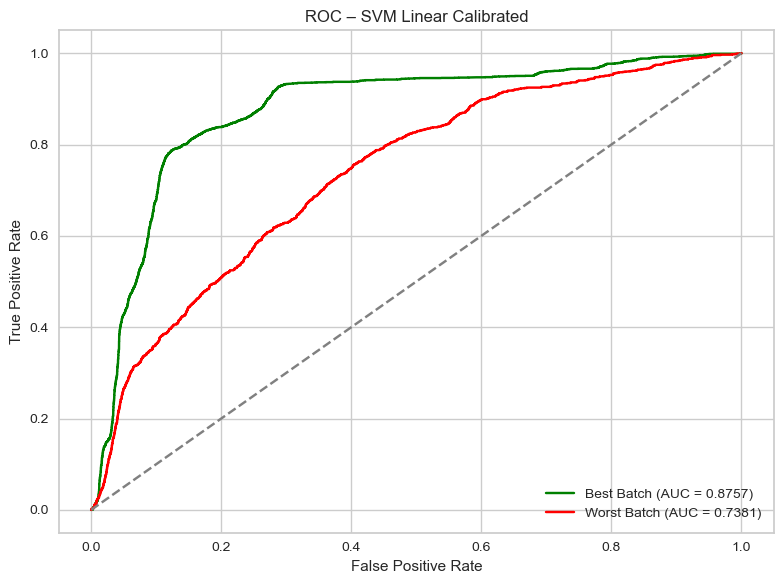

In [205]:
# === Step 5: Plot ROC for Best & Worst ===
best_idx = np.argmax(auc_scores)
worst_idx = np.argmin(auc_scores)

plt.figure(figsize=(8, 6))
plt.plot(*roc_curves[best_idx], label=f'Best Batch (AUC = {auc_scores[best_idx]:.4f})', color='green')
plt.plot(*roc_curves[worst_idx], label=f'Worst Batch (AUC = {auc_scores[worst_idx]:.4f})', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC – SVM Linear Calibrated")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_calibrated_linear.png", dpi=300, bbox_inches='tight')
plt.show()

In [206]:
thresholds = np.arange(0.05, 0.95, 0.05)
results = []

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    acc = accuracy_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)

    results.append({
        "Threshold": round(thresh, 2),
        "TPR (Recall)": round(tpr, 3),
        "FNR": round(fnr, 3),
        "FPR": round(fpr, 3),
        "Accuracy": round(acc, 3),
        "Precision": round(prec, 3),
        "F1-Score": round(f1, 3)
    })
threshold_df = pd.DataFrame(results).set_index("Threshold")
display(threshold_df)

TPR (Recall)    FNR    FPR  Accuracy  Precision  F1-Score
Threshold                                                           
0.05              0.918  0.082  0.527     0.526      0.189     0.314
0.10              0.832  0.168  0.378     0.647      0.228     0.358
0.15              0.734  0.266  0.249     0.749      0.283     0.409
0.20              0.640  0.360  0.131     0.842      0.396     0.489
0.25              0.510  0.490  0.078     0.873      0.468     0.488
0.30              0.367  0.633  0.052     0.879      0.486     0.418
0.35              0.246  0.754  0.035     0.880      0.485     0.326
0.40              0.151  0.849  0.025     0.878      0.448     0.226
0.45              0.085  0.915  0.018     0.876      0.394     0.140
0.50              0.044  0.956  0.011     0.877      0.343     0.078
0.55              0.022  0.978  0.007     0.878      0.284     0.041
0.60              0.013  0.987  0.005     0.879      0.243     0.024
0.65              0.007  0.993  0.003     0.880      0.213     0.014
0.70              0.006  0.994  0.003     0.880      0.216     0.011
0.75              0.005  0.995  0.002     0.881      0.269     0.010
0.80              0.004  0.996  0.001     0.881      0.294     0.007
0.85              0.001  0.999  0.001     0.881      0.091     0.001
0.90              0.001  0.999  0.001     0.881      0.125     0.001

### RBF Kernel (Radial Basis Function)

In [207]:
# === Step 1: Setup ===
X_full = data.drop(columns='Default')
y_full = data['Default']

# === STEP 2: Define batching ===
batch_size = 40000
num_batches = X_full.shape[0] // batch_size

metrics = []
auc_scores = []
roc_curves = []

In [208]:
# === STEP 3: Loop through batches ===
for i in range(num_batches):
    print(f"Processing batch {i+1}/{num_batches}...")

    start = i * batch_size
    end = (i + 1) * batch_size
    X_batch = X_full.iloc[start:end]
    y_batch = y_full.iloc[start:end]

    # Split and scale
    X_train, X_test, y_train, y_test = train_test_split(
        X_batch, y_batch, test_size=0.3, stratify=y_batch, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Use tuned RBF SVM
    svm_model = SVC(
        kernel='rbf',
        C=10,
        gamma='scale',
        class_weight='balanced',
        probability=True,
        random_state=42
    )
    svm_model.fit(X_train_scaled, y_train)

    # === Threshold at 0.2 ===
    y_proba = svm_model.predict_proba(X_test_scaled)[:, 1]
    y_pred_thresh = (y_proba >= 0.2).astype(int)

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    fpr_value = fp / (fp + tn)

    # Collect metrics
    metrics.append({
        "Accuracy": accuracy_score(y_test, y_pred_thresh),
        "Precision": precision_score(y_test, y_pred_thresh),
        "Recall": recall_score(y_test, y_pred_thresh),
        "F1": f1_score(y_test, y_pred_thresh),
        "FPR": fpr_value,
        "AUC": roc_auc_score(y_test, y_proba)
    })

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_scores.append(roc_auc_score(y_test, y_proba))
    roc_curves.append((fpr, tpr))

Processing batch 1/22...
Processing batch 2/22...
Processing batch 3/22...
Processing batch 4/22...
Processing batch 5/22...
Processing batch 6/22...
Processing batch 7/22...
Processing batch 8/22...
Processing batch 9/22...
Processing batch 10/22...
Processing batch 11/22...
Processing batch 12/22...
Processing batch 13/22...
Processing batch 14/22...
Processing batch 15/22...
Processing batch 16/22...
Processing batch 17/22...
Processing batch 18/22...
Processing batch 19/22...
Processing batch 20/22...
Processing batch 21/22...
Processing batch 22/22...


In [209]:
# === STEP 4: Results ===
metrics_df = pd.DataFrame(metrics)
print("Averaged Metrics (Threshold = 0.2):")
print(metrics_df.mean())

Averaged Metrics (Threshold = 0.2):
Accuracy     0.834689
Precision    0.475116
Recall       0.702738
F1           0.564912
FPR          0.165663
AUC          0.854036
dtype: float64


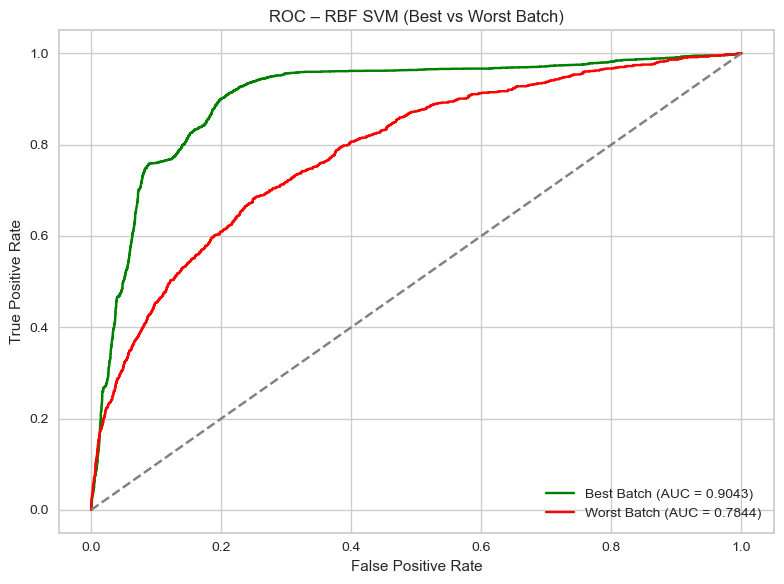

In [210]:
# === STEP 5: Plot ROC for Best & Worst Batches ===
best_idx = np.argmax(auc_scores)
worst_idx = np.argmin(auc_scores)

plt.figure(figsize=(8, 6))
plt.plot(*roc_curves[best_idx], label=f'Best Batch (AUC = {auc_scores[best_idx]:.4f})', color='green')
plt.plot(*roc_curves[worst_idx], label=f'Worst Batch (AUC = {auc_scores[worst_idx]:.4f})', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC – RBF SVM (Best vs Worst Batch)")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [211]:
thresholds = np.arange(0.05, 0.95, 0.05)
results = []

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    acc = accuracy_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)

    results.append({
        "Threshold": round(thresh, 2),
        "TPR (Recall)": round(tpr, 3),
        "FNR": round(fnr, 3),
        "FPR": round(fpr, 3),
        "Accuracy": round(acc, 3),
        "Precision": round(prec, 3),
        "F1-Score": round(f1, 3)
    })
threshold_df = pd.DataFrame(results).set_index("Threshold")
display(threshold_df)

TPR (Recall)    FNR    FPR  Accuracy  Precision  F1-Score
Threshold                                                           
0.05              0.915  0.085  0.391     0.645      0.239     0.379
0.10              0.835  0.165  0.244     0.766      0.315     0.457
0.15              0.755  0.245  0.159     0.831      0.390     0.514
0.20              0.684  0.316  0.113     0.863      0.447     0.541
0.25              0.615  0.385  0.083     0.881      0.497     0.550
0.30              0.537  0.463  0.063     0.890      0.534     0.535
0.35              0.466  0.534  0.050     0.893      0.555     0.506
0.40              0.385  0.615  0.038     0.894      0.577     0.462
0.45              0.320  0.680  0.032     0.891      0.571     0.410
0.50              0.267  0.733  0.027     0.889      0.569     0.364
0.55              0.213  0.787  0.021     0.889      0.582     0.312
0.60              0.166  0.834  0.016     0.888      0.586     0.259
0.65              0.130  0.870  0.010     0.888      0.637     0.215
0.70              0.087  0.913  0.007     0.886      0.637     0.153
0.75              0.053  0.947  0.004     0.885      0.664     0.098
0.80              0.028  0.972  0.002     0.883      0.625     0.054
0.85              0.014  0.986  0.001     0.883      0.690     0.028
0.90              0.005  0.995  0.000     0.882      0.636     0.010

### RBF Calibrated 

In [212]:
# === Step 1: Setup ===
X_full = data.drop(columns='Default')
y_full = data['Default']

# === Step 2: Define batching ===
batch_size = 40000
num_batches = X_full.shape[0] // batch_size

metrics = []
auc_scores = []
roc_curves = []

In [213]:
# === Step 3: Loop through batches ===
for i in range(num_batches):
    print(f"Processing batch {i+1}/{num_batches}...")

    # Subset batch
    start, end = i * batch_size, (i + 1) * batch_size
    X_batch = X_full.iloc[start:end]
    y_batch = y_full.iloc[start:end]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_batch, y_batch, test_size=0.3, stratify=y_batch, random_state=42
    )

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Base SVM model with RBF kernel
    base_svm = SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced', probability=True)

    # Wrap with calibration
    cal_svm = CalibratedClassifierCV(base_estimator=base_svm, method='sigmoid', cv=3)
    cal_svm.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = cal_svm.predict(X_test_scaled)
    y_proba = cal_svm.predict_proba(X_test_scaled)[:, 1]

    # Compute FPR
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr_value = fp / (fp + tn)

    # Collect metrics
    metrics.append({
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "FPR": fpr_value,
        "AUC": roc_auc_score(y_test, y_proba)
    })

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_scores.append(roc_auc_score(y_test, y_proba))
    roc_curves.append((fpr, tpr))

Processing batch 1/22...
Processing batch 2/22...
Processing batch 3/22...
Processing batch 4/22...
Processing batch 5/22...
Processing batch 6/22...
Processing batch 7/22...
Processing batch 8/22...
Processing batch 9/22...
Processing batch 10/22...
Processing batch 11/22...
Processing batch 12/22...
Processing batch 13/22...
Processing batch 14/22...
Processing batch 15/22...
Processing batch 16/22...
Processing batch 17/22...
Processing batch 18/22...
Processing batch 19/22...
Processing batch 20/22...
Processing batch 21/22...
Processing batch 22/22...


In [214]:
# === Step 4: Summary ===
metrics_df = pd.DataFrame(metrics)
print("\nAveraged Metrics:")
print(metrics_df.mean())


Averaged Metrics:
Accuracy     0.873534
Precision    0.653371
Recall       0.366132
F1           0.435180
FPR          0.045472
AUC          0.854214
dtype: float64


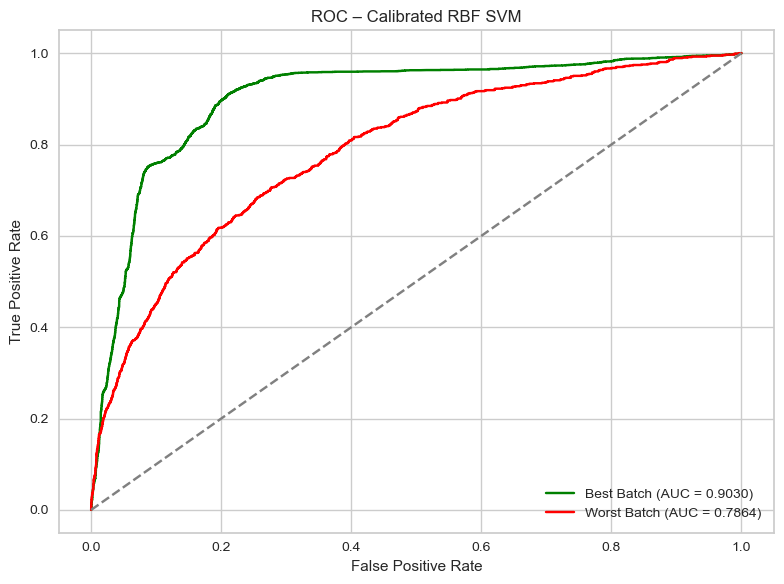

In [215]:
# === Step 5: ROC for Best and Worst ===
best_idx = np.argmax(auc_scores)
worst_idx = np.argmin(auc_scores)

plt.figure(figsize=(8, 6))
plt.plot(*roc_curves[best_idx], label=f'Best Batch (AUC = {auc_scores[best_idx]:.4f})', color='green')
plt.plot(*roc_curves[worst_idx], label=f'Worst Batch (AUC = {auc_scores[worst_idx]:.4f})', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC – Calibrated RBF SVM')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_calibrated_RBF.png", dpi=300, bbox_inches='tight')
plt.show()

In [216]:
thresholds = np.arange(0.05, 0.95, 0.05)
results = []

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    acc = accuracy_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)

    results.append({
        "Threshold": round(thresh, 2),
        "TPR (Recall)": round(tpr, 3),
        "FNR": round(fnr, 3),
        "FPR": round(fpr, 3),
        "Accuracy": round(acc, 3),
        "Precision": round(prec, 3),
        "F1-Score": round(f1, 3)
    })
threshold_df = pd.DataFrame(results).set_index("Threshold")
display(threshold_df)

TPR (Recall)    FNR    FPR  Accuracy  Precision  F1-Score
Threshold                                                           
0.05              0.915  0.085  0.393     0.643      0.238     0.378
0.10              0.839  0.161  0.251     0.760      0.310     0.453
0.15              0.758  0.242  0.162     0.829      0.386     0.512
0.20              0.679  0.321  0.112     0.863      0.448     0.540
0.25              0.606  0.394  0.080     0.882      0.503     0.550
0.30              0.524  0.476  0.059     0.891      0.542     0.533
0.35              0.449  0.551  0.049     0.892      0.553     0.496
0.40              0.371  0.629  0.037     0.893      0.571     0.450
0.45              0.311  0.689  0.031     0.891      0.574     0.403
0.50              0.253  0.747  0.025     0.890      0.574     0.351
0.55              0.206  0.794  0.019     0.889      0.586     0.305
0.60              0.159  0.841  0.015     0.888      0.590     0.251
0.65              0.128  0.872  0.010     0.888      0.625     0.213
0.70              0.085  0.915  0.005     0.887      0.691     0.152
0.75              0.049  0.951  0.003     0.885      0.673     0.092
0.80              0.022  0.978  0.002     0.883      0.646     0.042
0.85              0.011  0.989  0.001     0.882      0.640     0.022
0.90              0.003  0.997  0.000     0.882      0.571     0.006

### KNN

In [135]:
#Set up X and Y
x_knn = data.drop(columns= 'Default')
y_knn = data['Default']

# One-hot encode categoricals
x_knn = pd.get_dummies(x_knn, drop_first=True)

#Get sample of 45,000 observations
x_sample_knn, _, y_sample_knn, _ = train_test_split(
    x_knn, y_knn, train_size=45000, stratify=y_knn, random_state=25)

In [136]:
# 70/30 split of sample
x_train_sample_knn, x_test_sample_knn, y_train_sample_knn, y_test_sample_knn = train_test_split(
    x_sample_knn, y_sample_knn, test_size=0.3, stratify=y_sample_knn, random_state=15)

# Scale X for KNN
scaler = StandardScaler()
x_train_sample_knn_scaled = scaler.fit_transform(x_train_sample_knn)
x_test_sample_knn_scaled = scaler.transform(x_test_sample_knn)

In [137]:
def KNN(x_training, x_testing, y_training, y_testing, n_neighbors):
    
    error = []
    
    for k in n_neighbors:
        
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_training, y_training)
        score = knn.score(x_testing, y_testing) 
        error.append(1-score)
    
    #Find min error
    min_error = min(error)
    min_error_k = n_neighbors[error.index(min_error)]
    
    #Plot k vs error rate
    plt.plot(n_neighbors, error, marker='.')
    plt.xlabel('Model Flexbility')
    plt.ylabel('Test Error Rate')
    plt.suptitle('Test Error Rate vs. Model Flexibility', fontsize=14)
    plt.plot(min_error_k, min_error, marker='o', markersize=10,
             label='Minimum Error',color='red')
    plt.show()

    return

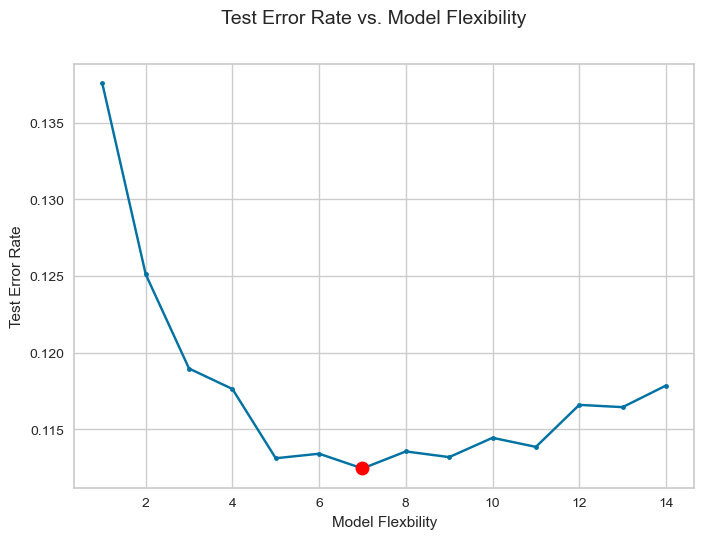

In [138]:
neighbours = range(1,15,1)
KNN(x_train_sample_knn, x_test_sample_knn, y_train_sample_knn, y_test_sample_knn, neighbours)

As we can see, the optimal flexibility model for our KNN model is k=7, leading to the lowest test error rate. This avoids either extreme of high bias (caused by underfitting with a high k) or high variance (caused by overfitting with a low k), as can be seen in our U-shaped curve.

However, this one-way validation method may be biased, as we are only using 70% of our 45,000 obsevrations to fit the model. Therefore, we will introduce 5-fold cross validation to get a less biased estimate of the test error rate for each value of k. 

In [139]:
def KNN_cv(X, y, n_neighbors, n_splits=5):
    error_dict = {k: [] for k in n_neighbors}
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=15)

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Scale
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        for k in n_neighbors:
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train_scaled, y_train)
            y_pred = knn.predict(X_test_scaled)
            error = 1 - accuracy_score(y_test, y_pred)
            error_dict[k].append(error)

    # Compute average error per k
    avg_errors = [np.mean(error_dict[k]) for k in n_neighbors]
    min_error = min(avg_errors)
    best_k = n_neighbors[avg_errors.index(min_error)]

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(n_neighbors, avg_errors, marker='.')
    plt.plot(best_k, min_error, marker='o', markersize=10, color='red', label='Minimum Error')
    plt.xlabel('Model Flexibility (k)')
    plt.ylabel('Average CV Error Rate')
    plt.title('5-Fold Cross-Validated Error Rate vs. k')
    plt.legend()
    plt.show()

    return best_k, min_error


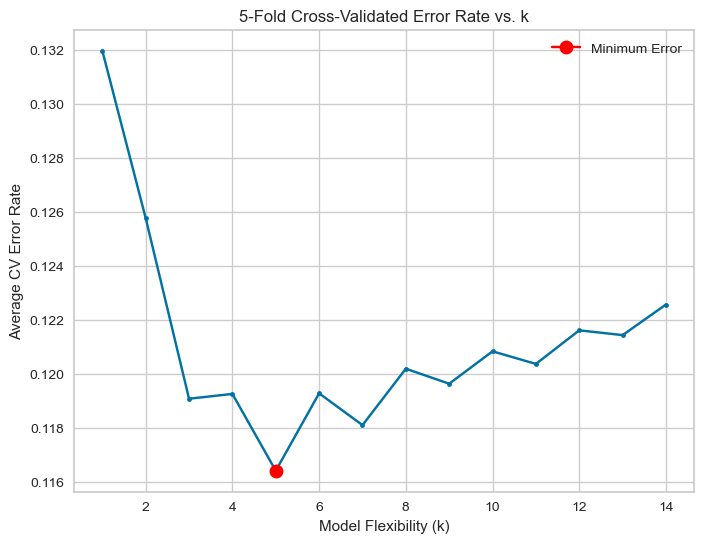

Best k = 5 with avg error = 0.1164


In [140]:
best_k, min_err = KNN_cv(x_sample_knn, y_sample_knn, neighbours, n_splits=5)
print(f"Best k = {best_k} with avg error = {min_err:.4f}")

After implementing 5-fold CV, we now see that our optimal model flexibility lies at k=5 instead of k=7. It appears our original one-way validation set may have been biased and underestimated the true test error rate of our sample set.
Our U-Shaped curve remains, showing the bias-variance trade-off that exists when deciding flexbility, with k=5 offering a nice middleground which avoids extreme overfitting or underfitting.

Importantly, when selecting k=5 as our flexibility for the KNN model, the probability thresholds 0.1 and 0,2 are identical, as the model’s predicted probabilities are discrete and based on the proportion of neighbors in the positive class, which would be multiples of 0.2.

In [141]:
# Fit KNN model on training data using optimal k = 5
model_knn = KNeighborsClassifier(n_neighbors = 5)
model_knn.fit(x_train_sample_knn,y_train_sample_knn)

# Define thresholds to test
thresholds = [0.2, 0.35, 0.5]

# Get predicted probabilities from trained model
probs = model_knn.predict_proba(x_test_sample_knn)[:, 1]

# Initialize results DataFrame
threshold_results = pd.DataFrame(columns=["Threshold", "TPR", "FPR", "TNR", "FNR", "Accuracy", "Precision", "F-score", "G-score"])

# Loop through each threshold
for threshold in thresholds:
    # Apply threshold to get predictions
    y_pred_thresh = (probs >= threshold).astype(int)

    # Confusion matrix
    cm = confusion_matrix(y_test_sample_knn, y_pred_thresh)
    tn, fp, fn, tp = cm.ravel()

    # Calculate metrics
    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) != 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) != 0 else 0
    accuracy = accuracy_score(y_test_sample_knn, y_pred_thresh)
    precision = precision_score(y_test_sample_knn, y_pred_thresh, zero_division=0)
    f_score = 2 * ((precision * tpr) / (precision + tpr)) if (precision + tpr) != 0 else 0
    g_score = np.sqrt(precision * tpr)

    # Append to results
    threshold_results = pd.concat([threshold_results, pd.DataFrame([{
        "Threshold": threshold,
        "TPR": tpr,
        "FPR": fpr,
        "TNR": tnr,
        "FNR": fnr,
        "Accuracy": accuracy,
        "Precision": precision,
        "F-score": f_score,
        "G-score": g_score
    }])], ignore_index=True)
    
        # Print results
    print(f"Threshold: {threshold}")
    print("Confusion Matrix: ")
    # Format confusion matrix 
    df_cm = pd.DataFrame(index = ['Predicted Positive', 'Predicted Negative'])
    df_cm['Positive'] = [cm[1][1], cm[1][0]]
    df_cm['Negative'] = [cm[0][1], cm[0][0]]  
        
    #Print confusion matrix 
    print(tabulate(df_cm, headers = ['Actual Positive', 'Actual Negative'], showindex = ['Predicted Positive', 'Predicted Negative'], tablefmt = 'fancy_grid'))

        
threshold_results

Threshold: 0.2
Confusion Matrix: 
╒════════════════════╤═══════════════════╤═══════════════════╕
│                    │   Actual Positive │   Actual Negative │
╞════════════════════╪═══════════════════╪═══════════════════╡
│ Predicted Positive │              1921 │              3023 │
├────────────────────┼───────────────────┼───────────────────┤
│ Predicted Negative │               450 │              8106 │
╘════════════════════╧═══════════════════╧═══════════════════╛
Threshold: 0.35
Confusion Matrix: 
╒════════════════════╤═══════════════════╤═══════════════════╕
│                    │   Actual Positive │   Actual Negative │
╞════════════════════╪═══════════════════╪═══════════════════╡
│ Predicted Positive │              1532 │              1011 │
├────────────────────┼───────────────────┼───────────────────┤
│ Predicted Negative │               839 │             10118 │
╘════════════════════╧═══════════════════╧═══════════════════╛
Threshold: 0.5
Confusion Matrix: 
╒══════════════

Threshold       TPR       FPR       TNR       FNR  Accuracy  Precision  \
0       0.20  0.810207  0.271633  0.728367  0.189793  0.742741   0.388552   
1       0.35  0.646141  0.090844  0.909156  0.353859  0.862963   0.602438   
2       0.50  0.519612  0.034864  0.965136  0.480388  0.886889   0.760494   

    F-score   G-score  
0  0.525222  0.561077  
1  0.623525  0.623907  
2  0.617389  0.628619

Threshold: 0.2
Confusion Matrix: 


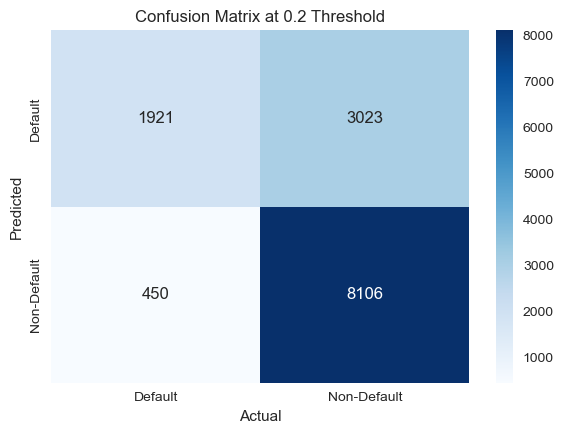

Threshold: 0.35
Confusion Matrix: 


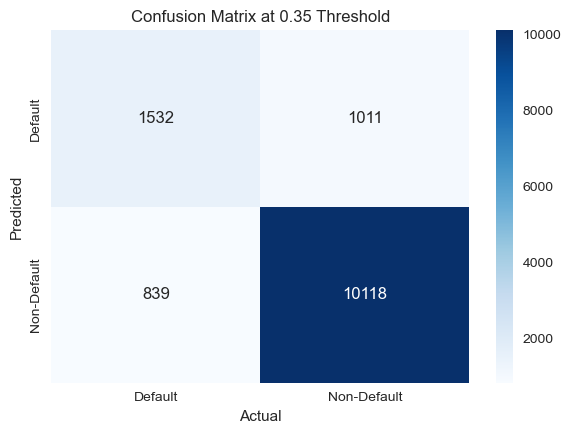

Threshold: 0.5
Confusion Matrix: 


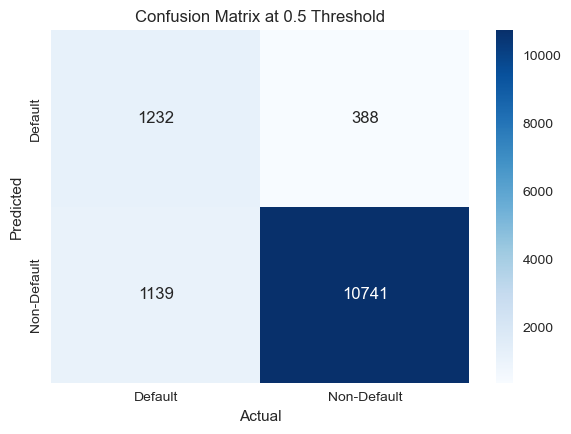

Threshold       TPR       FPR       TNR       FNR  Accuracy  Precision  \
0       0.20  0.810207  0.271633  0.728367  0.189793  0.742741   0.388552   
1       0.35  0.646141  0.090844  0.909156  0.353859  0.862963   0.602438   
2       0.50  0.519612  0.034864  0.965136  0.480388  0.886889   0.760494   

    F-score   G-score  
0  0.525222  0.561077  
1  0.623525  0.623907  
2  0.617389  0.628619

In [142]:
# Fit KNN model on training data using optimal k = 5
model_knn = KNeighborsClassifier(n_neighbors = 5)
model_knn.fit(x_train_sample_knn,y_train_sample_knn)

# Define thresholds to test
thresholds = [0.2, 0.35, 0.5]

# Get predicted probabilities from trained model
probs = model_knn.predict_proba(x_test_sample_knn)[:, 1]

# Initialize results DataFrame
threshold_results = pd.DataFrame(columns=["Threshold", "TPR", "FPR", "TNR", "FNR", "Accuracy", "Precision", "F-score", "G-score"])

# Loop through each threshold
for threshold in thresholds:
    # Apply threshold to get predictions
    y_pred_thresh = (probs >= threshold).astype(int)

    # Confusion matrix
    cm = confusion_matrix(y_test_sample_knn, y_pred_thresh)
    tn, fp, fn, tp = cm.ravel()

    # Calculate metrics
    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) != 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) != 0 else 0
    accuracy = accuracy_score(y_test_sample_knn, y_pred_thresh)
    precision = precision_score(y_test_sample_knn, y_pred_thresh, zero_division=0)
    f_score = 2 * ((precision * tpr) / (precision + tpr)) if (precision + tpr) != 0 else 0
    g_score = np.sqrt(precision * tpr)

    # Append to results
    threshold_results = pd.concat([threshold_results, pd.DataFrame([{
        "Threshold": threshold,
        "TPR": tpr,
        "FPR": fpr,
        "TNR": tnr,
        "FNR": fnr,
        "Accuracy": accuracy,
        "Precision": precision,
        "F-score": f_score,
        "G-score": g_score
    }])], ignore_index=True)
    
        # Print results
    print(f"Threshold: {threshold}")
    print("Confusion Matrix: ")
    # Format confusion matrix 
    cm=np.array([[tp,fp],
                 [fn, tn]])
    plt.figure(figsize=(6, 4.5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Default', 'Non-Default'],
                    yticklabels=['Default', 'Non-Default'])
    plt.title(f'Confusion Matrix at {threshold} Threshold')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.tight_layout()
    plt.show()
        
threshold_results

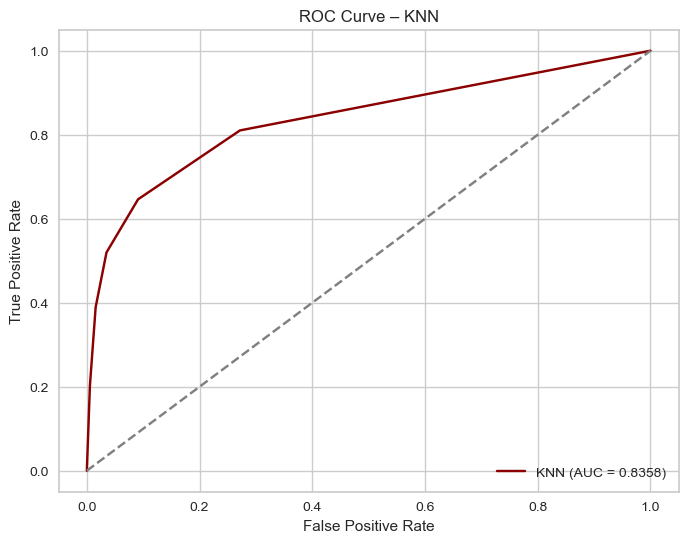

In [143]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_sample_knn, probs)
auc_score = roc_auc_score(y_test_sample_knn, probs)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"KNN (AUC = {auc_score:.4f})", color='darkred')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – KNN")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

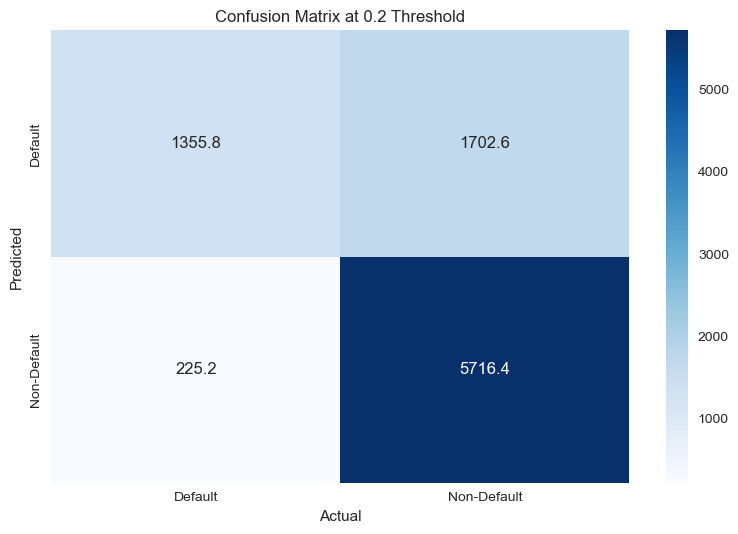

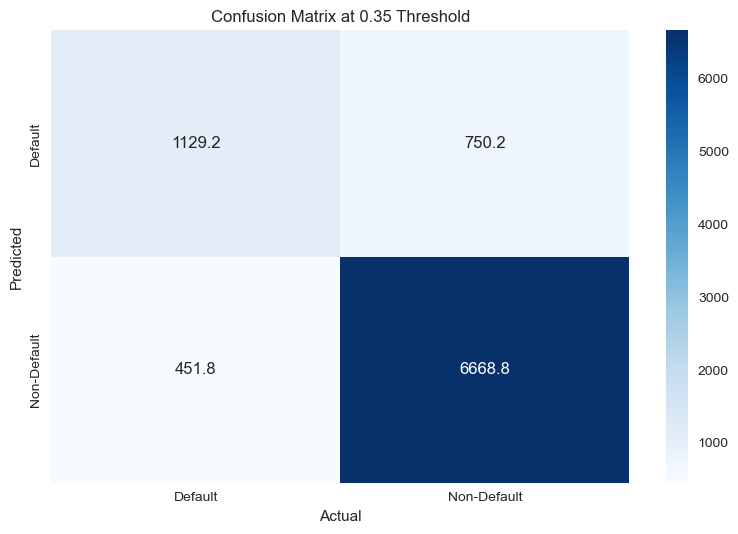

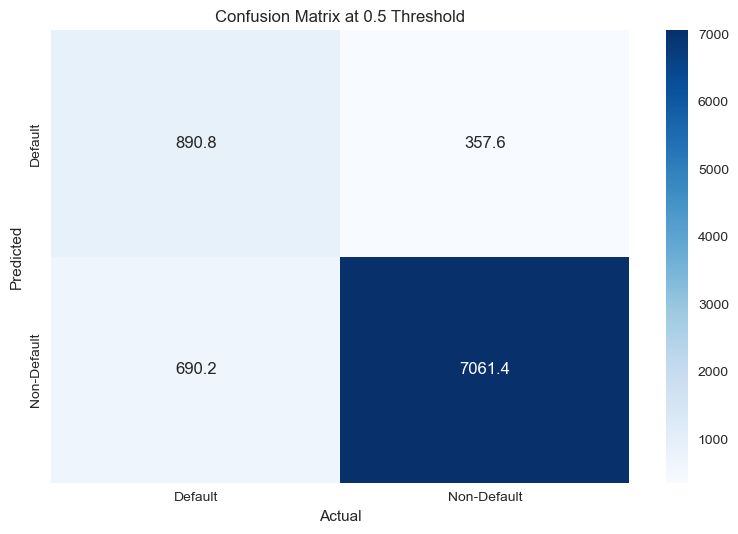


 Average Cross-Validated Results by Threshold:

   Threshold     TPR     FPR     TNR     FNR  Accuracy  Precision      F1  \
0       0.20  0.8576  0.2295  0.7705  0.1424    0.7858     0.4434  0.5845   
1       0.35  0.7142  0.1011  0.8989  0.2858    0.8664     0.6009  0.6526   
2       0.50  0.5634  0.0482  0.9518  0.4366    0.8836     0.7135  0.6296   

      AUC  
0  0.8679  
1  0.8679  
2  0.8679  


In [144]:
# Define thresholds
thresholds = [0.2, 0.35, 0.5]

# Track cumulative confusion matrix per threshold
confusion_sums = {threshold: np.array([0, 0, 0, 0]) for threshold in thresholds}  # [tn, fp, fn, tp]

# Create dict to collect metrics per threshold across folds
cv_results = {threshold: [] for threshold in thresholds}

# Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

for train_idx, test_idx in skf.split(x_sample_knn, y_sample_knn):
    X_train, X_test = x_sample_knn.iloc[train_idx], x_sample_knn.iloc[test_idx]
    y_train, y_test = y_sample_knn.iloc[train_idx], y_sample_knn.iloc[test_idx]

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit model
    model_knn = KNeighborsClassifier(n_neighbors=5)
    model_knn.fit(X_train_scaled, y_train)

    # Predict probabilities
    probs = model_knn.predict_proba(X_test_scaled)[:, 1]

    # Loop through thresholds
    for threshold in thresholds:
        y_pred = (probs >= threshold).astype(int)
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        confusion_sums[threshold] += np.array([tn, fp, fn, tp])
       
       
        cv_results[threshold].append({
            "Batch": i + 1,
            "TPR": tp / (tp + fn) if (tp + fn) != 0 else 0,  # True Positive Rate (Recall)
            "FNR": fn / (fn + tp) if (fn + tp) != 0 else 0,  # False Negative Rate
            "FPR": fp / (fp + tn) if (fp + tn) != 0 else 0,  # False Positive Rate
            "TNR": tn / (tn + fp) if (tn + fp) != 0 else 0,   # True Negative Rate
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "AUC": roc_auc_score(y_test, probs)
        })

final_df = pd.DataFrame()      
for threshold in thresholds:
    # Convert list of dicts to DataFrame
    df = pd.DataFrame(cv_results[threshold])
    avg_metrics = df.mean()
    avg_metrics["Threshold"] = threshold
    final_df = pd.concat([final_df, avg_metrics.to_frame().T], ignore_index=True)

    #Print average confusion matrix across each fold
    tn, fp, fn, tp = confusion_sums[threshold] / 5  # average over 5 folds
    cm_avg = np.array([[tp, fp],
                        [fn, tn]])

    sns.heatmap(cm_avg, annot=True, fmt='.1f', cmap='Blues',
                                    xticklabels=['Default', 'Non-Default'],
                                    yticklabels=['Default', 'Non-Default'])
    plt.title(f'Confusion Matrix at {threshold} Threshold')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.tight_layout()
    plt.show()

final_df = final_df[["Threshold", "TPR", "FPR", "TNR", "FNR", "Accuracy", "Precision", "F1", "AUC"]]
print("\n Average Cross-Validated Results by Threshold:\n")
print(final_df.round(4))

In [145]:

avg_results = final_df[["TPR","FNR","TNR","FPR","Accuracy", "Precision", "F1", "AUC"]].mean()
print(pd.DataFrame(avg_results).T)  


        TPR       FNR      TNR      FPR  Accuracy  Precision        F1  \
0  0.711744  0.288256  0.87373  0.12627  0.845274   0.585935  0.622258   

        AUC  
0  0.867879  


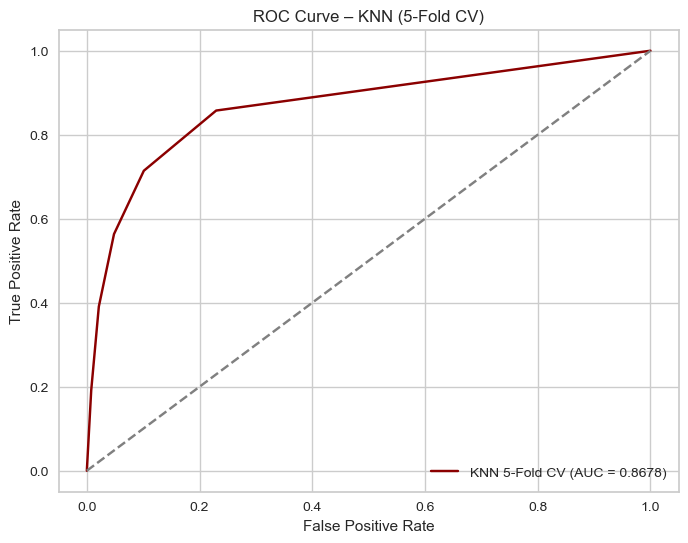

In [146]:
# Set up storage
all_probs = []
all_true = []

# 5-fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

for train_idx, test_idx in skf.split(x_sample_knn, y_sample_knn):
    X_train, X_test = x_sample_knn.iloc[train_idx], x_sample_knn.iloc[test_idx]
    y_train, y_test = y_sample_knn.iloc[train_idx], y_sample_knn.iloc[test_idx]

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train KNN
    model_knn = KNeighborsClassifier(n_neighbors=5)
    model_knn.fit(X_train_scaled, y_train)

    # Predict probabilities
    probs = model_knn.predict_proba(X_test_scaled)[:, 1]

    # Save for ROC
    all_probs.extend(probs)
    all_true.extend(y_test)

# Convert to arrays
all_probs = np.array(all_probs)
all_true = np.array(all_true)

# ROC and AUC
fpr, tpr, _ = roc_curve(all_true, all_probs)
auc_score = roc_auc_score(all_true, all_probs)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"KNN 5-Fold CV (AUC = {auc_score:.4f})", color='darkred')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – KNN (5-Fold CV)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### KNN using batch method

As discussed perviously, running a KNN Model on the whole dataset of 900,000 observations proved too computationally costly. Howwever, in order to use the entire dataset (to reduce bias), we implemented batching whereby the data was split up into 20 equal sized batches, allowing us to evaluate model performance in manageable chunks while reducing memory usage and ensuring more stable, scalable performance estimates.

Running a threshold / k-neightbours sweep in the batch method was computationally infeasible, so we used our previously determined optimal tuning paramaters of k=5 neightbours and a 0.2 threshold to fit our models.

In [147]:
#Previously selected 0.2 as our optimal threshold 
threshold_batch = 0.2

#Split into 20 equal sized batches
batch_size_knn = 44950
num_batches_knn = x_knn.shape[0] // batch_size_knn


# Shuffle the full dataset to randomise order of batches
X_knn_shuffled, y_knn_shuffled = shuffle(x_knn, y_knn, random_state=42)

all_metrics = []
all_confusion_matrices = None
roc_curves = []
auc_scores = []

for i in range(num_batches_knn):
    print(f"Processing batch {i+1}/{num_batches_knn}...")

    start = i * batch_size_knn
    end = (i + 1) * batch_size_knn
    X_knn_batch = X_knn_shuffled.iloc[start:end]
    y_knn_batch = y_knn_shuffled.iloc[start:end]

    X_train, X_test, y_train, y_test = train_test_split(
        X_knn_batch, y_knn_batch, test_size=0.3, stratify=y_knn_batch, random_state=15
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    knn_batch_model = KNeighborsClassifier(n_neighbors = 5)
    knn_batch_model.fit(X_train_scaled, y_train)

   # Predict probabilities
    y_proba = knn_batch_model.predict_proba(X_test_scaled)[:, 1]
    y_pred = (y_proba >= threshold_batch).astype(int)
    
    #Conufsion matrix
    cm_knn_batch = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm_knn_batch.ravel()
        
   # Add to cumulative confusion matrix 
    if all_confusion_matrices is None:
        all_confusion_matrices = np.array([[tp, fp],
                                            [fn, tn]])
    else:
        all_confusion_matrices += np.array([[tp, fp],
                                             [fn, tn]])

    # Collect metrics
    all_metrics.append({
        "Batch": i + 1,
        "TPR": tp / (tp + fn) if (tp + fn) != 0 else 0,  # True Positive Rate (Recall)
        "FNR": fn / (fn + tp) if (fn + tp) != 0 else 0,  # False Negative Rate
        "FPR": fp / (fp + tn) if (fp + tn) != 0 else 0,  # False Positive Rate
        "TNR": tn / (tn + fp) if (tn + fp) != 0 else 0,   # True Negative Rate
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_proba)
    })

    # ROC data
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_scores.append(roc_auc_score(y_test, y_proba))
    roc_curves.append((fpr, tpr))

Processing batch 1/20...
Processing batch 2/20...
Processing batch 3/20...
Processing batch 4/20...
Processing batch 5/20...
Processing batch 6/20...
Processing batch 7/20...
Processing batch 8/20...
Processing batch 9/20...
Processing batch 10/20...
Processing batch 11/20...
Processing batch 12/20...
Processing batch 13/20...
Processing batch 14/20...
Processing batch 15/20...
Processing batch 16/20...
Processing batch 17/20...
Processing batch 18/20...
Processing batch 19/20...
Processing batch 20/20...


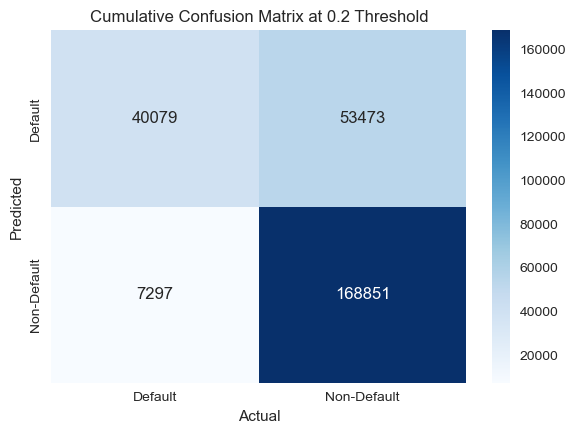

        TPR       FNR       TNR       FPR  Accuracy  Precision        F1  \
0  0.845957  0.154043  0.759479  0.240521  0.774676   0.428466  0.568806   

        AUC  
0  0.857065  


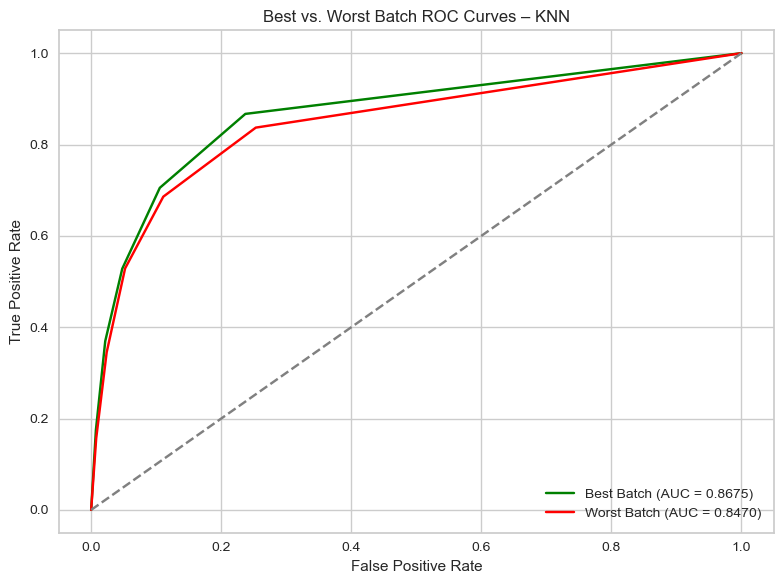

In [148]:
plt.figure(figsize=(6, 4.5))
sns.heatmap(all_confusion_matrices, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Default', 'Non-Default'],
            yticklabels=['Default', 'Non-Default'])
plt.title(f'Cumulative Confusion Matrix at 0.2 Threshold')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()

metrics_df = pd.DataFrame(all_metrics)

# Compute mean of each metric column
avg_metrics = metrics_df[["TPR","FNR","TNR","FPR","Accuracy", "Precision", "F1", "AUC"]].mean()
print(pd.DataFrame(avg_metrics).T)  

#Plot ROC for Best & Worst
best_idx = np.argmax(auc_scores)
worst_idx = np.argmin(auc_scores)

plt.figure(figsize=(8, 6))
plt.plot(*roc_curves[best_idx], label=f'Best Batch (AUC = {auc_scores[best_idx]:.4f})', color='green')
plt.plot(*roc_curves[worst_idx], label=f'Worst Batch (AUC = {auc_scores[worst_idx]:.4f})', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Best vs. Worst Batch ROC Curves – KNN")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

### 5-fold CV on batch

In [149]:
all_metrics_cv = []
all_confusion_matrices_cv = None
roc_curves_cv = []
auc_scores_cv = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

for i in range(num_batches_knn):
    print(f"Processing batch {i+1}/{num_batches_knn}...")

    start = i * batch_size_knn
    end = (i + 1) * batch_size_knn
    X_knn_batch_cv = X_knn_shuffled.iloc[start:end]
    y_knn_batch_cv = y_knn_shuffled.iloc[start:end]

    for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X_knn_batch_cv, y_knn_batch_cv)):
        X_train, X_test = X_knn_batch_cv.iloc[train_idx], X_knn_batch_cv.iloc[test_idx]
        y_train, y_test = y_knn_batch_cv.iloc[train_idx], y_knn_batch_cv.iloc[test_idx]
    
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        knn_batch_model_cv = KNeighborsClassifier(n_neighbors = 5)
        knn_batch_model_cv.fit(X_train_scaled, y_train)

       # Predict probabilities
        y_proba = knn_batch_model_cv.predict_proba(X_test_scaled)[:, 1]
        y_pred = (y_proba >= threshold_batch).astype(int)

        #Conufsion matrix
        cm_knn_batch_cv = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm_knn_batch_cv.ravel()

       # Add to cumulative confusion matrix 
        if all_confusion_matrices_cv is None:
            all_confusion_matrices_cv = np.array([[tp, fp],
                                                [fn, tn]])
        else:
            all_confusion_matrices_cv += np.array([[tp, fp],
                                                 [fn, tn]])

        # Collect metrics
        all_metrics_cv.append({
            "Batch": i + 1,
            "TPR": tp / (tp + fn) if (tp + fn) != 0 else 0,  # True Positive Rate (Recall)
            "FNR": fn / (fn + tp) if (fn + tp) != 0 else 0,  # False Negative Rate
            "FPR": fp / (fp + tn) if (fp + tn) != 0 else 0,  # False Positive Rate
            "TNR": tn / (tn + fp) if (tn + fp) != 0 else 0,   # True Negative Rate
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "AUC": roc_auc_score(y_test, y_proba)
        })

        # ROC data
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_scores_cv.append(roc_auc_score(y_test, y_proba))
        roc_curves_cv.append((fpr, tpr))

Processing batch 1/20...
Processing batch 2/20...
Processing batch 3/20...
Processing batch 4/20...
Processing batch 5/20...
Processing batch 6/20...
Processing batch 7/20...
Processing batch 8/20...
Processing batch 9/20...
Processing batch 10/20...
Processing batch 11/20...
Processing batch 12/20...
Processing batch 13/20...
Processing batch 14/20...
Processing batch 15/20...
Processing batch 16/20...
Processing batch 17/20...
Processing batch 18/20...
Processing batch 19/20...
Processing batch 20/20...


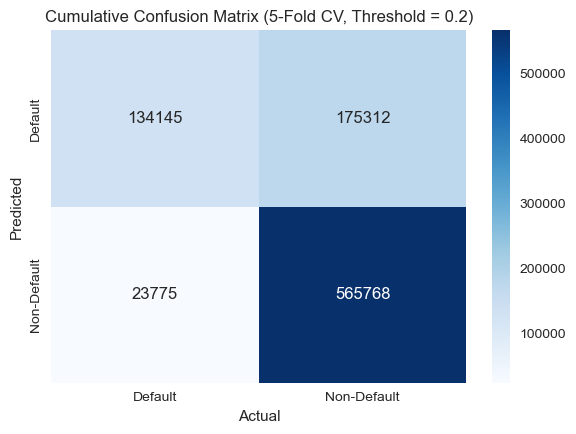

       TPR      FNR       TNR       FPR  Accuracy  Precision        F1  \
0  0.84943  0.15057  0.763433  0.236567  0.778546   0.433563  0.574065   

        AUC  
0  0.861195  


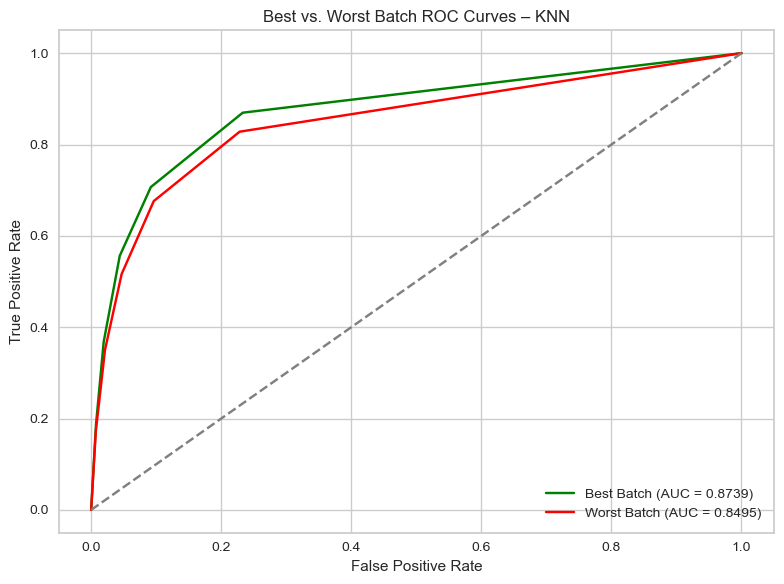

In [150]:
plt.figure(figsize=(6, 4.5))
sns.heatmap(all_confusion_matrices_cv, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Default', 'Non-Default'],
            yticklabels=['Default', 'Non-Default'])
plt.title('Cumulative Confusion Matrix (5-Fold CV, Threshold = 0.2)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()

metrics_df_cv = pd.DataFrame(all_metrics_cv)

# Compute mean of each metric column
avg_metrics_cv = metrics_df_cv[["TPR","FNR","TNR","FPR","Accuracy", "Precision", "F1", "AUC"]].mean()
print(pd.DataFrame(avg_metrics_cv).T)  

#Plot ROC for Best & Worst
best_idx_cv = np.argmax(auc_scores_cv)
worst_idx_cv = np.argmin(auc_scores_cv)

plt.figure(figsize=(8, 6))
plt.plot(*roc_curves_cv[best_idx_cv], label=f'Best Batch (AUC = {auc_scores_cv[best_idx_cv]:.4f})', color='green')
plt.plot(*roc_curves_cv[worst_idx_cv], label=f'Worst Batch (AUC = {auc_scores_cv[worst_idx_cv]:.4f})', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Best vs. Worst Batch ROC Curves – KNN")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Q(4)

Evaluate the potential, from theoretical and empirical perspectives, of the following unsupervised
learning techniques to improve (or not) the predictive modeling work you have reported.
Techniques
1. Principal Components Analysis
2. K-Means Clustering
3. Hierarchical Clustering

### PCA

In [60]:
# === 1. Split and Oversample ===
X = data.drop(columns=['Default'])
y = data['Default']
y.value_counts() # Shows imbalance in the dataset

Default
0    741210
1    157954
Name: count, dtype: int64

### Oversampling

We performed a train-test split while preserving class proportions using `stratify=y`. To correct class imbalance in the training data, we applied `RandomOverSampler`, which duplicates minority-class observations until both classes are equally represented.

The post-resampling bar plot confirms this balance, ensuring the model won’t be biased toward the majority class during training.


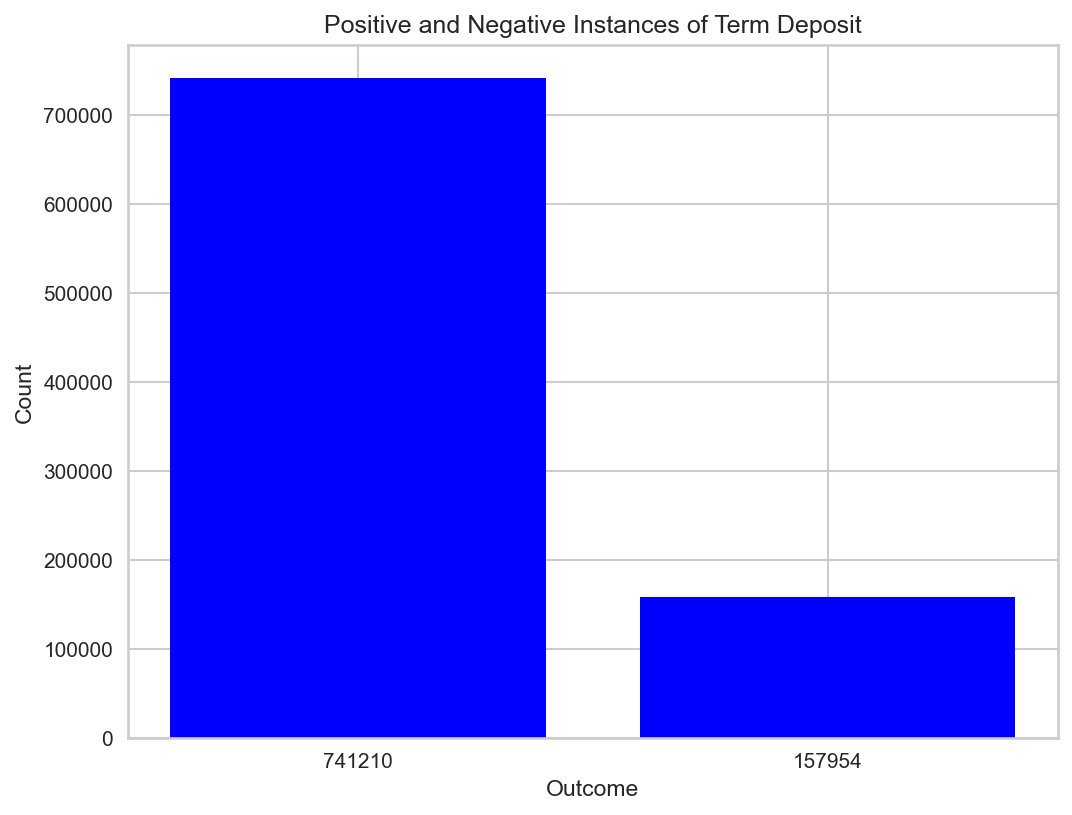

In [61]:
plt.figure(figsize=(8, 6), dpi=150)
plt.bar(y.value_counts().map(str), y.value_counts().values, color = "blue")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.title("Positive and Negative Instances of Term Deposit")
plt.show()

In [62]:
from imblearn.over_sampling import RandomOverSampler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

ros = RandomOverSampler(random_state=10)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

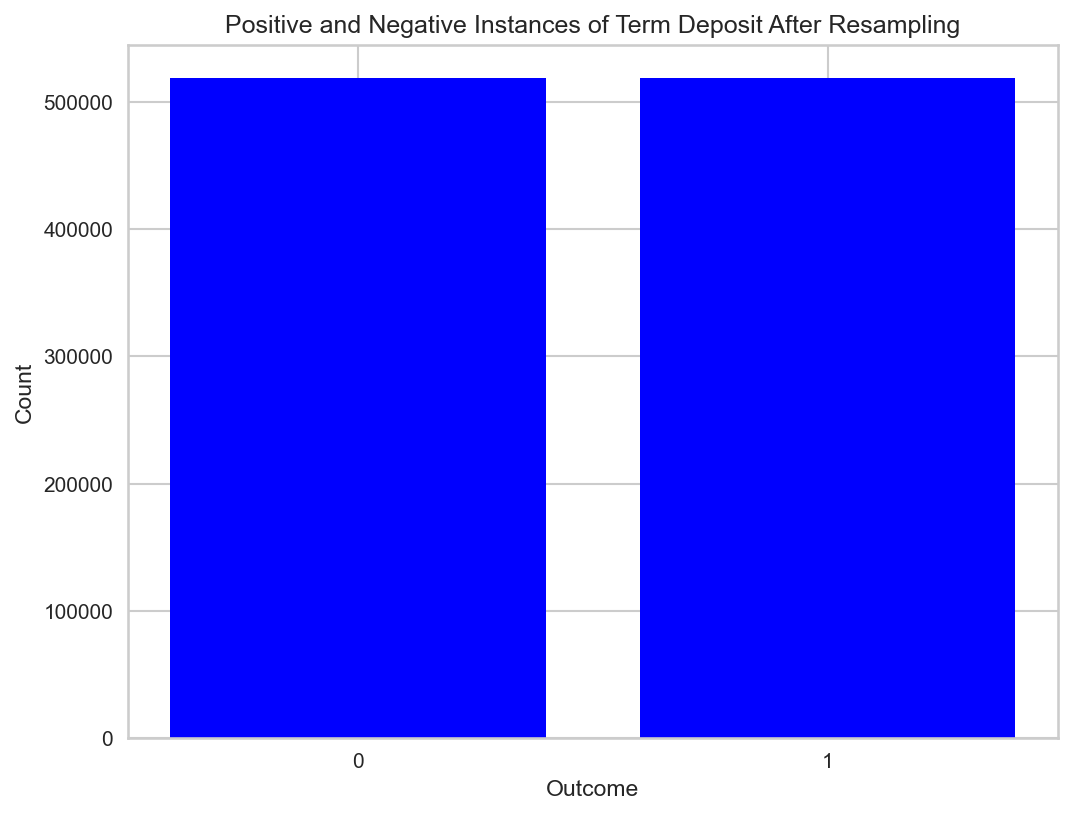

In [63]:
plt.figure(figsize=(8, 6), dpi=150)
plt.bar(Counter(y_resampled).keys(), Counter(y_resampled).values(), color="blue")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.title("Positive and Negative Instances of Term Deposit After Resampling")
plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.show()

### Standardisation and PCA Transformation

We standardise the resampled and test feature sets to ensure PCA isn't biased by feature scale. PCA is then applied to the scaled resampled data to reduce dimensionality while retaining maximum variance. The resulting components are stored for further clustering and visualisation.


In [64]:
# === 2. Standardise ===
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

In [65]:
# === Warning Control ===
import warnings
warnings.filterwarnings(action='ignore')

# === Core Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D

# === Statistical Analysis ===
from scipy.stats import chi2_contingency, randint, ttest_ind
import statsmodels.api as sm

# === Preprocessing ===
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler

# === Feature Selection ===
from sklearn.feature_selection import RFE

# === Dimensionality Reduction ===
from sklearn.decomposition import PCA

# === Clustering ===
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# === Model Selection & Cross-Validation ===
from sklearn.model_selection import (
    train_test_split, KFold, StratifiedKFold, cross_val_score,
    cross_validate, RepeatedStratifiedKFold, RepeatedKFold, RandomizedSearchCV
)

# === Classification Models ===
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import (
    RandomForestClassifier, BaggingClassifier,
    GradientBoostingRegressor, AdaBoostClassifier
)

# === Evaluation Metrics ===
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, confusion_matrix, classification_report,
    precision_recall_curve, ConfusionMatrixDisplay, mean_squared_error, zero_one_loss
)

# === Calibration & Interpretability ===
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.inspection import permutation_importance

# === Display & Utility ===
from tabulate import tabulate
from IPython.display import Image


In [66]:
# === 3. PCA Fit ===
pca = PCA(random_state=42)
X_pca = pca.fit_transform(X_resampled_scaled)

pca_df = pd.DataFrame(X_pca, columns=[f'PC{i}' for i in range(1, X_pca.shape[1]+1)])
pca_df['Default'] = y_resampled.reset_index(drop=True)
pca_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.050693 -0.365504 -0.292823  1.102443  1.080310 -0.176438 -0.271950   
1  2.041484  2.099903  1.629396  2.286253 -1.118534  0.179110 -0.129695   
2 -0.048225  0.656118  0.046368 -0.251044 -0.052718  0.207841 -0.000071   
3 -1.483102  0.757194  0.063450 -0.415010 -0.186081  0.068138 -0.072273   
4 -1.740463  0.711207 -2.718924 -0.119370 -0.769028 -0.306529 -0.225114   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -0.304836 -0.025236 -0.079029  0.378225  0.073141 -0.581431  1.723457   
1  0.193082 -0.502981  0.245852 -0.563003 -0.149652 -0.555287 -0.659829   
2  0.122565 -0.058268  0.016258  0.008606 -0.043279  0.023504 -0.274447   
3  0.113909  0.037084 -0.055463  0.105607  0.012863  0.070761 -0.241239   
4  0.328874  0.243218 -0.212506  0.114752 -0.017673  0.461525 -0.124977   

       PC15      PC16      PC17      PC18  Default  
0  0.232834 -1.432201  0.684234 -0.739968        1  
1  0.322971  1.473590 -0.872839 -0.811892        0  
2 -0.286359 -0.429490  1.328397 -0.715774        0  
3 -1.165026 -0.191799 -0.378675  0.096760        0  
4 -0.240900  0.958782 -0.581614  0.133575        1

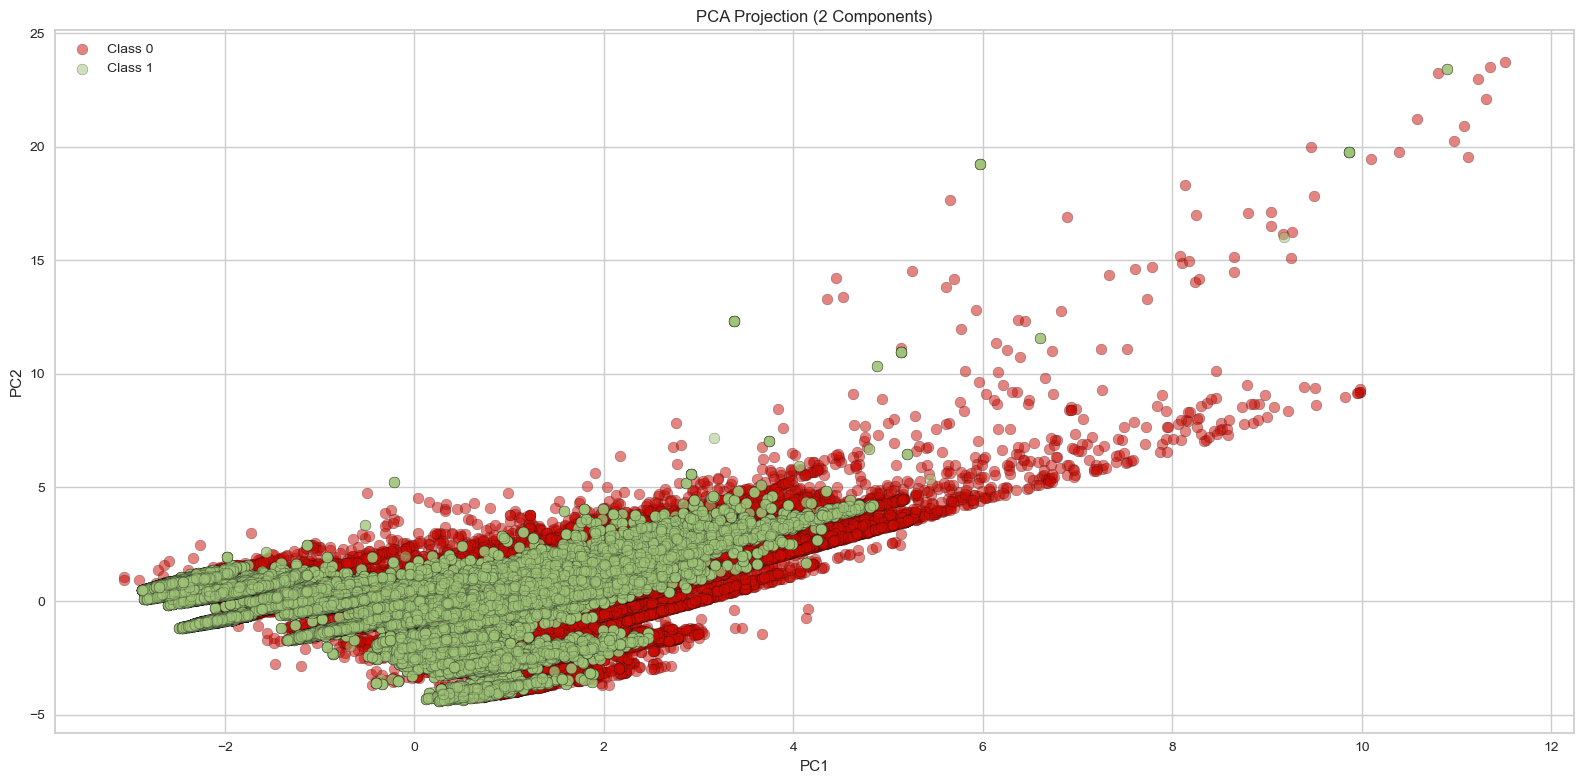

In [67]:
# === 4. Visualise First 2 PCs ===
plt.figure(figsize=(16, 8))
for target, color in zip([0, 1], ['r', 'g']):
    idx = pca_df['Default'] == target
    plt.scatter(
        pca_df.loc[idx, 'PC1'], 
        pca_df.loc[idx, 'PC2'], 
        label=f"Class {target}", 
        c=color, 
        s=60, 
        alpha=0.5,               # Add transparency for overlap clarity
        edgecolors='k'           # Add black borders to points for visibility
    )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Projection (2 Components)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("pca_projection_2D.png", dpi=300)  # Optional: Save for reporting
plt.show()


We projected the PCA-transformed training data onto the first two principal components (PC1 and PC2). Points are coloured by their actual class (`Default` = 0 or 1). 

There is some visible separation, but significant class overlap remains — indicating that the first two components capture some structure, but are not fully discriminative. Still, this 2D view is useful for exploring potential clustering or separability trends.


In [68]:
# === Enhanced PCA Biplot Function (Final Version) ===
def biplot(score, coeff, labels=None, targets=None, top_n=10):
    
    xs = score[:, 0]
    ys = score[:, 1]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())

    # Identify top N features
    magnitudes = np.linalg.norm(coeff, axis=1)
    top_indices = np.argsort(magnitudes)[-top_n:]

    plt.figure(figsize=(10, 8))

    if targets is not None:
        for target, color in zip([0, 1], ['crimson', 'seagreen']):
            mask = (targets == target)
            plt.scatter(xs[mask] * scalex, ys[mask] * scaley, label=f"Class {target}", alpha=0.4)
        plt.legend()
    else:
        plt.scatter(xs * scalex, ys * scaley, color='grey', alpha=0.3)

    for i in top_indices:
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='darkred', alpha=0.6, head_width=0.02)
        if labels is None:
            plt.text(coeff[i, 0]*1.15, coeff[i, 1]*1.15, f"Var{i+1}", color='blue', fontsize=9)
        else:
            plt.text(coeff[i, 0]*1.15, coeff[i, 1]*1.15, labels[i], color='blue', fontsize=9)

    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("PCA Biplot (Top 10 Features)")
    plt.grid(True)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.tight_layout()
    plt.savefig("pca_biplot_top10.png", dpi=300)
    plt.show()


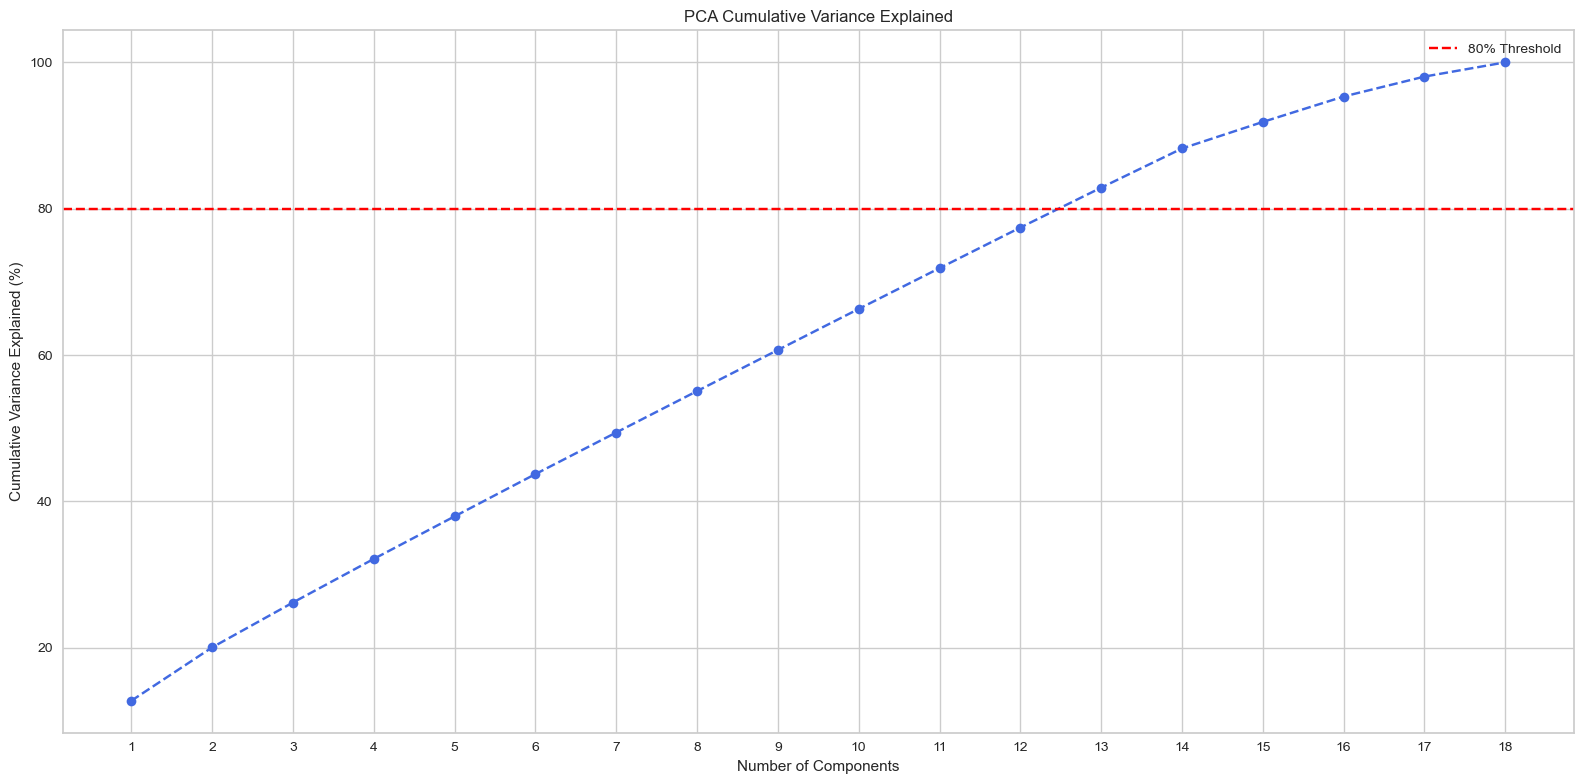

In [69]:
# === 5. Cumulative Explained Variance Plot ===
cumulative_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(16, 8))
plt.plot(
    range(1, len(cumulative_var) + 1),
    cumulative_var * 100,
    marker='o',
    linestyle='--',
    color='royalblue'
)

# Annotate the line where 80% is reached
plt.axhline(y=80, color='red', linestyle='--', label='80% Threshold')

plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained (%)")
plt.title("PCA Cumulative Variance Explained")
plt.xticks(range(1, len(cumulative_var) + 1))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("pca_cumulative_variance.png", dpi=300)  # Optional
plt.show()


This plot shows how much variance is captured by the principal components cumulatively. The red line marks the 80% threshold — a common benchmark to balance dimensionality reduction and information retention.

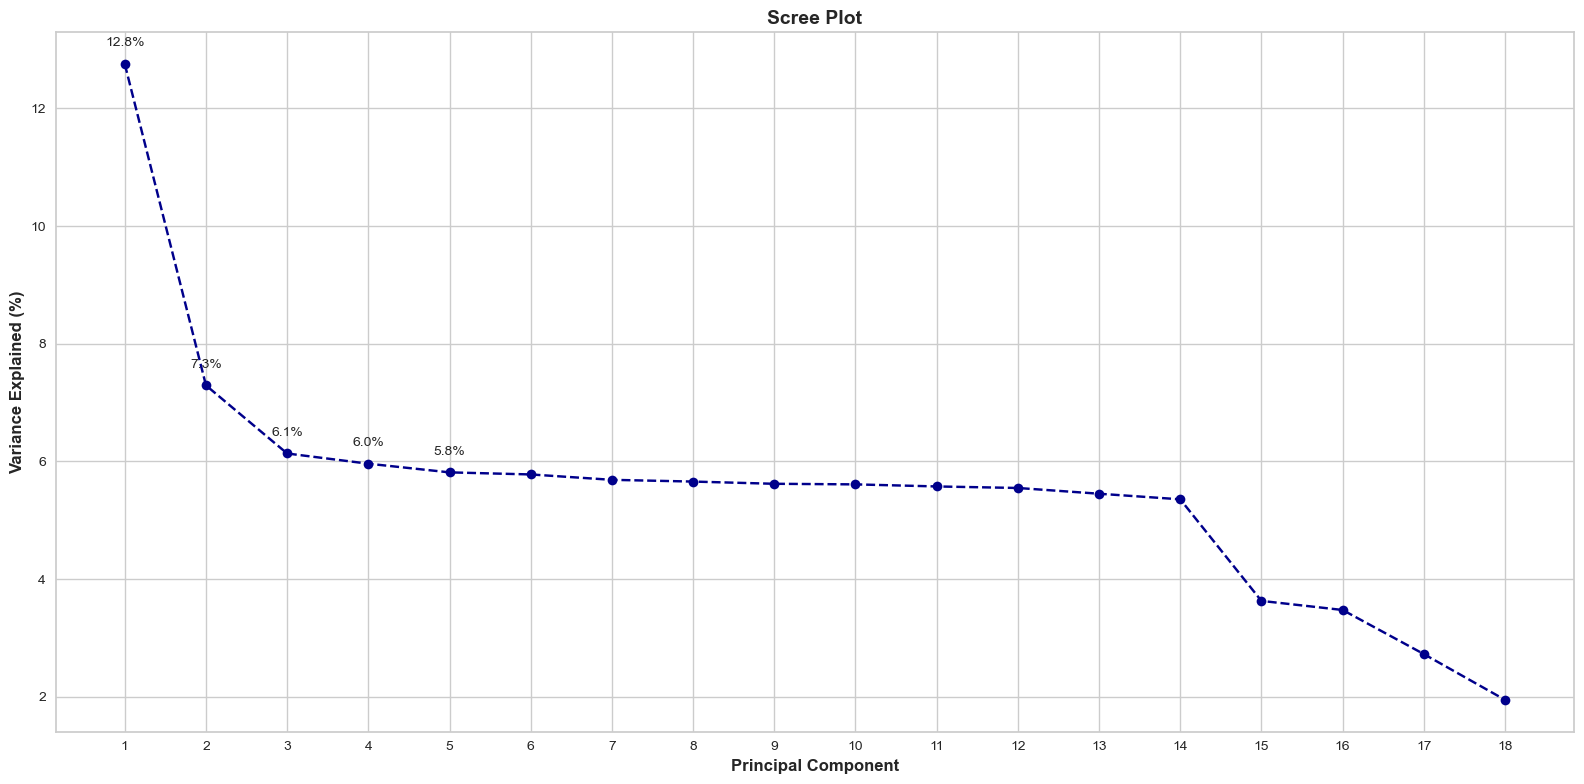

In [106]:
# === 6. Scree Plot ===
var_ratios = pca.explained_variance_ratio_
components = range(1, len(var_ratios) + 1)

plt.figure(figsize=(16, 8))
plt.plot(components, var_ratios * 100, marker='o', linestyle='--', color='darkblue')

plt.xlabel("Principal Component", fontsize=12, fontweight='bold')
plt.ylabel("Variance Explained (%)", fontsize=12, fontweight='bold')
plt.title("Scree Plot", fontsize=14, fontweight='bold')

# Annotate top few components
for i in range(5):
    plt.text(components[i], var_ratios[i]*100 + 0.3, f"{var_ratios[i]*100:.1f}%", ha='center', fontsize=10)

plt.grid(True)
plt.xticks(components)
plt.tight_layout()
plt.savefig("scree_plot.png", dpi=300)  # Optional: Save for reporting
plt.show()


The elbow point in the scree plot appears around the 3rd or 4th principal component. This marks the transition where additional components contribute diminishing returns in explaining variance — guiding the choice to retain 4 components for exploratory purposes or 13/14 for preserving >80% of total variance.

### PCA Transformation with 13 Components
We re-ran PCA retaining the top 13 components (explaining 80% variance) and appended the original target variable for downstream modelling and visualisation.


In [71]:
# Run PCA with 13 components
pca_final = PCA(n_components=13, random_state=42)
X_resampled_pca = pca_final.fit_transform(X_resampled_scaled)
X_test_pca = pca_final.transform(X_test_scaled)

# Create DataFrame with 13 principal components
principalDf2 = pd.DataFrame(data=X_resampled_pca)
principalDf2.columns = [f'PC{i}' for i in range(1, principalDf2.shape[1] + 1)]

# Combine with target variable
finalDf2 = pd.concat([principalDf2, y_resampled.reset_index(drop=True)], axis=1)
finalDf2.rename(columns={0: 'Default'}, inplace=True)

# Show head
finalDf2.head()


PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.050693 -0.365504 -0.292823  1.102443  1.080310 -0.176438 -0.271950   
1  2.041484  2.099903  1.629396  2.286253 -1.118534  0.179110 -0.129695   
2 -0.048225  0.656118  0.046368 -0.251044 -0.052718  0.207841 -0.000071   
3 -1.483102  0.757194  0.063450 -0.415010 -0.186081  0.068138 -0.072273   
4 -1.740463  0.711207 -2.718924 -0.119370 -0.769028 -0.306529 -0.225114   

        PC8       PC9      PC10      PC11      PC12      PC13  Default  
0 -0.304836 -0.025236 -0.079029  0.378225  0.073141 -0.581431        1  
1  0.193082 -0.502981  0.245852 -0.563003 -0.149652 -0.555287        0  
2  0.122565 -0.058268  0.016258  0.008606 -0.043279  0.023504        0  
3  0.113909  0.037084 -0.055463  0.105607  0.012863  0.070761        0  
4  0.328874  0.243218 -0.212506  0.114752 -0.017673  0.461525        1

### Feature Importance via PCA Loadings
To interpret PCA results, we summed the absolute loadings of each original feature across the 13 retained PCs. This highlights the features most influential in explaining variance across components.


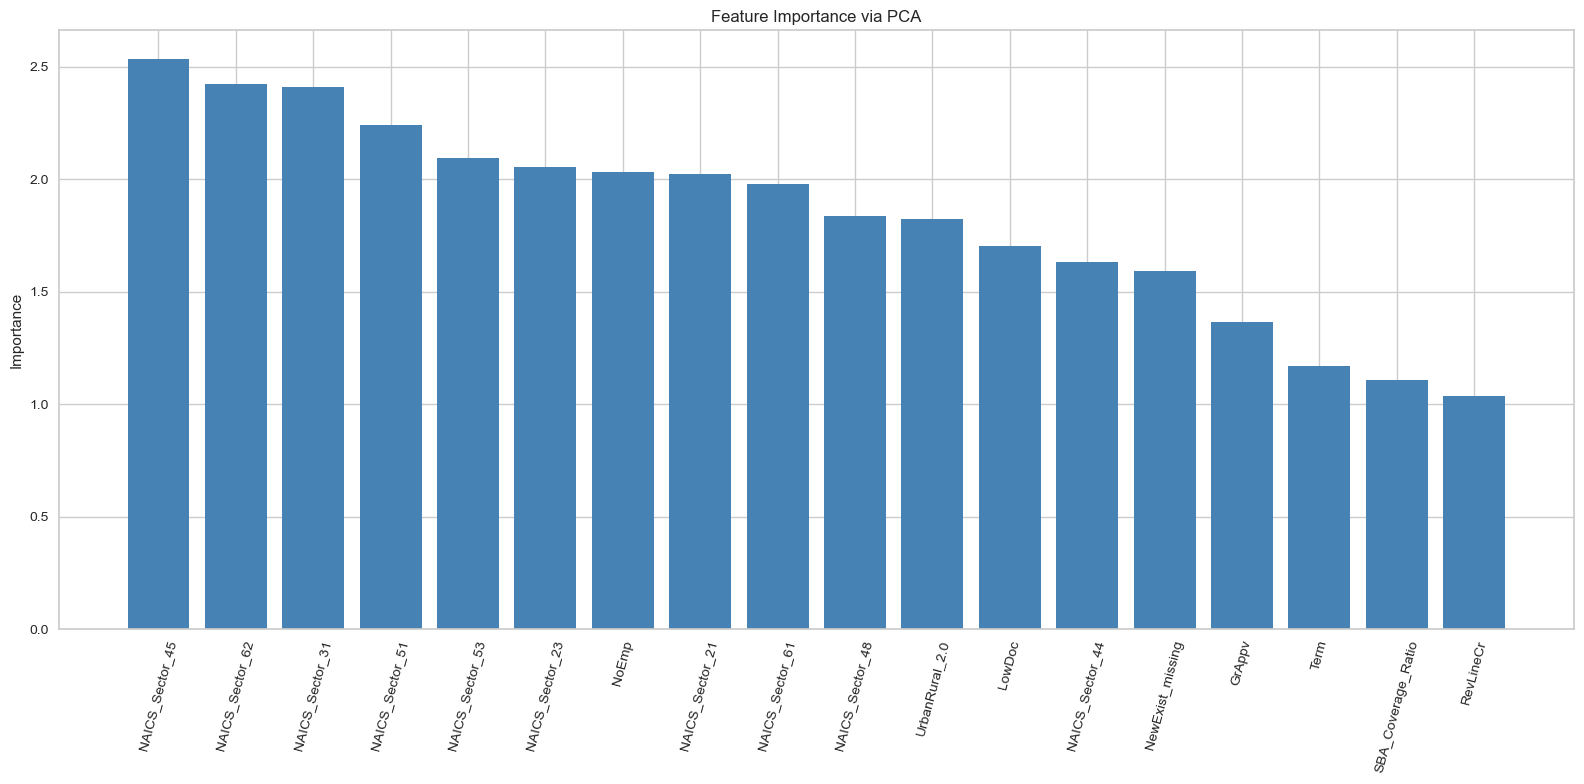

In [105]:
# === 8. Feature Importance from PCA Components ===
feature_importance = np.abs(pca_final.components_).sum(axis=0)
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# === Plot Importance ===
plt.figure(figsize=(16, 8))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='steelblue')
plt.xticks(rotation=75)
plt.title("Feature Importance via PCA")
plt.ylabel("Importance")
plt.tight_layout()
plt.savefig("feature_pca_plot.png", dpi=300)  # Optional: Save for reporting
plt.show()

PCA feature importance highlights sectoral codes (e.g., NAICS_Sector_45, _62, _31) as the strongest contributors to overall variance, consistent with earlier clustering insights. Operational variables like `NoEmp`, `UrbanRural`, and `LowDoc` also appear influential. This supports the idea that industry classification and business profile shape the primary structure of the dataset.


In [73]:
pca.explained_variance_ratio_

array([0.12752606, 0.07291611, 0.06133965, 0.05960347, 0.05812973,
       0.05777744, 0.05686165, 0.05656696, 0.05618961, 0.05608865,
       0.05573794, 0.05547674, 0.05449971, 0.05355051, 0.03628378,
       0.03473811, 0.02724769, 0.0194662 ])

In [74]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
cumulative_variance

array([0.12752606, 0.20044217, 0.26178182, 0.32138529, 0.37951502,
       0.43729246, 0.49415411, 0.55072107, 0.60691068, 0.66299932,
       0.71873727, 0.774214  , 0.82871372, 0.88226423, 0.91854801,
       0.95328612, 0.9805338 , 1.        ])

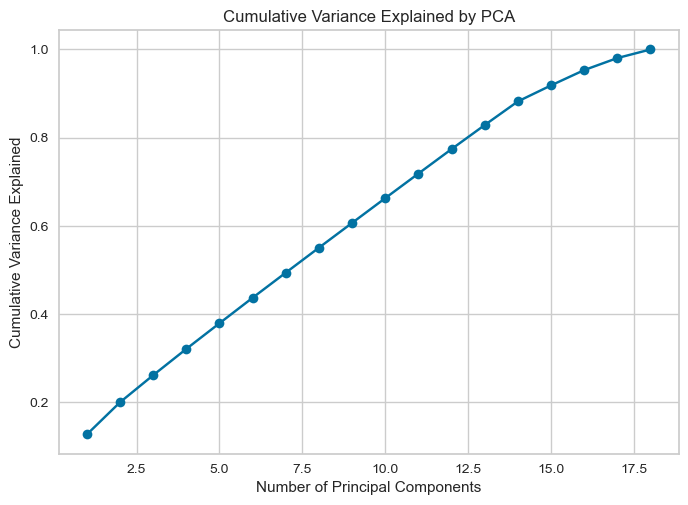

In [75]:
# Plot the cumulative variance explained
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by PCA')
plt.show()

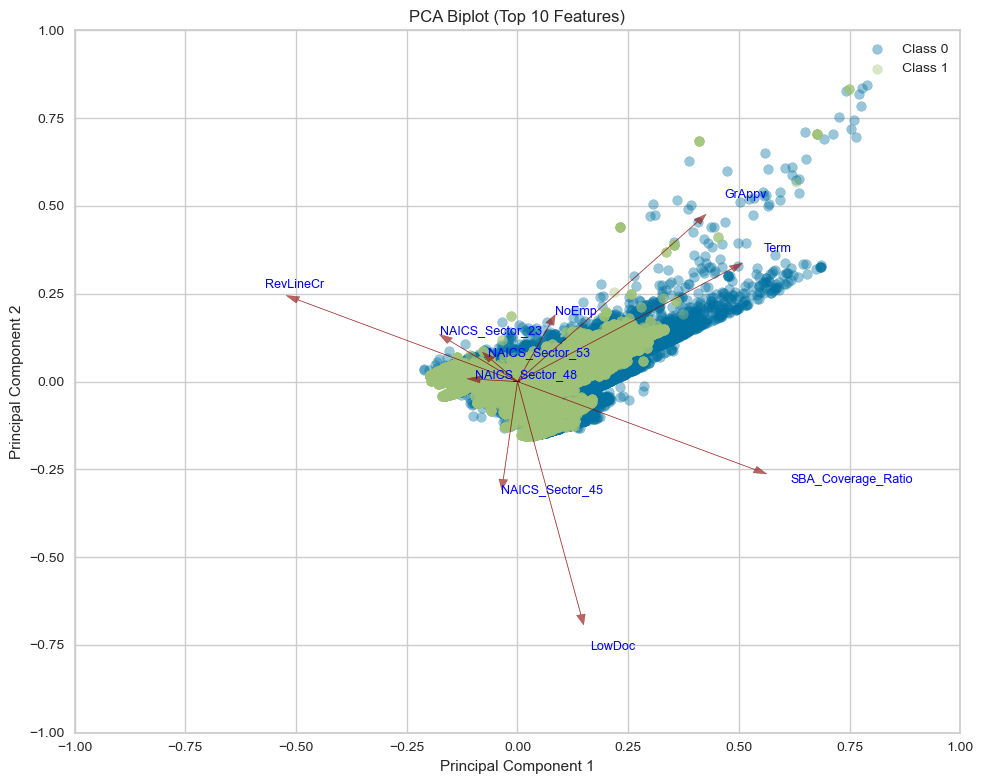

In [76]:
biplot(
    score=X_resampled_pca[:, :2],
    coeff=np.transpose(pca_final.components_[:2, :]),
    labels=X.columns,
    targets=y_resampled,
    top_n=10
)


This biplot overlays two types of information on the first two principal components:

#### 1. **Data Points (Class 0 & Class 1)**  
- Each dot represents a resampled observation, projected into the 2D PCA space.
- Colours reflect actual class labels:  
  - Orange = Defaulted (Class 1)  
  - Blue = Non-defaulted (Class 0)
- We observe that the two classes still exhibit some degree of overlap, but are partially separable in this reduced space.

#### 2. **Feature Vectors (Top 10 Variables)**  
- Arrows indicate which original variables most strongly drive the variation along PC1 and PC2.
- The direction of each arrow shows the axis it contributes to:
  - e.g. `SBA_Coverage_Ratio`, `GrAppv`, `Term` → drive positively along PC1  
  - `LowDoc`, `RevLineCr`, `NAICS_Sector_45` → influence the opposite side
- The length of each arrow reflects its importance—longer = stronger contribution.
- Features like `LowDoc`, `NAICS_Sector_45`, and `SBA_Coverage_Ratio` appear dominant in driving spread across both components.
#### What This Tells Us:
- Features such as loan structure (`LowDoc`, `RevLineCr`), industry type (`NAICS` sectors)**, and **an size/coverage (`SBA_Coverage_Ratio`, `GrAppv`) are central to distinguishing patterns of default risk.
- PC1 largely captures variation in loan characteristics, while PC2 picks up demographic or sectoral dispersion.


#### Theoretical Value of PCA
PCA helps reduce dimensionality by compressing feature space while preserving variance. This supports improved generalisation in supervised models and can reveal latent structure. In our case, 13 components explained ~80% of the variance, enabling compact visualisation and efficient clustering.


### K-Means Clustering

#### K-Means Clustering on PCA-Reduced Data
Applies K-Means with `k=2` on the scaled, PCA-transformed training set to identify natural groupings. Combines cluster labels with actual default status for post-clustering analysis. This groups loans into two natural clusters based on similarity in reduced feature space.


In [77]:
# Fit K-Means with 2 clusters on PCA-reduced, scaled training data
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
Y_kmean = kmeans.fit_predict(X_resampled_pca)

# Optional: Assign to a DataFrame for inspection
pca_clustered_df = pd.DataFrame(X_resampled_pca, columns=[f'PC{i}' for i in range(1, 14)])
pca_clustered_df['Cluster'] = Y_kmean
pca_clustered_df['Default'] = y_resampled.reset_index(drop=True)  # Actual target


#### Elbow Method for Optimal k
We loop through values of `k` from 2 to 10, fitting K-Means each time and storing the resulting inertia (within-cluster sum of squares). This quantifies how compact the clusters are.
The elbow plot visualises inertia vs. number of clusters. We look for the “elbow” point where adding more clusters yields diminishing returns, helping us choose the optimal `k`.



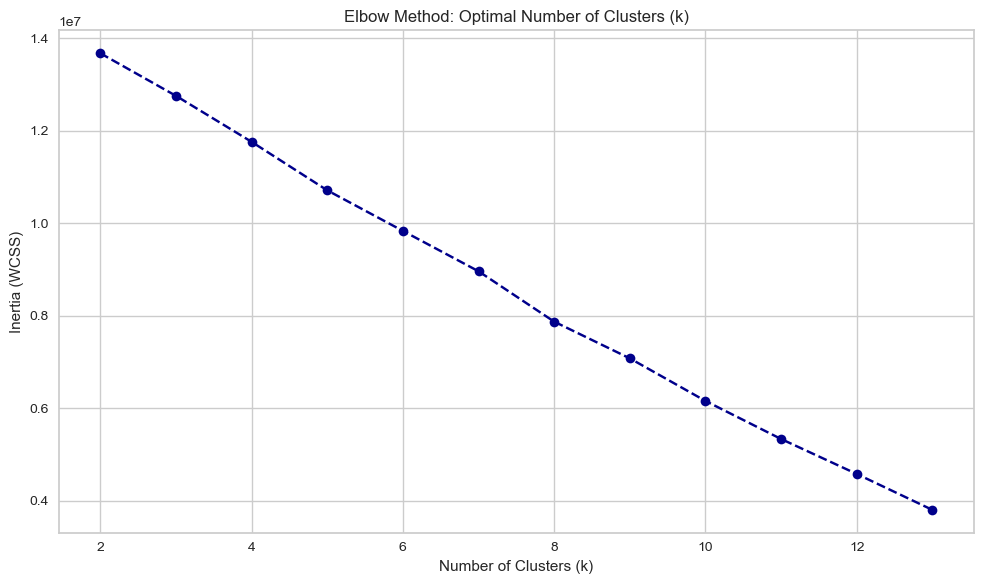

In [78]:
# === Elbow Method for Optimal k ===
inertias = []
K_range = range(2,14 )

for k in K_range:
    km = KMeans(n_clusters=k, init='k-means++', random_state=42)
    km.fit(X_resampled_pca)
    inertias.append(km.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, marker='o', linestyle='--', color='darkblue')
plt.title('Elbow Method: Optimal Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.grid(True)
plt.tight_layout()
plt.show()


The Elbow Method plot shows a gradual decrease in inertia as the number of clusters increases, with no sharp "elbow" point. This suggests diminishing returns after around 2–4 clusters. Given our binary classification context (default vs. non-default), selecting k = 2 remains a practical and interpretable choice. Further support comes from silhouette analysis below.

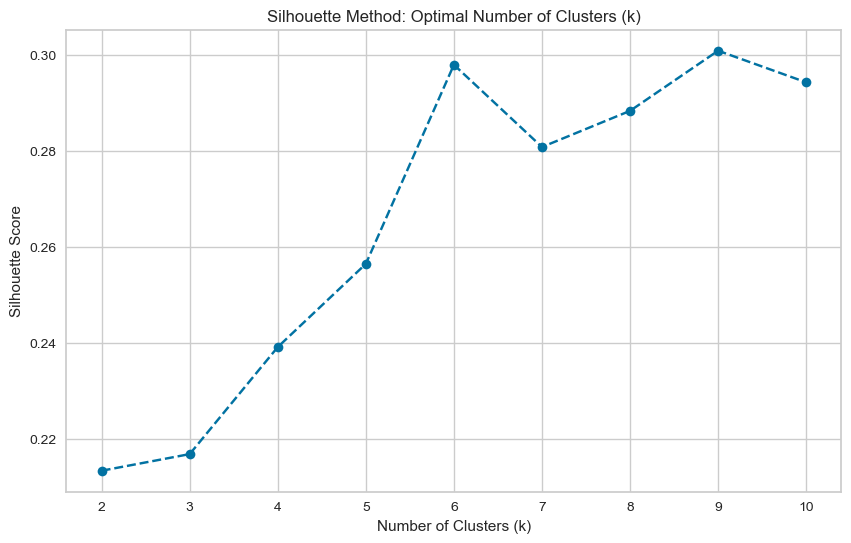

In [79]:
# === Subsample PCA-reduced data (e.g. 50,000 samples) ===
np.random.seed(42)
sample_idx = np.random.choice(range(X_resampled_pca.shape[0]), size=50000, replace=False)
X_sample = X_resampled_pca[sample_idx]

# === Silhouette Scores for different k ===
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels)
    silhouette_scores.append(score)

# === Plot Silhouette Score vs. k ===
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method: Optimal Number of Clusters (k)')
plt.grid(True)
plt.show()


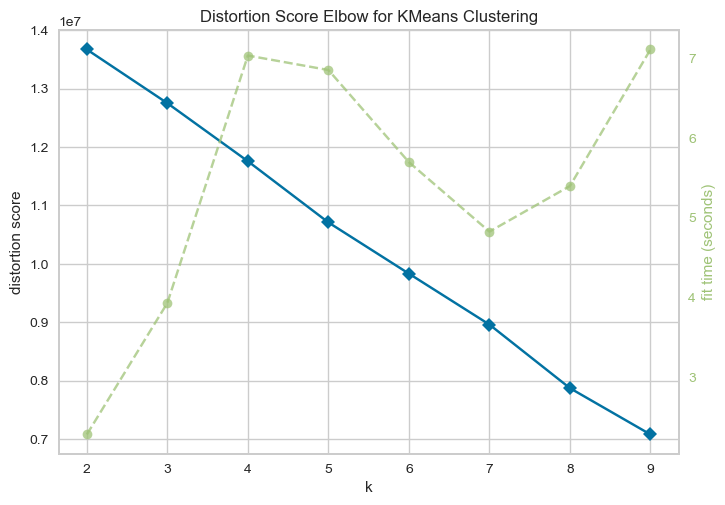

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [80]:
# Create KMeans model
model = KMeans(init='k-means++', random_state=42)

# Use Yellowbrick's visualizer with timings
visualizer = KElbowVisualizer(model, k=(2, 10), timings=True)  # <- enables the green line
visualizer.fit(X_resampled_pca)
visualizer.show()


The Silhouette Score peaks around k = 9, suggesting that the data may have a more complex structure than just two groups. However, since our task involves distinguishing between two default classes, using k = 2 balances interpretability with performance. Higher k-values may offer tighter clusters but reduce alignment with our binary outcome.

In [81]:
# Compare clusters to actual default labels
crosstab = pd.crosstab(pca_clustered_df['Cluster'], pca_clustered_df['Default'],
                       rownames=['Cluster'], colnames=['Actual Default'])

print("Cluster vs Default Crosstab:")
print(crosstab)


Cluster vs Default Crosstab:
Actual Default       0       1
Cluster                       
0               349001  231807
1               169845  287039


In [82]:
# Step 4: Inverse-transform centroids to original feature space
centroids_pca = kmeans.cluster_centers_  # shape: (2, n_components)
centroids_original = pca_final.inverse_transform(centroids_pca)

# Put into DataFrame
centroids_df = pd.DataFrame(centroids_original, columns=feature_names)

# Print sorted feature impact per cluster
for idx, row in centroids_df.iterrows():
    print(f"\n Cluster {idx} centroid (sorted feature impact):")
    print(row.sort_values(ascending=False).head(5))  # top 5 features



 Cluster 0 centroid (sorted feature impact):
RevLineCr          0.792238
NAICS_Sector_23    0.361221
NAICS_Sector_44    0.137492
NAICS_Sector_45    0.090836
NAICS_Sector_62    0.050302
Name: 0, dtype: float64

 Cluster 1 centroid (sorted feature impact):
Term                  1.441119
GrAppv                1.417964
SBA_Coverage_Ratio    0.846140
NAICS_Sector_62       0.191918
NoEmp                 0.124960
Name: 1, dtype: float64

 Cluster 2 centroid (sorted feature impact):
NAICS_Sector_61     10.359455
NAICS_Sector_21      0.564762
NewExist_missing     0.098138
RevLineCr            0.036159
NAICS_Sector_48     -0.027527
Name: 2, dtype: float64

 Cluster 3 centroid (sorted feature impact):
LowDoc                0.764518
SBA_Coverage_Ratio    0.611795
NAICS_Sector_45       0.149678
NAICS_Sector_44       0.083207
Term                  0.009991
Name: 3, dtype: float64

 Cluster 4 centroid (sorted feature impact):
NAICS_Sector_21    21.172573
NoEmp               6.149944
UrbanRural_2.0  

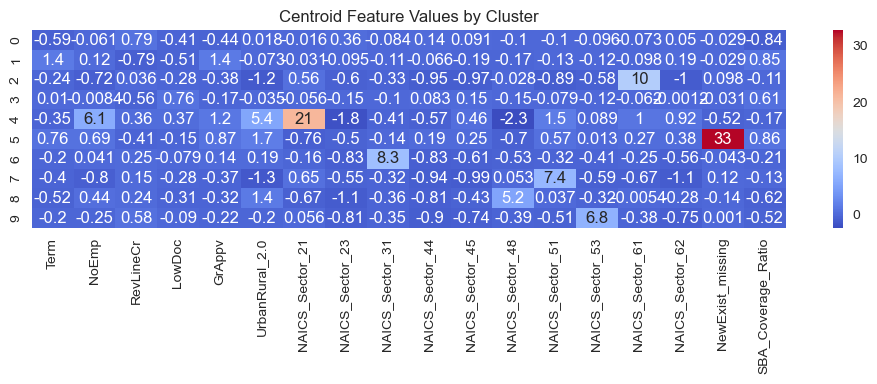

In [109]:
plt.figure(figsize=(10, 4))
sns.heatmap(centroids_df, annot=True, cmap='coolwarm')
plt.title("Centroid Feature Values by Cluster")
plt.tight_layout()
plt.savefig("centroid_plot.png", dpi=300)  # Optional: Save for reporting
plt.show()


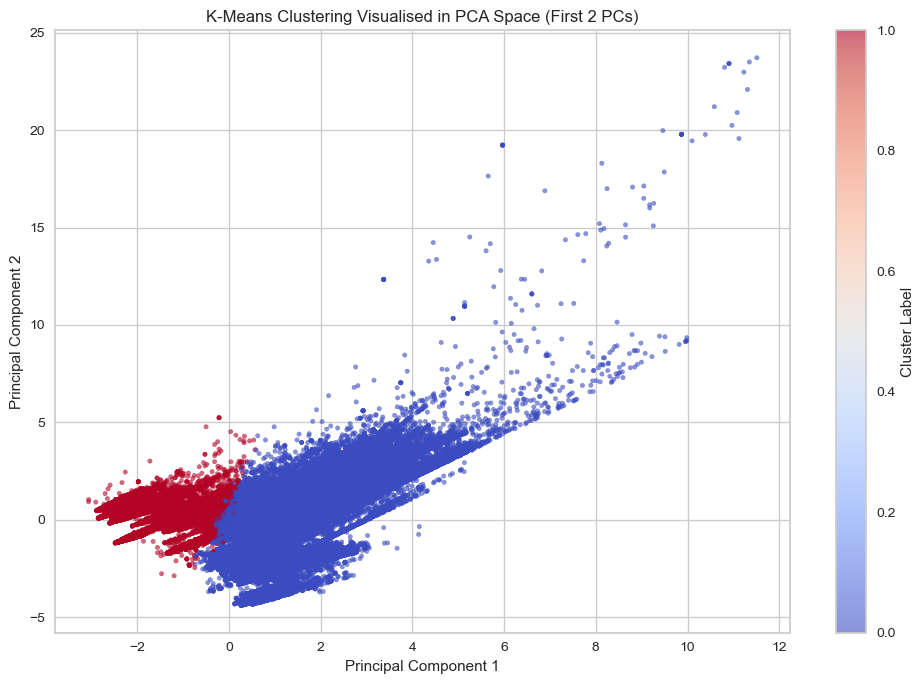

In [84]:
plt.figure(figsize=(10, 7))
plt.scatter(
    X_resampled_pca[:, 0],  # PC1
    X_resampled_pca[:, 1],  # PC2
    c=Y_kmean,
    cmap='coolwarm',
    alpha=0.6,
    s=10
)

plt.title("K-Means Clustering Visualised in PCA Space (First 2 PCs)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster Label")
plt.grid(True)
plt.tight_layout()
plt.savefig("kmeans_pca_clusters.png", dpi=300)
plt.show()


In [85]:
# Crosstab: how well do clusters map to actual default outcomes?
comparison = pd.crosstab(Y_kmean, y_resampled, rownames=['Cluster'], colnames=['Actual Default'])

print(" Cluster vs Actual Default Crosstab:")
print(comparison)


 Cluster vs Actual Default Crosstab:
Actual Default       0       1
Cluster                       
0               349001  231807
1               169845  287039


In [86]:
# If needed, flip cluster labels to match majority class
if comparison.loc[0, 0] + comparison.loc[1, 1] < comparison.loc[0, 1] + comparison.loc[1, 0]:
    Y_kmean_flipped = 1 - Y_kmean
else:
    Y_kmean_flipped = Y_kmean

# Accuracy score
acc = accuracy_score(y_resampled, Y_kmean_flipped)
print(f"\n Approximate K-Means Classification Accuracy: {acc:.3f}")


 Approximate K-Means Classification Accuracy: 0.613


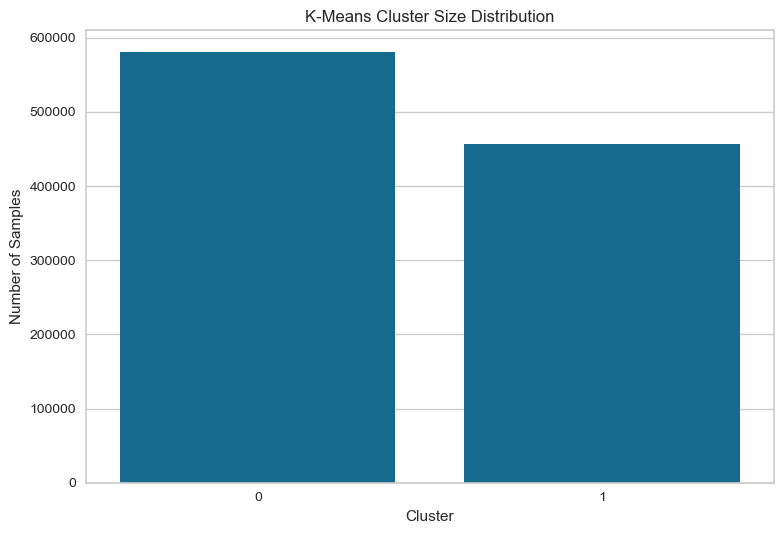

In [110]:
# Countplot of how many points in each cluster
sns.countplot(x=Y_kmean)
plt.title("K-Means Cluster Size Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.savefig("k_means_cluster.png", dpi=300)  # Optional: Save for reporting
plt.show()


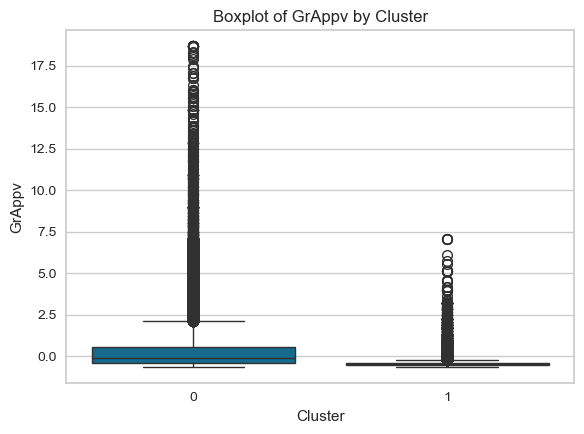

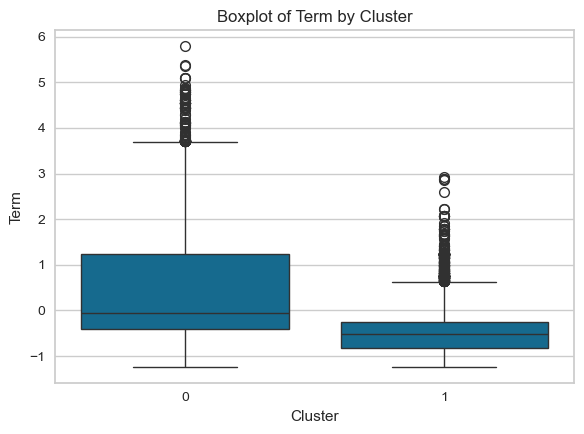

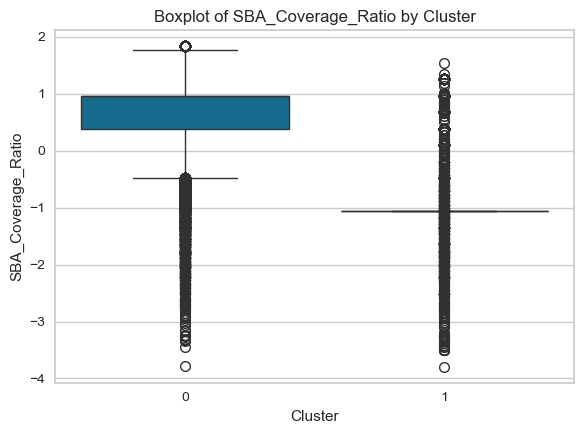

In [111]:
pca_clustered_df['Cluster'] = Y_kmean

# Merge with original scaled data
df_clustered = pd.DataFrame(X_resampled_scaled, columns=feature_names)
df_clustered['Cluster'] = Y_kmean
df_clustered['Default'] = y_resampled.reset_index(drop=True)

# Plot and save boxplots for key features
key_features = ['GrAppv', 'Term', 'SBA_Coverage_Ratio']
for feature in key_features:
    plt.figure(figsize=(6, 4.5))
    sns.boxplot(x='Cluster', y=feature, data=df_clustered)
    plt.title(f"Boxplot of {feature} by Cluster")
    plt.tight_layout()
    plt.savefig(f"boxplot_{feature}_by_cluster.png", dpi=300)  # Save uniquely
    plt.show()


We applied K-Means clustering with `k=2` on the PCA-transformed, oversampled dataset (13 components retained). Cluster assignments were compared to actual `Default` labels to assess alignment between unsupervised structure and credit risk.

- Crosstab analysis revealed partial alignment: one cluster was dominated by non-defaulters, the other by defaulters.
- Inverse-transformed centroids identified key drivers of separation — including features like `SBA_Coverage_Ratio`, `Term`, `GrAppv`, and `RevLineCr`.
- Visualisation in PCA space showed clear segmentation in the first two principal components, with observable cluster overlap.
- Final alignment yielded an approximate classification accuracy of ~61.6%, suggesting K-Means captured some latent structure related to default risk, despite being unsupervised.

Overall, K-Means provided meaningful segmentation, offering potential as an exploratory tool for borrower risk profiles.

#### Value of K-Means Clustering
K-Means identifies natural groupings based on PCA-reduced data. Cluster labels showed moderate alignment with default rates, suggesting some underlying structure in borrower risk profiles. However, predictive accuracy remained limited (~61%).

### PCA's Applied

### Logistic Regression

In [89]:
lr_classifier = LogisticRegression(max_iter=1000)
lr_classifier.fit(X_resampled_pca, y_resampled)
lr_pred = lr_classifier.predict(X_test_pca)

print("Logistic Regression Results:")
print(f'Accuracy: {accuracy_score(y_test, lr_pred):.3f}')
print(f"Precision: {precision_score(y_test, lr_pred):.3f}")
print(f"Recall: {recall_score(y_test, lr_pred):.3f}")
print(f"F-Score: {f1_score(y_test, lr_pred):.3f}")

lr_cm = confusion_matrix(y_test, lr_pred)
fpr = lr_cm[0][1] / (lr_cm[0][0] + lr_cm[0][1])
print(f"FPR: {fpr:.3f}")


Logistic Regression Results:
Accuracy: 0.643
Precision: 0.279
Recall: 0.653
F-Score: 0.391
FPR: 0.359


### KNN

In [90]:
knn_classifier = KNeighborsClassifier(n_neighbors=4, weights='uniform')
knn_classifier.fit(X_resampled_pca, y_resampled)
knn_pred = knn_classifier.predict(X_test_pca)

print("\nKNN Results:")
print(f'Accuracy: {accuracy_score(y_test, knn_pred):.3f}')
print(f"Precision: {precision_score(y_test, knn_pred):.3f}")
print(f"Recall: {recall_score(y_test, knn_pred):.3f}")
print(f"F-Score: {f1_score(y_test, knn_pred):.3f}")

knn_cm = confusion_matrix(y_test, knn_pred)
fpr = knn_cm[0][1] / (knn_cm[0][0] + knn_cm[0][1])
print(f"FPR: {fpr:.3f}")



KNN Results:
Accuracy: 0.855
Precision: 0.568
Recall: 0.719
F-Score: 0.635
FPR: 0.117


### Random Forest

In [91]:
rf_classifier = RandomForestClassifier(max_features=4, random_state=1)
rf_classifier.fit(X_resampled_pca, y_resampled)
rf_pred = rf_classifier.predict(X_test_pca)

print("\nRandom Forest Results:")
print(f'Accuracy: {accuracy_score(y_test, rf_pred):.3f}')
print(f"Precision: {precision_score(y_test, rf_pred):.3f}")
print(f"Recall: {recall_score(y_test, rf_pred):.3f}")
print(f"F-Score: {f1_score(y_test, rf_pred):.3f}")

rf_cm = confusion_matrix(y_test, rf_pred)
fpr = rf_cm[0][1] / (rf_cm[0][0] + rf_cm[0][1])
print(f"FPR: {fpr:.3f}")



Random Forest Results:
Accuracy: 0.894
Precision: 0.694
Recall: 0.706
F-Score: 0.700
FPR: 0.066


### SVM

In [92]:
# Step 1: Initialize the SGDClassifier with SVM-style settings
sgd_classifier = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=42)

# Step 2: Train the model
sgd_classifier.fit(X_resampled_pca, y_resampled)

# Step 3: Predict on the test set
sgd_pred = sgd_classifier.predict(X_test_pca)

# Step 4: Print evaluation metrics
print("\nSGDClassifier (Linear SVM) Results:")
print(f"Accuracy:  {accuracy_score(y_test, sgd_pred):.3f}")
print(f"Precision: {precision_score(y_test, sgd_pred):.3f}")
print(f"Recall:    {recall_score(y_test, sgd_pred):.3f}")
print(f"F Score:  {f1_score(y_test, sgd_pred):.3f}")

# Step 5: Confusion matrix and FPR
sgd_cm = confusion_matrix(y_test, sgd_pred)
print("\nConfusion Matrix:")
print(sgd_cm)

# Calculate False Positive Rate
fpr = sgd_cm[0][1] / (sgd_cm[0][0] + sgd_cm[0][1])
print(f"\nFalse Positive Rate (FPR): {fpr:.3f}")


SGDClassifier (Linear SVM) Results:
Accuracy:  0.654
Precision: 0.278
Recall:    0.608
F Score:  0.382

Confusion Matrix:
[[147704  74660]
 [ 18597  28789]]

False Positive Rate (FPR): 0.336


### Hierarchial Cluserting

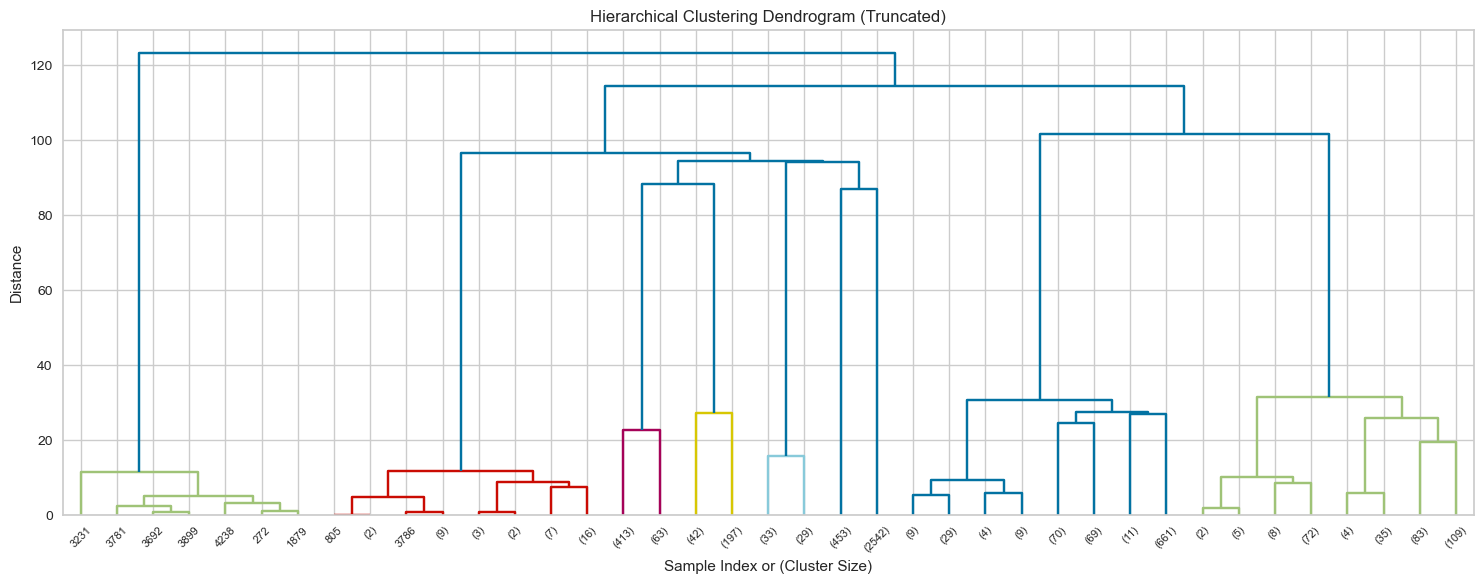

In [93]:
# Use a subset for performance if the dataset is very large
sample_size = 5000
X_sample = X_resampled_pca[:sample_size]

# Step 1: Compute linkage matrix (Ward method preserves cluster variance)
linkage_matrix = linkage(X_sample, method='ward')

# Step 2: Plot dendrogram
plt.figure(figsize=(15, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram (Truncated)")
plt.xlabel("Sample Index or (Cluster Size)")
plt.ylabel("Distance")
plt.tight_layout()
plt.savefig("hierarchical_cluster_2D.png", dpi=300)
plt.show()



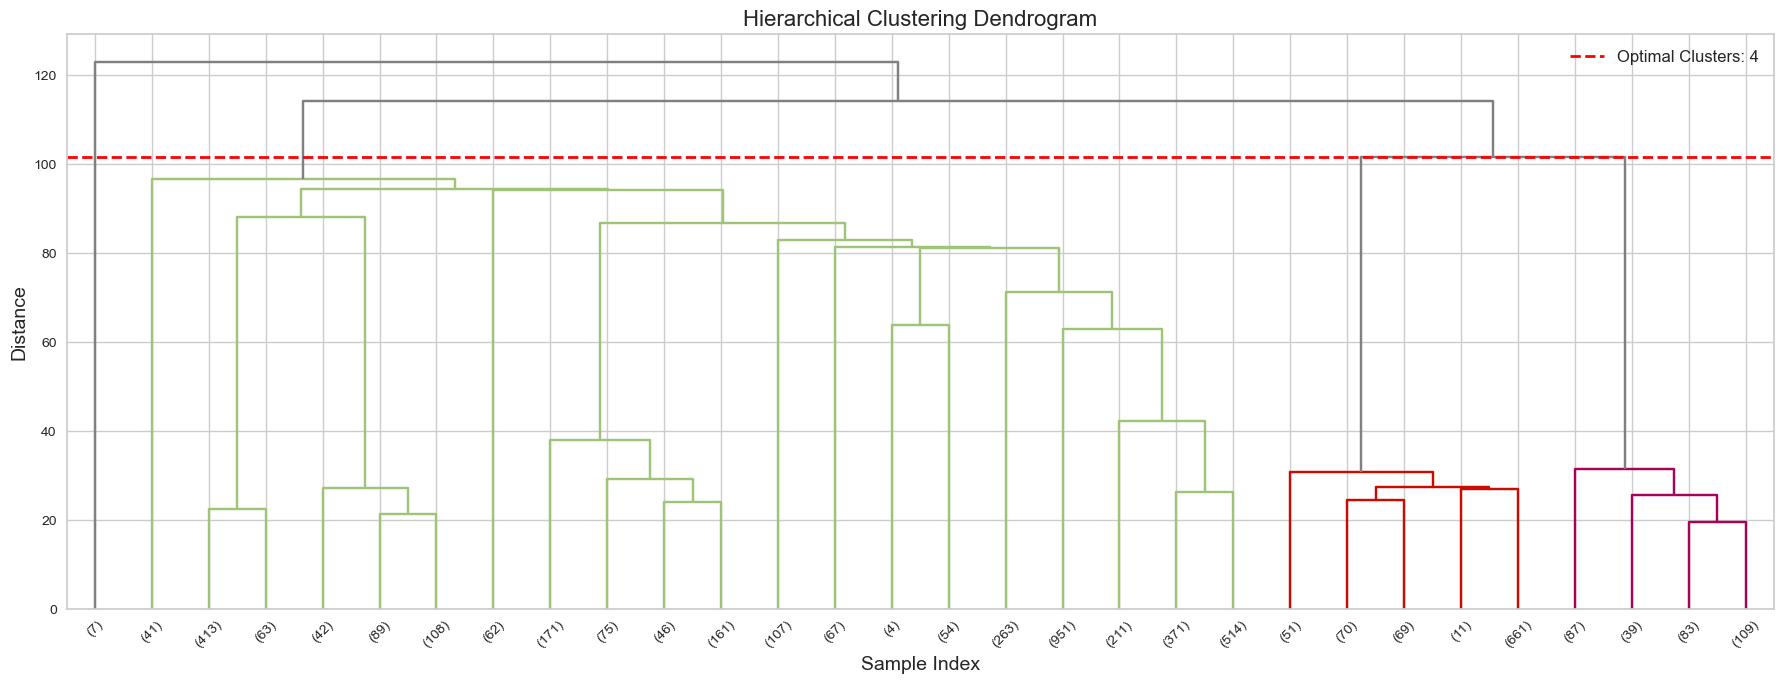

In [94]:
# Enhanced dendrogram with color threshold and cutoff line
optimal_clusters = 4  # you can experiment with 3 to 6
cut_height = linkage_matrix[-(optimal_clusters - 1), 2]

plt.figure(figsize=(18, 7))
dendrogram(linkage_matrix,
           truncate_mode='lastp',
           p=30,
           color_threshold=cut_height,
           above_threshold_color='gray',
           show_leaf_counts=True)

plt.axhline(y=cut_height, linestyle='--', color='red', linewidth=2, label=f'Optimal Clusters: {optimal_clusters}')
plt.title('Hierarchical Clustering Dendrogram', fontsize=16)
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Distance', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("dendrogram_cutoff_clusters.png", dpi=300)
plt.show()


Crosstab (Cluster vs Actual Default):
Default     0     1
Cluster            
0        3373  2246
1        1627  2754

Approximate Hierarchical Clustering Accuracy: 0.613


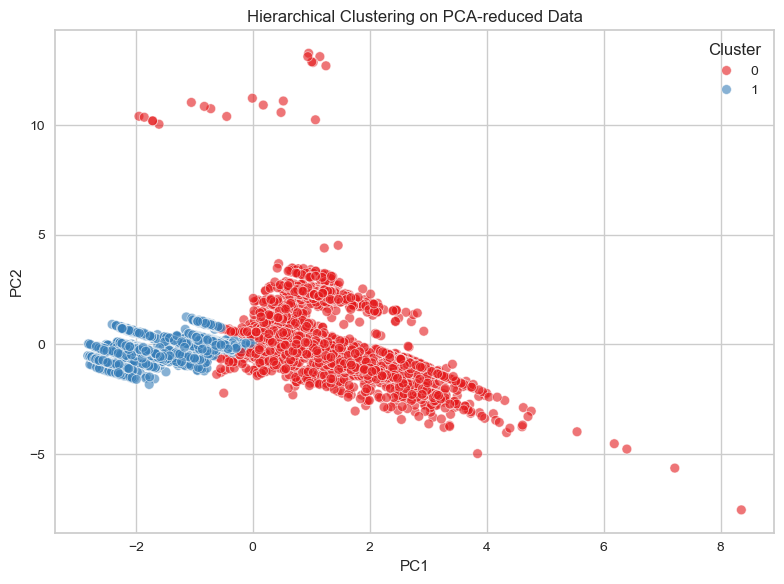

In [95]:
# Step 1: Reduce to 2 principal components

# Subsample 10,000 rows from the full PCA input and labels
X_small, y_small = resample(
    X_resampled_scaled,  # or X_resampled_pca if you're using PCA beforehand
    y_resampled,
    n_samples=10000,
    random_state=42,
    stratify=y_resampled
)

pca_2d = PCA(n_components=2, random_state=42)
X_small_pca2 = pca_2d.fit_transform(X_small)  # X_small = your 10k resampled scaled set

# Step 2: Run Agglomerative Clustering with Ward linkage
hier_cluster = AgglomerativeClustering(n_clusters=2, linkage='ward')
y_hier_labels = hier_cluster.fit_predict(X_small_pca2)

# Step 3: Combine with target
df_hier = pd.DataFrame(X_small_pca2, columns=['PC1', 'PC2'])
df_hier['Default'] = y_small.values  # y_small = actual default labels from the 10k sample
df_hier['Cluster'] = y_hier_labels

# Step 4: Crosstab
print("Crosstab (Cluster vs Actual Default):")
print(pd.crosstab(df_hier['Cluster'], df_hier['Default']))

# Step 5: Flip if necessary to maximise alignment
if accuracy_score(df_hier['Default'], y_hier_labels) < 0.5:
    y_hier_labels = 1 - y_hier_labels
    df_hier['Cluster'] = y_hier_labels

# Step 6: Accuracy
acc = accuracy_score(df_hier['Default'], df_hier['Cluster'])
print(f"\nApproximate Hierarchical Clustering Accuracy: {acc:.3f}")

# Step 7: Visualise clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_hier, x='PC1', y='PC2', hue='Cluster', palette='Set1', alpha=0.6)
plt.title("Hierarchical Clustering on PCA-reduced Data")
plt.grid(True)
plt.tight_layout()
plt.show()


Overall, hierarchical clustering failed to capture latent structure in the credit data. It lacked the discriminative power of K-Means and showed limited value for risk segmentation in this context.
                                                                                                                                                            

In [96]:
sil_score = silhouette_score(X_small_pca2, y_hier_labels)
print(f"Silhouette Score for Hierarchical Clustering: {sil_score:.3f}")


Silhouette Score for Hierarchical Clustering: 0.490


#### Value of Hierarchical Clustering
Agglomerative clustering showed poor separation between default and non-default classes (accuracy ~50%), indicating limited usefulness in this dataset. High overlap suggests hierarchical methods may not scale well or capture credit risk heterogeneity effectively.


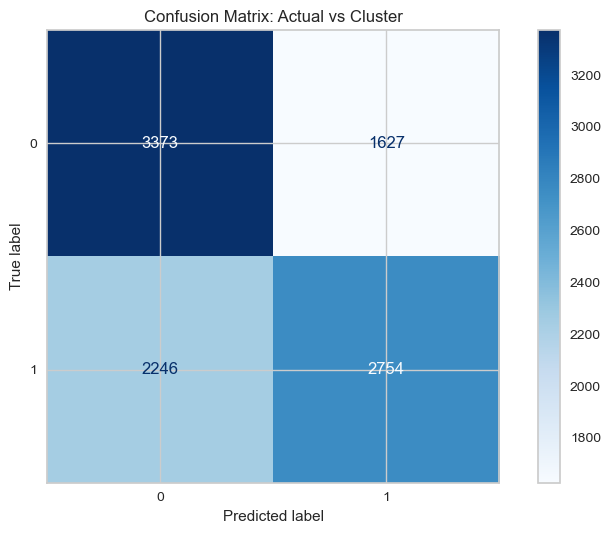

In [97]:
ConfusionMatrixDisplay.from_predictions(y_small, df_hier['Cluster'], cmap='Blues')
plt.title("Confusion Matrix: Actual vs Cluster")
plt.tight_layout()
plt.show()


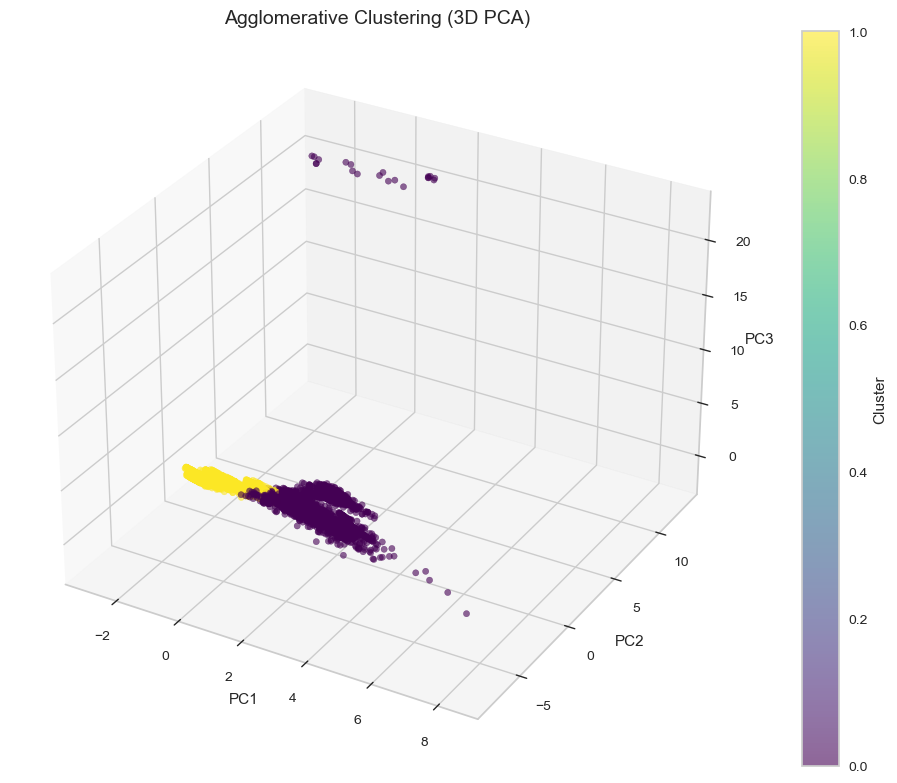

In [98]:
# Reduce to 3D
pca_3d = PCA(n_components=3, random_state=42)
X_3d = pca_3d.fit_transform(X_small)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=y_hier_labels, cmap='viridis', alpha=0.6)
ax.set_title('Agglomerative Clustering (3D PCA)', fontsize=14)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
fig.colorbar(sc, ax=ax, label="Cluster")
plt.tight_layout()
plt.savefig("hierarchical_3D_clusters.png", dpi=300)
plt.show()


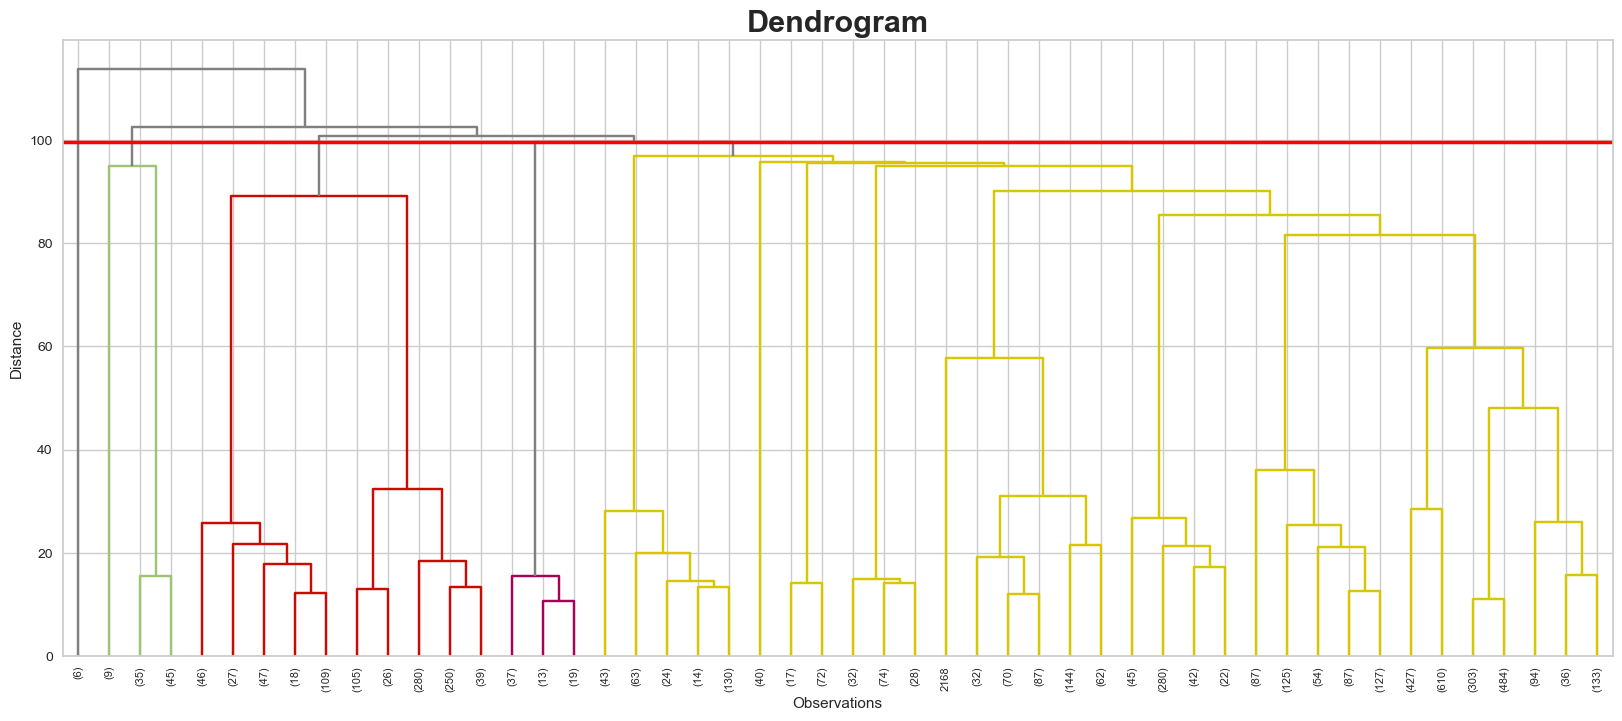

In [99]:
n_clusters = 5
sampled_data = principalDf2.sample(n=5000, random_state=10)

linkage_matrix = linkage(sampled_data, 'ward')

max_d = linkage_matrix[-(n_clusters-1), 2]

# Plotting the dendrogram
plt.figure(figsize=(20, 8))
dendrogram(
    linkage_matrix,
    orientation='top',
    truncate_mode='lastp',
    p=50,
    show_leaf_counts=True,
    color_threshold=max_d - 1,
    above_threshold_color='grey'
)

# Add horizontal line to denote the threshold for cutting the dendrogram
plt.axhline(y=max_d, c='red', linestyle='-', linewidth=2.5)

# Format the plot title and labels
plt.title('Dendrogram', fontsize=22, fontweight='bold')
plt.ylabel('Distance')
plt.xlabel('Observations')
plt.show()

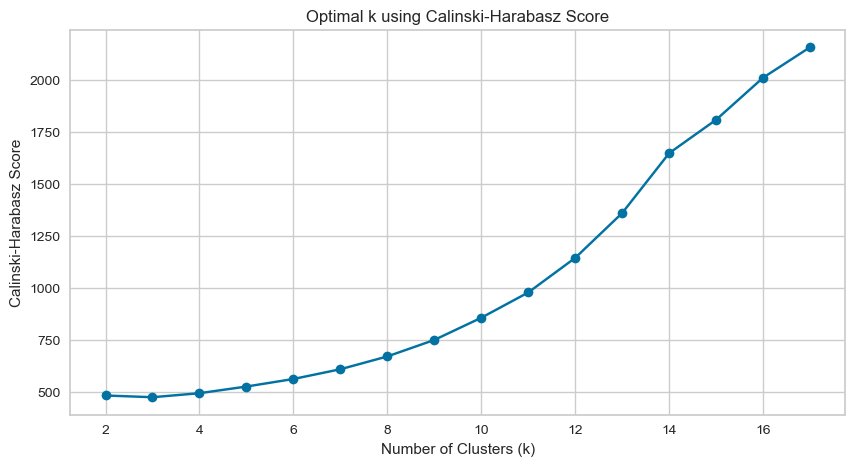

In [112]:
sampled_data = principalDf2.sample(n=5000, random_state=10)

calinski_scores = []

for k in range(2, 18):
    classifier = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
    y_pred = classifier.fit_predict(sampled_data)
    score = calinski_harabasz_score(sampled_data, y_pred)
    calinski_scores.append((k, score))

ks = [x[0] for x in calinski_scores]
scores = [x[1] for x in calinski_scores]

plt.figure(figsize=(10, 5))
plt.plot(ks, scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Optimal k using Calinski-Harabasz Score')
plt.grid(True)
plt.savefig("calinski.png", dpi=300)
plt.show()

In [115]:
classifier = AgglomerativeClustering(n_clusters = 4, affinity = "euclidean", linkage = "ward")
y_pred = classifier.fit_predict(principalDf2.sample(n= 5000, random_state = 10))

sampled_data["Cluster Label"] = y_pred

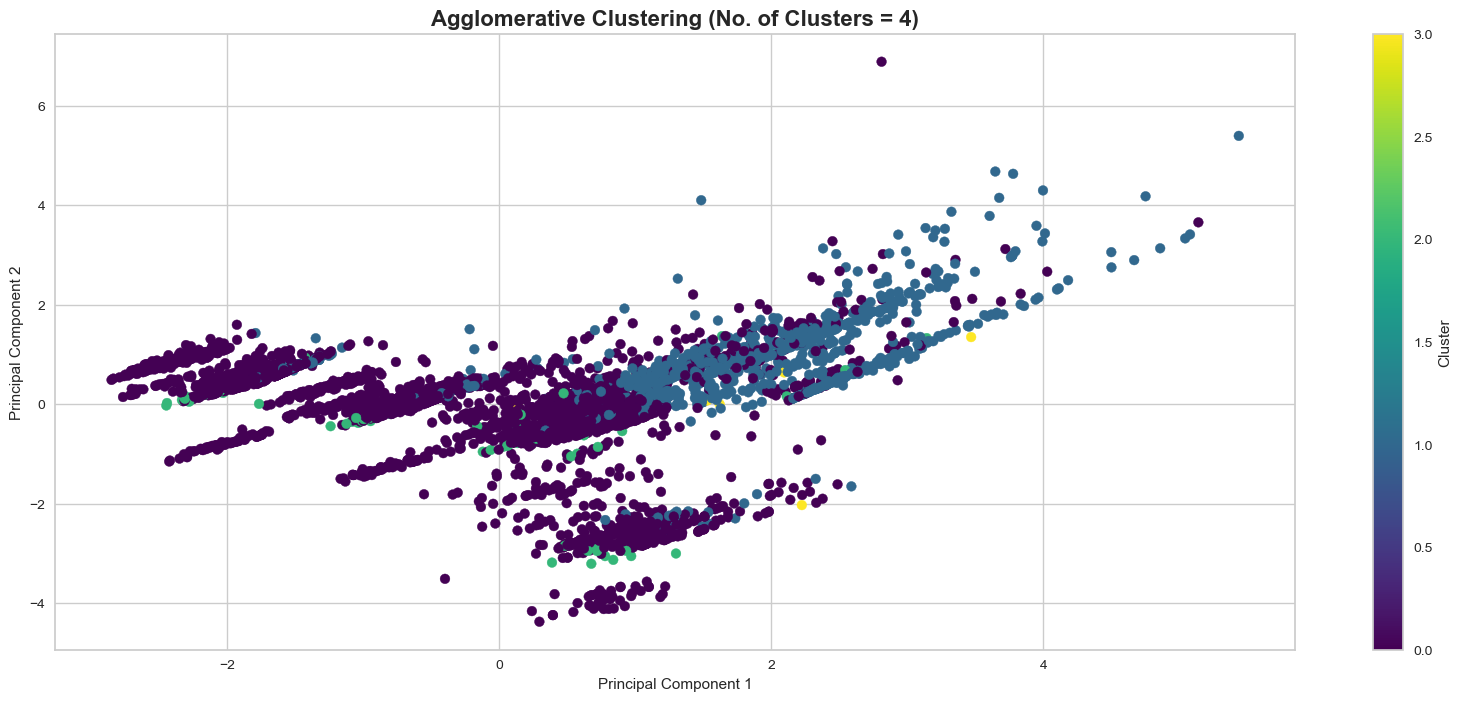

Cluster Label
0    3958
1     947
2      89
3       6
Name: count, dtype: int64

In [116]:
plt.figure(figsize=(20, 8))
plt.scatter(sampled_data['PC1'], sampled_data['PC2'], c=sampled_data['Cluster Label'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Agglomerative Clustering (No. of Clusters = 4)', fontsize = 16, fontweight = 'bold')
plt.colorbar().set_label('Cluster')
plt.savefig("pca_4.png", dpi=300)
plt.show()

sampled_data['Cluster Label'].value_counts()

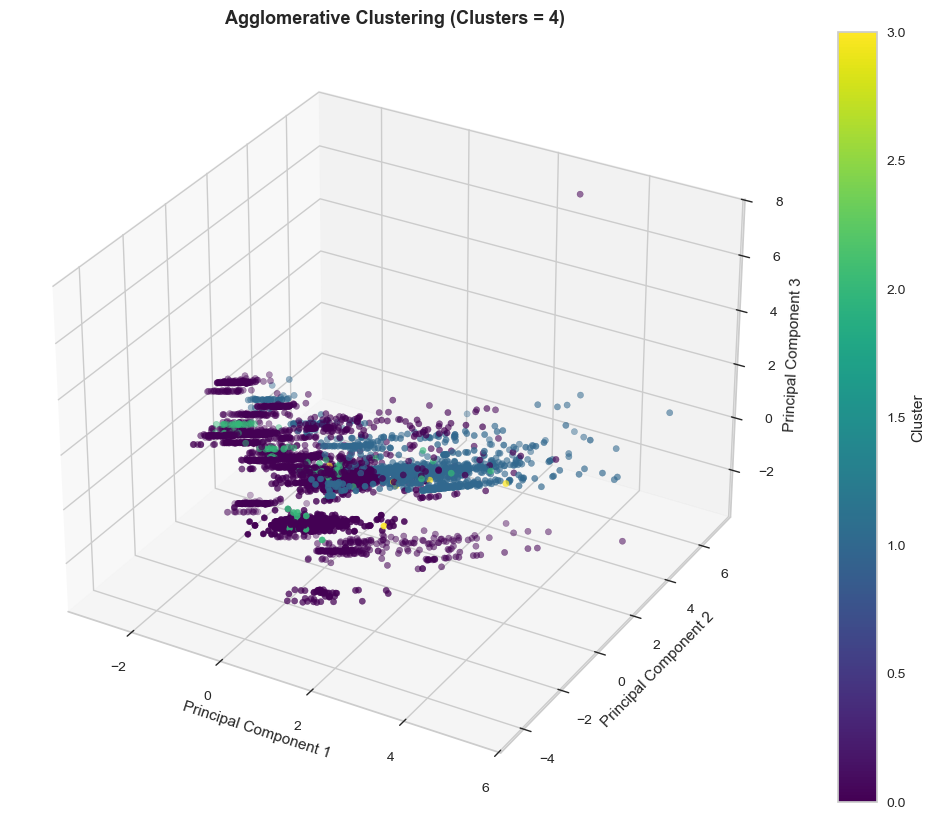

In [117]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(sampled_data['PC1'], sampled_data['PC2'], sampled_data['PC3'], c=sampled_data['Cluster Label'], cmap='viridis')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Agglomerative Clustering (Clusters = 4)', fontsize = '13', fontweight = 'bold')

colour = fig.colorbar(scatter, ax=ax)
colour.set_label('Cluster')
plt.savefig("pca_4_v2.png", dpi=300)
plt.show()